In [1]:
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
from kde_ebm.mixture_model import fit_all_gmm_models
from kde_ebm import mixture_model
from sSuStaIn.sEBMSustain import sEBMSustain, sEBMSustainData
import os
import numpy.ma as ma
from collections import Counter
from dateutil.relativedelta import relativedelta
from scipy.stats import chi2_contingency, kruskal, fisher_exact
from scipy.stats import spearmanr, kendalltau
from statannotations.Annotator import Annotator
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.ticker as mtick
from statsmodels.stats.multitest import multipletests

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
hfont = {'fontname':'Arial'}

In [4]:
def process_L(L, min_val=0):
    mx = ma.masked_less_equal(L,min_val)
    min_masked = mx.min(axis=0)
    L_new = mx.filled(fill_value=min_masked)
    return L_new

In [5]:
key_regions = ["hippocampus", "parahippocampal", "entorhinal", "amygdala", "cingulate", "frontal", "occipital", "ventricle"]
def get_selected_cols(cols, key_regions):
    region_dict = {}
    cols_include = []
    for region in key_regions:
        region_dict[region] = [_ for _, col in enumerate(cols) if region in col.lower()]
        cols_include += region_dict[region]
    return cols_include

## Change the path to the pickled file

In [6]:
# Read the pickled file
pickle_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/pickle_files/sim_tadpole19_subtype3.pickle"
with open(pickle_path, "rb") as input_file:
    pkl = pickle.load(input_file)

In [7]:
pkl["ml_subtype"].shape

(850, 1)

In [8]:
pkl["samples_likelihood"].shape

(2000000, 1)

### Check that the MCI and CN/AD files have same column names

In [9]:
# MCI and CN/AD data
cn_ad_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_first_cnad_no_5ventricle.csv"
df_cnad = pd.read_csv(cn_ad_path)
mci_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_first_mci_no_5_ventricle.csv"
df_mci = pd.read_csv(mci_path)
df_cnad["EXAMDATE"] = pd.to_datetime(df_cnad["EXAMDATE"])
df_mci["EXAMDATE"] = pd.to_datetime(df_mci["EXAMDATE"])
assert all(df_mci.columns == df_cnad.columns)

## Subtyping and Staging the subjects

### Get the probability matrices for CN/AD

In [10]:
# Get the mixture model for the CN/AD subjects
k=118
X = df_cnad.iloc[:,:k].values
bm_names = df_cnad.columns[:k].tolist()
y = df_cnad["DX"].map({"Dementia":1, "CN":0})
mm_fit = mixture_model.fit_all_gmm_models
mixture_models = mm_fit(X, y)
L_yes = np.zeros(X.shape)
L_no = np.zeros(X.shape)
for i in range(k):
    L_no[:, i], L_yes[:, i] = mixture_models[i].pdfs_mixture_components(X[:, i], None)

L_no = process_L(L_no)
L_yes = process_L(L_yes)

### Create a SuStaIn object to call the associated methods

In [11]:
# Create the SuStaIn object for the sEBM model
stage_sizes = [24,24,24,23,23]
N_startpoints           = 25
N_S_max                 = 3
rep = 20
N_iterations_MCMC_init = int(2e4)
N_iterations_MCMC       = int(5e5)  #Generally recommend either 1e5 or 1e6 (the latter may be slow though) in practice
n_stages = 5
min_clust_size = 2
p_absorb = 0.3
N_em = 100
SuStaInLabels = df_cnad.columns[:k].tolist()
dataset_name            = 'sim_tadpole19'
output_dir              = '/home/rtandon32/ebm/s-SuStain-outputs'
sustainType             = 'mixture_GMM'
output_folder           = os.path.join(output_dir, dataset_name + '_' + sustainType)
use_parallel_startpoints = True
sustain = sEBMSustain(L_yes, L_no, n_stages, stage_sizes, min_clust_size, p_absorb, rep, SuStaInLabels, N_startpoints, N_S_max, N_iterations_MCMC_init, N_iterations_MCMC, N_em, output_folder, dataset_name, use_parallel_startpoints)

### Get the prob mat for the mci subjects

In [12]:
# Get the prob mat for the mci subjects
X_mci = df_mci.iloc[:,:k].values
prob_mat_mci = mixture_model.get_prob_mat(X_mci, mixture_models)
L_no_mci = prob_mat_mci[:,:,0]
L_yes_mci = prob_mat_mci[:,:,1]
L_no_mci = process_L(L_no_mci)
L_yes_mci = process_L(L_yes_mci)

### Subtype and Stage the MCI subjects

In [13]:
# Subtype and Stage the MCI subjects
last_N = 1000000
N_samples = 1000
sustainData_newData = sEBMSustainData(L_yes_mci, L_no_mci, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]
temp_mean_f = np.mean(samples_f, axis=1)
ix = np.argsort(temp_mean_f)[::-1]

ml_subtype_mci, \
prob_ml_subtype_mci, \
ml_stage_mci, \
prob_ml_stage_mci, \
prob_subtype_mci, \
prob_stage_mci, \
prob_subtype_stage_mci, ll = sustain.subtype_and_stage_individuals(sustainData_newData, shape_seq, samples_sequence, samples_f, N_samples)


In [14]:
np.mean(ll), np.std(ll)

(-774902.0255866696, 19.58813528857821)

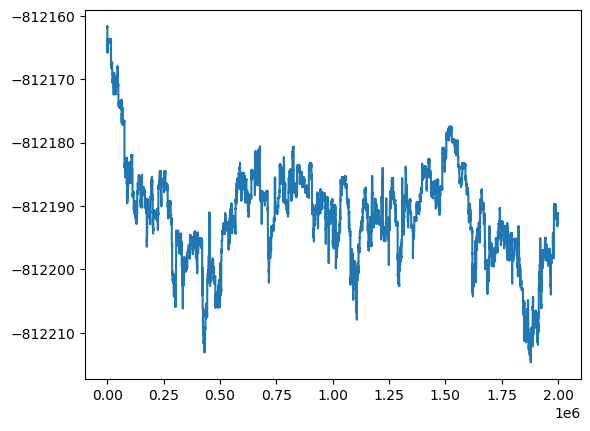

In [15]:
# plt.plot(ll)
plt.plot(pkl["samples_likelihood"])

### Subtype and Stage CN/AD data

In [16]:
# subtype and stage CN/AD data

sustainData_cnad = sEBMSustainData(L_yes, L_no, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]

ml_subtype_cnad, \
prob_ml_subtype_cnad, \
ml_stage_cnad, \
prob_ml_stage_cnad, \
prob_subtype_cnad, \
prob_stage_cnad, \
prob_subtype_stage_cnad, _ = sustain.subtype_and_stage_individuals(sustainData_cnad, shape_seq, samples_sequence,
                                                                   samples_f, N_samples)


In [17]:
n_cnad = ml_subtype_cnad.shape[0]
n_mci = ml_subtype_mci.shape[0]
unique_cnad, counts_cnad = np.unique(ml_subtype_cnad, return_counts=True)
unique_mci, counts_mci = np.unique(ml_subtype_mci, return_counts=True)

fraction_cnad = {}
dict_cnad = dict(zip(unique_cnad, counts_cnad))
for k, v in dict_cnad.items():
    fraction_cnad[k] = v/n_cnad
    
fraction_mci = {}
dict_mci = dict(zip(unique_mci, counts_mci))
for k, v in dict_mci.items():
    fraction_mci[k] = v/n_mci
    
print("CN/AD fractions across subtypes : \n", fraction_cnad)
print("MCI fractions across subtypes : \n", fraction_mci)

CN/AD fractions across subtypes : 
 {0.0: 0.47058823529411764, 1.0: 0.18941176470588236, 2.0: 0.17529411764705882, 3.0: 0.16470588235294117}
MCI fractions across subtypes : 
 {0.0: 0.48267326732673266, 1.0: 0.2202970297029703, 2.0: 0.1448019801980198, 3.0: 0.15222772277227722}


### Get subjects for a givensubtype

### Prepare final dataframe which has subtype, stage, PTID, DX, and EXAMDATE for all subjects

In [18]:
# DataFrame for CN/AD subjects
array_subtype_stage_cnad = np.hstack([ml_subtype_cnad, ml_stage_cnad, y.values.reshape(-1,1)])
cnad_solved = pd.DataFrame(data=array_subtype_stage_cnad, columns=["subtype", "stage", "DX"])
cnad_solved[["PTID", "EXAMDATE", "VISCODE"]] = df_cnad[["PTID", "EXAMDATE", "VISCODE"]]

In [19]:
# DataFrame for MCI subjects
array_subtype_stage_mci = np.hstack([ml_subtype_mci, ml_stage_mci])
mci_solved = pd.DataFrame(data=array_subtype_stage_mci, columns=["subtype", "stage"])
mci_solved["DX"] = 2.0
mci_solved[["PTID", "EXAMDATE", "VISCODE"]] = df_mci[["PTID", "EXAMDATE", "VISCODE"]]
final_df = pd.concat([cnad_solved, mci_solved], axis=0)

In [20]:
final_df["DX"] = final_df["DX"].map({0.0:"Controls", 1.0:"AD", 2.0:"MCI"})

# Prepare final_df (Add RID)

In [21]:
final_df["RID"] = final_df["PTID"].apply(lambda x: int(x.split("_")[-1]))

# Process data for filtering operations / StatsModel

In [22]:
def process_df(df, fld, keep="first"):
    df_fld = df.dropna(subset=[fld])
    df_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_fld.drop_duplicates("sid", keep=keep, inplace=True)
    return df_fld

def regress_score(df, field, covariates, examdate="EXAMDATE", n_subtypes=4):
    subtypes = list(range(n_subtypes))
    df_fld = df.dropna(subset=[field])
    df_fld.sort_values(["sid", examdate], inplace=True)
    df_fld.drop_duplicates("sid", keep="first", inplace=True)
    one_hot_cols = pd.get_dummies(df_fld["subtype"])
    one_hot_cols = one_hot_cols[subtypes]
    new_cols = ["st{}".format(_) for _ in subtypes]
    one_hot_cols.columns = new_cols
    df_one_hot = pd.concat([df_fld[covariates+[field]], one_hot_cols], axis=1)
    return df_one_hot

def regress_OLS(df, fld, cov):
    model = sm.OLS(df[[fld]], sm.add_constant(df[cov]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params, results.bse, results.conf_int()],axis=1)
    stats_df.columns = ["p-vals", "coef","std-err","conf-int-lower95", "conf-int-upper95"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    stats_df["f-pvalue"] = results.f_pvalue
    return stats_df

def regress_Logit(df, fld, cov):
    model = sm.Logit(df[[fld]], sm.add_constant(df[cov]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params, results.bse, results.conf_int()],axis=1)
    stats_df.columns = ["p-vals", "coef","std-err","conf-int-lower95", "conf-int-upper95"]
    stats_df["fld"] = fld
    stats_df["psuedo-r-sq"] = results.prsquared
    stats_df["llr_pvalue"] = results.llr_pvalue
    return stats_df

def regress_OLS_logodds(df, fld, cov):
    model = sm.OLS(np.log(df[[fld]]/(1 - df[[fld]])), sm.add_constant(df[cov]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params, results.bse, results.conf_int()],axis=1)
    stats_df.columns = ["p-vals", "coef","std-err","conf-int-lower95", "conf-int-upper95"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    stats_df["f-pvalue"] = results.f_pvalue
    return stats_df

In [23]:
final_df

,subtype,stage,DX,PTID,EXAMDATE,VISCODE,RID
0,3.0,2.0,Controls,002_S_0295,2006-05-09,bl,295
1,3.0,1.0,Controls,002_S_0413,2007-06-01,m12,413
2,1.0,2.0,Controls,002_S_0559,2006-06-20,bl,559
3,1.0,3.0,AD,002_S_0619,2006-12-13,m06,619
4,2.0,4.0,Controls,002_S_0685,2010-07-15,m48,685
...,...,...,...,...,...,...,...
803,1.0,3.0,MCI,941_S_4100,2015-08-28,m48,4100
804,0.0,0.0,MCI,941_S_4187,2011-08-25,bl,4187
805,0.0,3.0,MCI,941_S_4377,2012-02-14,bl,4377
806,0.0,0.0,MCI,941_S_4420,2012-04-03,bl,4420


## Directory path

In [24]:
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"

## PHS (Polygenic Hazard Scores)

In [25]:
# Read PRS scores from the Desikan Lab - (Ignore for now)

In [26]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/medical_history/"
# "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/medical_history/DESIKANLAB_31May2024.csv"
file_name_prs = "DESIKANLAB_31May2024.csv"
df_prs = pd.read_csv(os.path.join(mh_dir, file_name_prs))
df_prs.drop_duplicates("RID", inplace=True)
# df_prs = pd.merge(final_df, df_prs, on=["RID"], how="inner", suffixes=[None, "_y"])
df_prs2 = pd.merge(final_df, df_prs, on=["RID"], how="inner", suffixes=[None, "_y"])
df_prs2["subtype"] += 1

In [27]:
# df_prs2_mci = df_prs2[df_prs2["DX"].isin(["MCI"])]
df_prs2_st = df_prs2[df_prs2["subtype"].isin([1,2,3,4])]
model_phs = sm.OLS(df_prs2_st["stage"], sm.add_constant(df_prs2_st["PHS"]))
results_phs = model_phs.fit()
print(results_phs.summary())

                            OLS Regression Results                            
Dep. Variable:                  stage   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     28.18
Date:                Sun, 16 Jun 2024   Prob (F-statistic):           1.28e-07
Time:                        14:06:57   Log-Likelihood:                -2554.1
No. Observations:                1453   AIC:                             5112.
Df Residuals:                    1451   BIC:                             5123.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3942      0.041     57.870      0.0

In [28]:
results_phs.pvalues

const    0.000000e+00
PHS      1.275817e-07
dtype: float64

In [29]:
# df_phs_resid = df_prs2[["PHS", "APOE4"]]
# model_phs = sm.OLS(df_prs2["PHS"], sm.add_constant(df_prs2["AGE"]))
# results_phs = model_phs.fit()
# df_prs2["residual"] = results_phs.resid
# df_prs2["subtypes"] = pd.from_dummies(df_prs2[["st0", "st1", "st2", "st3"]])
# kruskal(*[group["PHS"].values for name, group in df_prs2.groupby("stage")])

In [34]:
kruskal(*[group["PHS"].values for name, group in df_prs2.groupby("subtype")])

KruskalResult(statistic=5.612525037008709, pvalue=0.13206115552234798)

<AxesSubplot: xlabel='subtype', ylabel='PHS'>

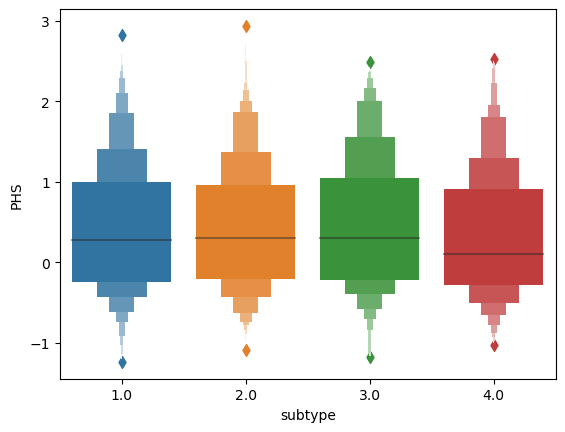

In [35]:
sns.boxenplot(data=df_prs2, x="subtype", y="PHS")

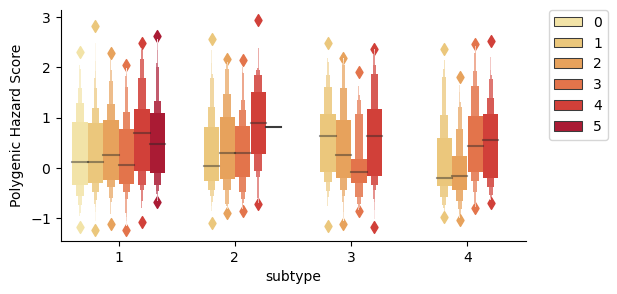

In [36]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=False, figsize=(6,3))
test_name = "PHS"
df_prs2["stage"] = df_prs2["stage"].astype(int)
df_prs2["subtype"] = df_prs2["subtype"].astype(int)

sns.boxenplot(data=df_prs2[df_prs2["DX"].isin(["Controls","MCI","AD"])], 
              x="subtype", y="PHS", palette="YlOrRd", ax=ax, hue="stage")
ax.set_ylabel("Polygenic Hazard Score")
# ax.set_title(fld, fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
ax.legend(bbox_to_anchor=(1.05, 1.00), loc='upper left', borderaxespad=0, ncol=1)
# fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

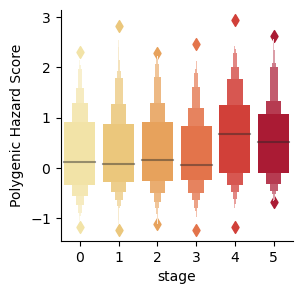

In [37]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=False, figsize=(3,3))
test_name = "PHS"
df_prs2["stage"] = df_prs2["stage"].astype(int)
sns.boxenplot(data=df_prs2[df_prs2["DX"].isin(["Controls","MCI","AD"])], 
              x="stage", y="PHS", palette="YlOrRd", ax=ax)
ax.set_ylabel("Polygenic Hazard Score")
# ax.set_title(fld, fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
# fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [38]:
ravlt_trials = [-0.16,-0.30, -0.40, -0.51, -0.62, -0.82]

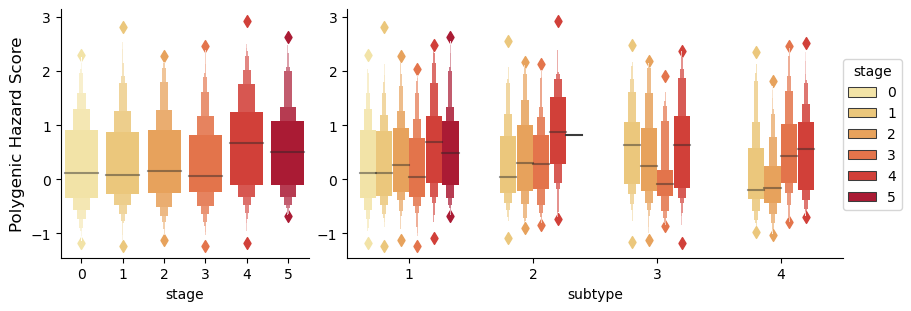

In [39]:
fig = plt.figure(figsize=(9, 3), layout="constrained")
spec = fig.add_gridspec(1, 3)
ax0 = fig.add_subplot(spec[0])
ax10 = fig.add_subplot(spec[1:])
sns.boxenplot(data=df_prs2[df_prs2["DX"].isin(["Controls","MCI","AD"])], 
              x="stage", y="PHS", palette="YlOrRd", ax=ax0)
sns.boxenplot(data=df_prs2[df_prs2["DX"].isin(["Controls","MCI","AD"])], 
              x="subtype", y="PHS", palette="YlOrRd", ax=ax10, hue="stage")
ax0.set_ylabel("Polygenic Hazard Score", fontsize=12)
ax10.set_ylabel("", fontsize=12)
ax0.spines[['right', 'top']].set_visible(False)
ax10.spines[['right', 'top']].set_visible(False)
# ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
ax10.legend(bbox_to_anchor=(1.0, 0.8), loc='upper left', borderaxespad=0, ncol=1, title="stage")
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [40]:
chi2_contingency(df_xx.groupby(["stage", "APOE4"]).size().unstack(level=1).fillna(0))

NameError: name 'df_xx' is not defined

In [ ]:
print(results_phs.summary())

In [41]:
mci_solved

,subtype,stage,DX,PTID,EXAMDATE,VISCODE
0,0.0,4.0,2.0,002_S_0729,2007-02-22,m06
1,1.0,4.0,2.0,002_S_0782,2007-03-28,m06
2,2.0,4.0,2.0,002_S_0954,2007-05-03,m06
3,1.0,1.0,2.0,002_S_1070,2006-12-11,bl
4,1.0,1.0,2.0,002_S_1155,2011-12-23,m60
...,...,...,...,...,...,...
803,1.0,3.0,2.0,941_S_4100,2015-08-28,m48
804,0.0,0.0,2.0,941_S_4187,2011-08-25,bl
805,0.0,3.0,2.0,941_S_4377,2012-02-14,bl
806,0.0,0.0,2.0,941_S_4420,2012-04-03,bl


### Directory path

# Prepare Longitudinal Data  with subtypes and stages

In [42]:
# Functions for reading longitudinal data and subtyping/staging
def read_long(df_cnad, df_mci, k):
    long_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_long_no_5_ventricle.csv"
    df_long = pd.read_csv(long_path)
    df_long["EXAMDATE"] = pd.to_datetime(df_long["EXAMDATE"])
    assert all(df_long.columns[:k] == df_cnad.columns[:k])
    cnad_ptid = df_cnad["PTID"].tolist()
    mci_ptid = df_mci["PTID"].tolist()
    df_long_cnad = df_long[df_long["sid"].isin(cnad_ptid)]
    df_long_mci = df_long[df_long["sid"].isin(mci_ptid)]
    return df_long, df_long_cnad, df_long_mci

def subtype_stage(L_yes, L_no, pkl, n_stages, last_N=1000000, N_samples=1000):
    sustainData_mci_long = sEBMSustainData(L_yes, L_no, n_stages)
    samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
    samples_f = pkl["samples_f"][:,-last_N:]
    shape_seq = pkl["shape_seq"]
    temp_mean_f = np.mean(samples_f, axis=1)
    ix = np.argsort(temp_mean_f)[::-1]

    ml_subtype, \
    prob_ml_subtype, \
    ml_stage, \
    prob_ml_stage, \
    prob_subtype, \
    prob_stage, \
    prob_subtype_stage,_ = sustain.subtype_and_stage_individuals(sustainData_mci_long, shape_seq, samples_sequence, samples_f, N_samples)
    return ml_subtype, prob_ml_subtype, ml_stage, prob_ml_stage, prob_subtype, prob_stage, prob_subtype_stage

# Read the long df (MCI and CNAD)
k = 118
df_long, df_long_cnad, df_long_mci = read_long(df_cnad, df_mci, k)

# Get the prob_mat for MCI
prob_mat_mci_long = mixture_model.get_prob_mat(df_long_mci.iloc[:,:k].values, mixture_models)
L_no_mci_long = prob_mat_mci_long[:,:,0]
L_yes_mci_long = prob_mat_mci_long[:,:,1]
L_yes_mci_long = process_L(L_yes_mci_long)
L_no_mci_long = process_L(L_no_mci_long)

# Subtype and Stage the MCI subjects and subset them for the relevant columns
ml_subtype_mci, prob_ml_subtype_mci, ml_stage_mci, \
prob_ml_stage_mci, prob_subtype_mci, prob_stage_mci, prob_subtype_stage_mci = subtype_stage(L_yes_mci_long, L_no_mci_long, pkl, n_stages)
df_long_mci["subtype"] = ml_subtype_mci
df_long_mci["stage"] = ml_stage_mci
df_long_mci["RID"] = df_long_mci["sid"].apply(lambda x: int(x.split("_")[-1]))
df_long_mci["PTGENDER"] = df_long_mci["PTGENDER"].map({"Female":0, "Male":1})
mci_subset = ["subtype", "stage", "VISCODE", "EXAMDATE", "DX", "sid", "RID", "AGE", "PTGENDER", "PTEDUCAT", "APOE4"]
df_long_mci_subset = df_long_mci[mci_subset]

In [43]:
prob_mat_cnad_long = mixture_model.get_prob_mat(df_long_cnad.iloc[:,:k].values, mixture_models)
L_no_cnad_long = prob_mat_cnad_long[:,:,0]
L_yes_cnad_long = prob_mat_cnad_long[:,:,1]
L_yes_cnad_long = process_L(L_yes_cnad_long)
L_no_cnad_long = process_L(L_no_cnad_long)
# Subtype and Stage the CN/AD subjects and subset them for the relevant columns
ml_subtype_cnad, prob_ml_subtype_cnad, ml_stage_cnad, \
prob_ml_stage_cnad, prob_subtype_cnad, prob_stage_cnad, prob_subtype_stage_cnad = subtype_stage(L_yes_cnad_long, L_no_cnad_long, pkl, n_stages)
df_long_cnad["subtype"] = ml_subtype_cnad
df_long_cnad["stage"] = ml_stage_cnad
df_long_cnad["RID"] = df_long_cnad["sid"].apply(lambda x: int(x.split("_")[-1]))
df_long_cnad["PTGENDER"] = df_long_cnad["PTGENDER"].map({"Female":0, "Male":1})
cnad_subset = ["subtype", "stage", "VISCODE", "EXAMDATE", "DX", "sid", "RID", "AGE", "PTGENDER", "PTEDUCAT", "APOE4"]
df_long_cnad_subset = df_long_cnad[cnad_subset]

In [44]:
df_long_all = pd.concat([df_long_cnad, df_long_mci], axis=0)

## Read the ADNIMERGE file 

In [45]:
# Read the ADNIMERGE file     
adnimerge_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/ADNIMERGE.csv"
df_adnimerge =pd.read_csv(adnimerge_path)
df_adnimerge["EXAMDATE"] = pd.to_datetime(df_adnimerge["EXAMDATE"])

In [46]:
df_adnimerge["ABETA"] = df_adnimerge["ABETA"].replace([">1700","<200"],[1700,200])
df_adnimerge["ABETA"] = df_adnimerge["ABETA"].astype(float)
df_adnimerge["TAU"] = df_adnimerge["TAU"].replace(["<80",">1300"],[80,1300])
df_adnimerge["TAU"] = df_adnimerge["TAU"].astype(float)
df_adnimerge["PTAU"] = df_adnimerge["PTAU"].replace(["<8", ">120"],[8,120])
df_adnimerge["PTAU"] = df_adnimerge["PTAU"].astype(float)

In [47]:
df_long_adnimerge = pd.merge(df_long_mci, df_adnimerge, on=["PTID", "EXAMDATE"], how="inner", suffixes=[None,"_"])
df_long_adnimerge.sort_values(by=["PTID", "EXAMDATE"], inplace=True)
df_long_adnimerge["stage"] = df_long_adnimerge["stage"].astype(int)

In [48]:
df_long_all_adnimerge = pd.merge(df_long_all, df_adnimerge, on=["PTID", "EXAMDATE"], how="inner", suffixes=[None,"_"])
df_long_all_adnimerge.sort_values(by=["PTID", "EXAMDATE"], inplace=True)
df_long_all_adnimerge["stage"] = df_long_all_adnimerge["stage"].astype(int)

In [49]:
palette_color1="YlOrRd"
palette_subtype="hls"

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 5.00e-03 < p <= 5.00e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: 5.00e-05 < p <= 5.00e-04
    ****: p <= 5.00e-05

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.550e-01 U_stat=7.334e+03
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.419e-01 U_stat=1.410e+04
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.291e-01 U_stat=1.006e+04
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.783e-02 (ns) U_stat=1.198e+04
4 vs. 5: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.713e-01 U_stat=3.728e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 5.00e-03 < p <= 5.00e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: 5.00e-05 < p <= 5.00e-04
    ****: p <= 5.00e-05

0 vs. 1: Mann-Whitney-Wilcoxon test 

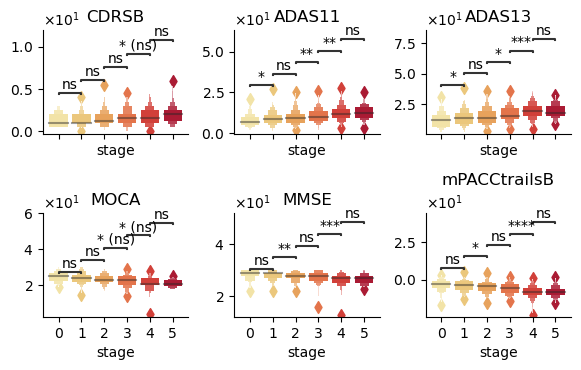

In [50]:
flds = ["CDRSB", "ADAS11", "ADAS13", "MOCA", "MMSE", "mPACCtrailsB"]

pairs = [(0,1),(1,2),(2,3),(3,4),(4,5)]
fig, ax = plt.subplots(2,3, sharex=True, sharey=False, figsize=(6,4))
test_name = "composite_neuropsych_score_stat_annotator"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    r = _//3
    c = _%3
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c], palette=palette_color1)
    annotator = Annotator(ax[r,c], pairs, data=df_mh_fld, x="stage", y=fld)
    annotator._pvalue_format.pvalue_thresholds =  [[5e-2, '*'], [5e-3, '**'], [5e-4, '***'], [5e-5, '****'], [1, 'ns']]
    annotator.configure(test='Mann-Whitney', text_format='star', 
                        loc='inside',comparisons_correction="Benjamini-Hochberg")
    annotator.apply_and_annotate()
    ax[r,c].set_ylabel("")
    ax[r,c].set_title(fld, fontsize=12)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [51]:
box_props = dict(edgecolor="red")

# Individual fields (MOCA)

In [52]:
sns.__version__

'0.10.1'

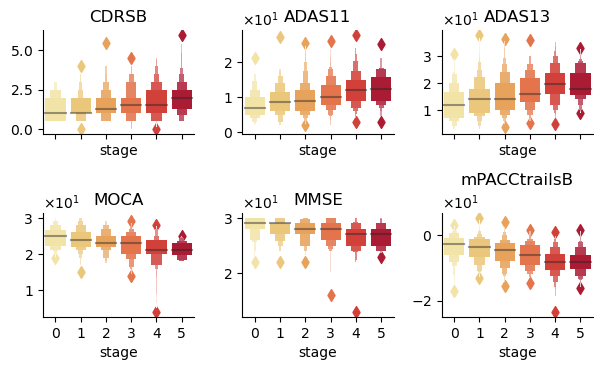

In [53]:
flds = ["CDRSB", "ADAS11", "ADAS13", "MOCA", "MMSE", "mPACCtrailsB"]
fig, ax = plt.subplots(2,3, sharex=True, sharey=False, figsize=(6,4))
test_name = "composite_neuropsych_score"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    r = _//3
    c = _%3
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c], palette=palette_color1)
    ax[r,c].set_ylabel("")
    ax[r,c].set_title(fld, fontsize=12)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [54]:
test_name = "composite_neuropsych_score_stat"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage", "RID"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

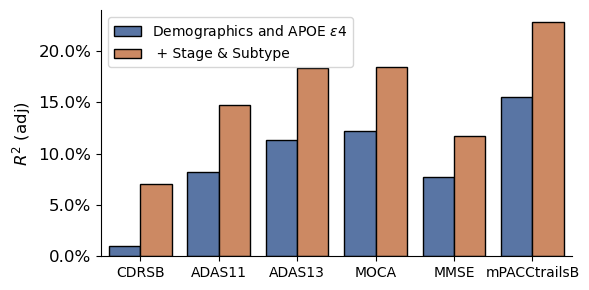

In [55]:
stats_df_all["r-sq-adj"] *= 100
fig, ax = plt.subplots(1,1,figsize=(6,3))
sns.barplot(data=stats_df_all, x="fld", y="r-sq-adj", hue="n-cov", 
            hue_order = ["excl-sustain", "incl-sustain"], ax=ax,
           palette="deep", edgecolor='k')
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=10,rotation=0)
ax.set_ylabel(r'$R^{2}$ (adj)', fontsize=12)
ax.set_xlabel("")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
leg = ax.get_legend()
leg.set_title("")
new_labels = [r'Demographics and APOE $\varepsilon$4', ' + Stage & Subtype']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}_bar.png".format(test_name)), dpi=300)

In [56]:
df_xx

,AGE,PTGENDER,PTEDUCAT,APOE4,stage,RID,mPACCtrailsB,st0,st1,st2,st3
0,65.1,0,16,1.0,4,729,-7.882890,1,0,0,0
4,81.6,1,16,0.0,4,782,-0.981252,0,1,0,0
8,69.3,0,14,1.0,4,954,-13.514500,0,0,1,0
11,73.6,1,14,0.0,1,1070,-11.008000,0,1,0,0
15,57.8,1,20,0.0,1,1155,0.817791,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2945,78.5,0,12,0.0,3,4100,-9.110660,0,1,0,0
2946,62.0,1,16,0.0,0,4187,-3.860670,1,0,0,0
2951,69.3,0,12,1.0,3,4377,-3.356650,1,0,0,0
2955,81.4,1,18,0.0,0,4420,-6.392730,1,0,0,0


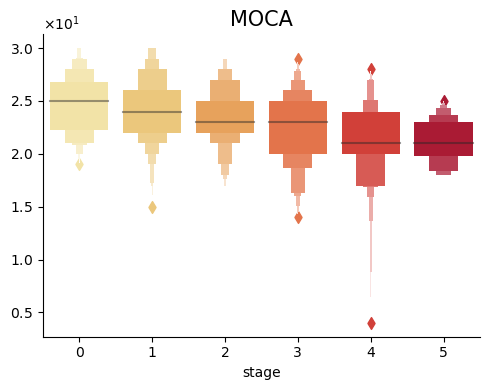

In [57]:
fld = "MOCA"
fig, ax = plt.subplots(1,1, sharex=True, sharey=False, figsize=(5,4))
test_name = "MOCA_test"
df_mh_fld = process_df(df_long_adnimerge, fld)
sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax,palette=palette_color1)
ax.set_ylabel("")
ax.set_title(fld, fontsize=15)
ax.spines[['right', 'top']].set_visible(False)
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
dir_path = '/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2'
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [58]:
fld = "MOCA"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
df_xx.dropna(inplace=True)
model = sm.OLS(df_xx[[fld]], sm.add_constant(df_xx[cov1]))
results = model.fit()

In [59]:
cnad_ptid = df_cnad["PTID"].unique().tolist()
mci_ptid = df_mci["PTID"].unique().tolist()
cn_ptid = df_cnad[df_cnad["DX"].isin(["CN"])]["PTID"].unique().tolist()
ad_ptid = df_cnad[df_cnad["DX"].isin(["Dementia"])]["PTID"].unique().tolist()

## Median Regression (example)

In [60]:
model = smf.quantreg("MOCA ~ AGE + PTGENDER + APOE4 + PTEDUCAT + stage + st1 + st2 + st3", df_xx)
fld = "TAU"
df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
model = smf.quantreg("TAU ~ AGE + PTGENDER + APOE4 + PTEDUCAT + stage + st1 + st2 + st3", df_xx)
res = model.fit(q=0.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                    TAU   Pseudo R-squared:              0.08979
Model:                       QuantReg   Bandwidth:                       60.68
Method:                 Least Squares   Sparsity:                        247.4
Date:                Sun, 16 Jun 2024   No. Observations:                  551
Time:                        14:11:57   Df Residuals:                      542
                                        Df Model:                            8
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.2841     67.690     -0.196      0.844    -146.251     119.683
AGE            3.8352      0.853      4.498      0.000       2.160       5.510
PTGENDER     -23.0474     12.057     -1.912      0.056     -46.732       0.637
APOE4         52.0159      7.966      6.529      0.0

In [61]:
1 - np.square(df_xx[fld] - np.ceil(results.predict(sm.add_constant(df_xx[cov1])))).sum()/(np.var(df_xx[[fld]])*(df_xx.shape[0]-1))


TAU   -3.673396
dtype: float64

In [62]:
np.var(df_xx[[fld]])

TAU    18739.415455
dtype: float64

In [63]:
results.predict()

array([25.89619345, 25.11546809, 24.71200879, 25.5454656 , 22.61331004,
       24.09694034, 22.84035824, 22.3309793 , 24.30263494, 24.31608461,
       23.00610629, 24.72364666, 25.25232573, 23.50618864, 23.94491683,
       24.26597259, 23.92219962, 23.7459543 , 21.78017245, 22.90118824,
       22.79525848, 23.20918797, 22.30365841, 22.37908076, 24.51123093,
       24.1631575 , 24.98271414, 20.83799162, 22.64614524, 24.57634765,
       23.31618304, 23.04216628, 24.54679988, 23.57774272, 22.76636873,
       21.87259787, 21.84492844, 23.46130618, 24.75186754, 22.66865565,
       21.90997499, 25.1332581 , 20.39827734, 23.51149154, 20.9621037 ,
       23.97756957, 24.94138471, 22.36312407, 24.54729392, 21.83478612,
       22.6378745 , 22.32592618, 22.39906423, 22.98731271, 24.19931934,
       21.20808722, 24.18274312, 23.9354573 , 23.10576281, 22.68465584,
       22.55152026, 22.7780684 , 20.58465594, 23.78733962, 21.432536  ,
       21.42975977, 25.3927383 , 24.03364146, 22.35939958, 24.18

## EcogPT/SP scores

### Study Partner (SP) and Patient (Pt)

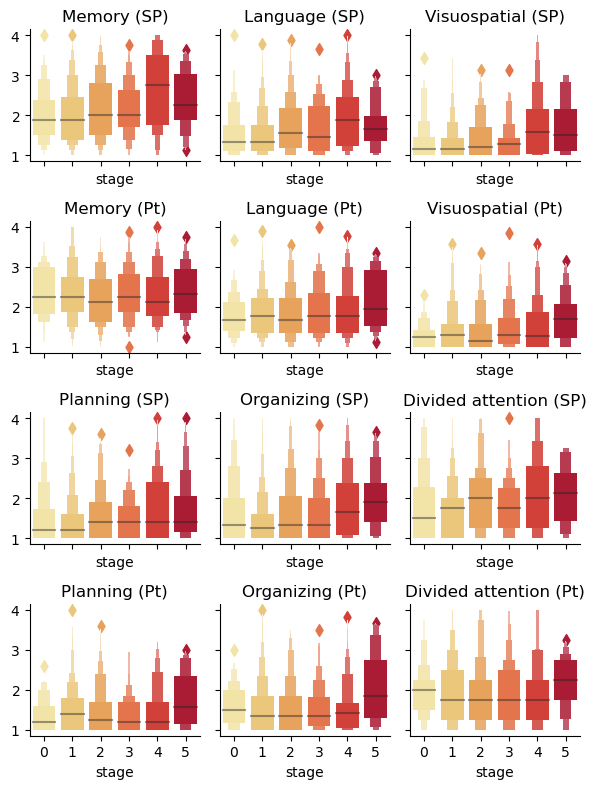

In [64]:
flds = ["EcogSPMem", "EcogSPLang", "EcogSPVisspat"] + ["EcogPtMem", "EcogPtLang", "EcogPtVisspat"] + \
["EcogSPPlan","EcogSPOrgan", "EcogSPDivatt"] + ["EcogPtPlan","EcogPtOrgan", "EcogPtDivatt"]

flds_title = {"EcogSPMem":"Memory (SP)", "EcogSPLang":"Language (SP)", "EcogSPVisspat":"Visuospatial (SP)", 
              "EcogPtMem":"Memory (Pt)", "EcogPtLang":"Language (Pt)", "EcogPtVisspat":"Visuospatial (Pt)",
             "EcogPtPlan":"Planning (Pt)","EcogPtOrgan": "Organizing (Pt)", "EcogPtDivatt":"Divided attention (Pt)", 
             "EcogSPPlan":"Planning (SP)","EcogSPOrgan": "Organizing (SP)", "EcogSPDivatt":"Divided attention (SP)"}
fig, ax = plt.subplots(4,3, sharex=True, sharey=True, figsize=(6,8))
test_name = "Everyday-Cognition-sub-items"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    r = _//3
    c = _%3
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c], palette=palette_color1)
    ax[r,c].set_ylabel("")
    ax[r,c].set_title(flds_title[fld], fontsize=12)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [65]:
test_name = "EcogSP_summary_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

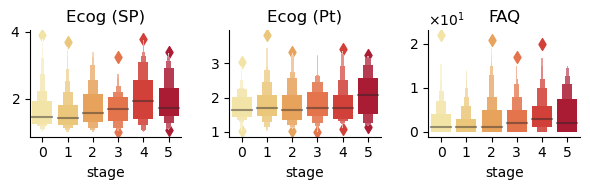

In [66]:
flds = ["EcogSPTotal", "EcogPtTotal", "FAQ"]


flds_title = {"EcogSPTotal":"Ecog (SP)", 
              "EcogPtTotal":"Ecog (Pt)",
              "FAQ":"FAQ"}
fig, ax = plt.subplots(1,3, sharex=True, sharey=False, figsize=(6,2))
test_name = "Ecog_FAQ"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    r = _//3
    c = _%3
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[c], palette=palette_color1)
    ax[c].set_ylabel("")
    ax[c].set_title(flds_title[fld], fontsize=12)
    ax[c].spines[['right', 'top']].set_visible(False)
    ax[c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

### Study Participant (Pt)

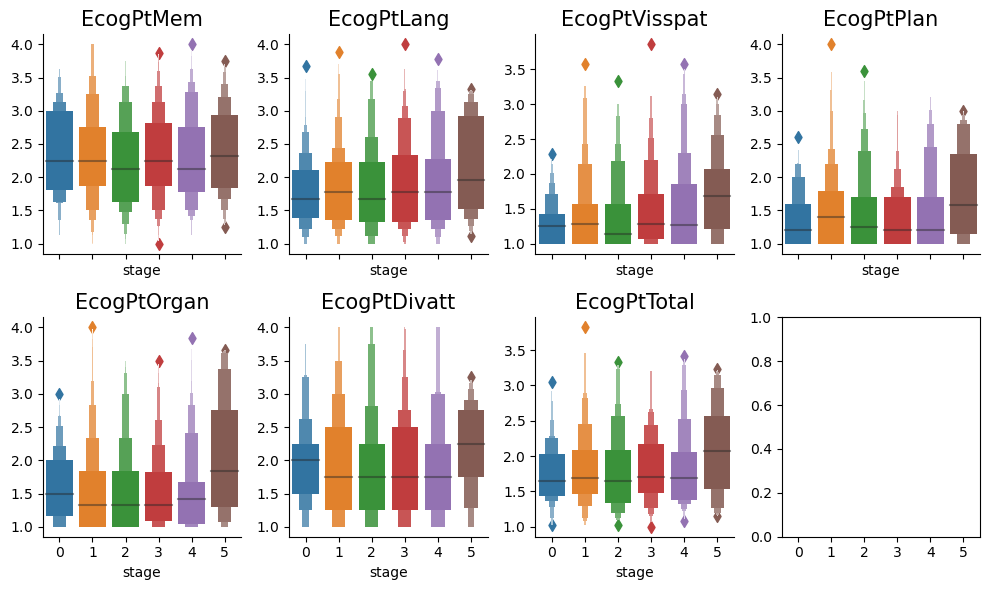

In [67]:
flds = ["EcogPtMem", "EcogPtLang", "EcogPtVisspat", "EcogPtPlan",
        "EcogPtOrgan", "EcogPtDivatt", "EcogPtTotal"]

pairs = [(0,1),(1,2),(2,3),(3,4),(4,5)]
fig, ax = plt.subplots(2,4, sharex=True, sharey=False, figsize=(10,6))
test_name = "EcogPT"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    r = _//4
    c = _%4
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c])
#     annotator = Annotator(ax[r,c], pairs, data=df_mh_fld, x="stage", y=fld)
#     annotator._pvalue_format.pvalue_thresholds =  [[5e-2, '*'], [5e-3, '**'], [5e-4, '***'], [5e-5, '****'], [1, 'ns']]
#     annotator.configure(test='Mann-Whitney', text_format='star', 
#                         loc='inside',comparisons_correction="Benjamini-Hochberg")
#     annotator.apply_and_annotate()
    ax[r,c].set_ylabel("")
    ax[r,c].set_title(fld, fontsize=15)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [68]:
test_name = "EcogPT_summary_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

## CSF markers

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 5.00e-03 < p <= 5.00e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: 5.00e-05 < p <= 5.00e-04
    ****: p <= 5.00e-05

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.866e-02 (ns) U_stat=5.432e+03
1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.495e-01 U_stat=9.107e+03
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.390e-01 U_stat=5.007e+03
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.196e-03 U_stat=6.264e+03
4 vs. 5: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.020e-01 U_stat=1.413e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 5.00e-03 < p <= 5.00e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: 5.00e-05 < p <= 5.00e-04
    ****: p <= 5.00e-05

0 vs. 1: Mann-Whitney-Wilcoxon test 

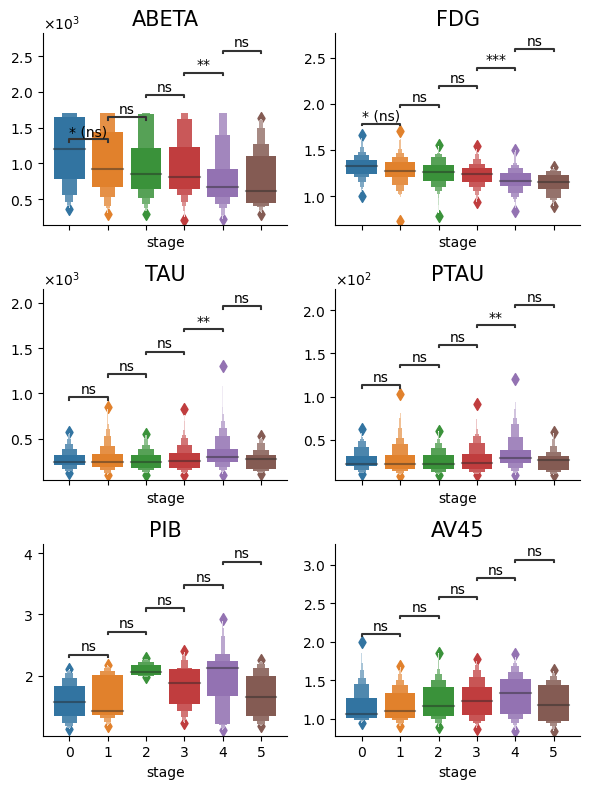

In [69]:
flds = ["ABETA","FDG","TAU","PTAU","PIB","AV45"]
fig, ax = plt.subplots(3,2, sharex=True, sharey=False, figsize=(6,8))
test_name = "CSF_markers_annotation"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    r = _//2
    c = _%2
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c])
    annotator = Annotator(ax[r,c], pairs, data=df_mh_fld, x="stage", y=fld)
    annotator._pvalue_format.pvalue_thresholds =  [[5e-2, '*'], [5e-3, '**'], [5e-4, '***'], [5e-5, '****'], [1, 'ns']]
    annotator.configure(test='Mann-Whitney', text_format='star', 
                        loc='inside',comparisons_correction="Benjamini-Hochberg")
    annotator.apply_and_annotate()
    ax[r,c].set_ylabel("")
    ax[r,c].set_title(fld, fontsize=15)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

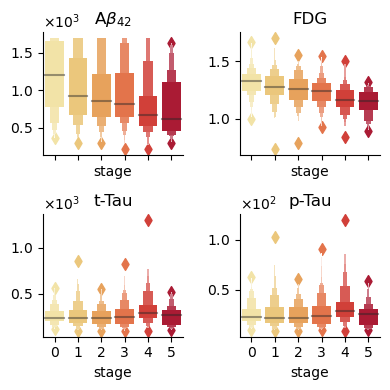

In [70]:
flds = ["ABETA","FDG","TAU","PTAU"]
fld_titles = {"ABETA":r'A$\beta_{42}$', "FDG":"FDG", "PTAU":"p-Tau", "TAU":"t-Tau"}
fig, ax = plt.subplots(2,2, sharex=True, sharey=False, figsize=(4,4))
test_name = "CSF_markers"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    r = _//2
    c = _%2
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c], palette=palette_color1)
    ax[r,c].set_ylabel("")
    ax[r,c].set_title(fld_titles[fld], fontsize=12)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

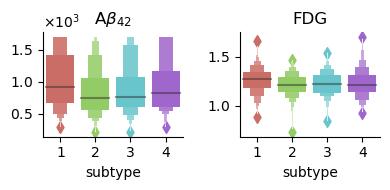

In [71]:
flds = ["ABETA", "FDG"]
fld_titles = {"ABETA":r'A$\beta_{42}$', "FDG":"FDG", "PTAU":"p-Tau", "TAU":"t-Tau"}
fig, ax = plt.subplots(1,2, sharex=True, sharey=False, figsize=(4,2))
test_name = "csf-subtypes"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    df_mh_fld["subtype"] += 1
    df_mh_fld["subtype"] = df_mh_fld["subtype"].astype(int)
    c = _%2
    sns.boxenplot(data=df_mh_fld, y=fld, ax=ax[c], x="subtype",
                  palette=palette_subtype)
    ax[c].set_ylabel("")
    ax[c].set_title(fld_titles[fld], fontsize=12)
    ax[c].spines[['right', 'top']].set_visible(False)
    ax[c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [72]:
# Adjusting FDG levels for age, gender, educat, apoe4 and stage
fld = "ABETA"
df_xx = regress_score(df_long_adnimerge,
                      fld, ["RID","AGE", "PTGENDER", "PTEDUCAT", "APOE4", "stage"])
df_xx.dropna(inplace=True)
df_xx.reset_index(drop=True, inplace=True)
model = sm.OLS(df_xx[[fld]], sm.add_constant(df_xx[["AGE", "PTGENDER", "PTEDUCAT", "APOE4", "stage"]]))
results = model.fit()



In [73]:
df_xx["subtype"] = pd.from_dummies(df_xx[["st0","st1","st2","st3"]])
df_xx["subtype"] = df_xx["subtype"].map({"st0":0,"st1":1,"st2":2,"st3":3})
df_xx["subtype"] += 1

KruskalResult(statistic=6.207306394960824, pvalue=0.10194856581621145)

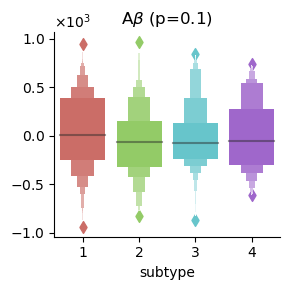

In [74]:
df_xx["resid"] = results.resid
fig, ax = plt.subplots(1,1,figsize=(3,3))
test_name = "abeta-adj-subtypes"
sns.boxenplot(data=df_xx, y="resid", x="subtype", 
              palette=palette_subtype, ax=ax)
ax.set_ylabel("")
ax.set_title(r'A$\beta$ (p=0.1)', fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)
kruskal(*[group["resid"].values for name, group in df_xx.groupby("subtype")])

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 5.00e-03 < p <= 5.00e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: 5.00e-05 < p <= 5.00e-04
    ****: p <= 5.00e-05

1 vs. 2: Kruskal-Wallis independent samples (pairwise between groups) with Benjamini-Hochberg correction, P_val:2.887e-04 Stat=1.314e+01
2 vs. 3: Kruskal-Wallis independent samples (pairwise between groups) with Benjamini-Hochberg correction, P_val:5.357e-01 Stat=3.836e-01
3 vs. 4: Kruskal-Wallis independent samples (pairwise between groups) with Benjamini-Hochberg correction, P_val:3.658e-01 Stat=8.177e-01
2 vs. 4: Kruskal-Wallis independent samples (pairwise between groups) with Benjamini-Hochberg correction, P_val:8.993e-02 Stat=2.876e+00
1 vs. 3: Kruskal-Wallis independent samples (pairwise between groups) with Benjamini-Hochberg correction, P_val:2.004e-02 (ns) Stat=5.408e+00
1 vs. 4: Kruskal-Wallis independent samples (pairwise between groups) with Benjamini-Hochberg correction, P_val:2.279e

KruskalResult(statistic=6.207306394960824, pvalue=0.10194856581621145)

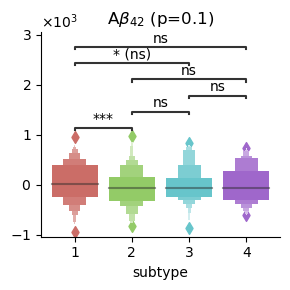

In [75]:
df_xx["resid"] = results.resid
pairs = [(1,2),(2,3),(3,4),(2,4),(1,3),(1,4)]
fig, ax = plt.subplots(1,1,figsize=(3,3))
test_name = "abeta-adj-subtypes-annotat"
sns.boxenplot(data=df_xx, y="resid", x="subtype", 
              palette=palette_subtype, ax=ax)
annotator = Annotator(ax, pairs, data=df_xx, x="subtype", y=fld)
annotator._pvalue_format.pvalue_thresholds =  [[5e-2, '*'], [5e-3, '**'], [5e-4, '***'], [5e-5, '****'], [1, 'ns']]
annotator.configure(test='Kruskal', text_format='star', 
                    loc='inside',comparisons_correction="Benjamini-Hochberg")
annotator.apply_and_annotate()

ax.set_ylabel("")
ax.set_title(r'A$\beta_{42}$ (p=0.1)', fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
# ax.set_ylim([-1,1])
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)
kruskal(*[group["resid"].values for name, group in df_xx.groupby("subtype")])

In [76]:
# Adjusting FDG levels for age, gender, educat, apoe4 and stage
fld = "FDG"
df_xx = regress_score(df_long_adnimerge,
                      fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4", "stage"])
df_xx.dropna(inplace=True)
df_xx.reset_index(drop=True, inplace=True)
model = sm.OLS(df_xx[[fld]], sm.add_constant(df_xx[["AGE", "PTGENDER", "PTEDUCAT", "APOE4", "stage"]]))
results = model.fit()


In [77]:
df_xx["subtype"] = pd.from_dummies(df_xx[["st0","st1","st2","st3"]])
df_xx["subtype"] = df_xx["subtype"].map({"st0":0,"st1":1,"st2":2,"st3":3})
df_xx["subtype"] += 1

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 5.00e-03 < p <= 5.00e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: 5.00e-05 < p <= 5.00e-04
    ****: p <= 5.00e-05

1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.439e-05 U_stat=2.565e+04
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.685e-01 U_stat=6.086e+03
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.633e-01 U_stat=4.203e+03
2 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.787e-01 U_stat=6.299e+03
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.691e-03 U_stat=1.586e+04
1 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.928e-03 U_stat=1.627e+04


KruskalResult(statistic=11.24327046968233, pvalue=0.01048059054539954)

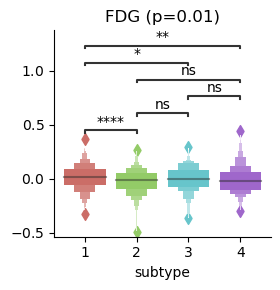

In [78]:
df_xx["resid"] = results.resid
pairs = [(1,2),(2,3),(3,4),(2,4),(1,3),(1,4)]
fig, ax = plt.subplots(1,1,figsize=(3,3))
test_name = "fgd-adj-subtypes-annotat"
sns.boxenplot(data=df_xx, y="resid", x="subtype", 
              palette=palette_subtype, ax=ax)
annotator = Annotator(ax, pairs, data=df_xx, x="subtype", y=fld)
annotator._pvalue_format.pvalue_thresholds =  [[5e-2, '*'], [5e-3, '**'], [5e-4, '***'], [5e-5, '****'], [1, 'ns']]
annotator.configure(test='Mann-Whitney', text_format='star', 
                    loc='inside',comparisons_correction="Benjamini-Hochberg")
annotator.apply_and_annotate()

ax.set_ylabel("")
ax.set_title(r'FDG (p=0.01)', fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
# ax.set_ylim([-1,1])
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)
kruskal(*[group["resid"].values for name, group in df_xx.groupby("subtype")])

In [79]:
ucb_fdg_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/biospecimens/UPENNBIOMK_ROCHE_ELECSYS_17May2024.csv"
ucb_fdg_df = pd.read_csv(ucb_fdg_path)
ucb_fdg_df.replace("sc","bl",inplace=True)
ucb_fdg_df2 = pd.merge(df_long_mci, ucb_fdg_df, left_on=["RID", "VISCODE"], right_on=["RID", "VISCODE2"],
         how="inner", suffixes=[None,"_"])
ucb_fdg_df2.sort_values(by=["RID", "EXAMDATE"], inplace=True)
ucb_fdg_df2.drop_duplicates("RID", inplace=True)


In [80]:
ucb_fdg_df2[["ABETA42","RID"]]

,ABETA42,RID
180,1176.0,4
327,673.0,33
450,874.1,38
54,414.6,41
451,383.3,45
...,...,...
145,635.6,5031
598,1001.0,5047
179,2185.0,5099
277,746.8,5135


In [81]:
xyz = pd.merge(df_xx[["RID","ABETA"]],ucb_fdg_df2[["ABETA42","RID"]],on="RID")
xyz[xyz["ABETA"] != xyz["ABETA42"]]

KeyError: "None of [Index(['RID', 'ABETA'], dtype='object')] are in the [columns]"

In [82]:
fld = "ABETA42"
df_xx = regress_score(ucb_fdg_df2,
                      fld, ["RID","AGE", "PTGENDER", "PTEDUCAT", "APOE4", "stage"])
df_xx.dropna(inplace=True)
df_xx.reset_index(drop=True, inplace=True)
model = sm.OLS(df_xx[[fld]], sm.add_constant(df_xx[["AGE", "PTGENDER", "PTEDUCAT", "APOE4", "stage"]]))
results = model.fit()

In [83]:
df_xx["subtype"] = pd.from_dummies(df_xx[["st0","st1","st2","st3"]])
df_xx["subtype"] = df_xx["subtype"].map({"st0":0,"st1":1,"st2":2,"st3":3})
df_xx["subtype"] += 1

In [84]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                ABETA42   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     40.39
Date:                Sun, 16 Jun 2024   Prob (F-statistic):           2.26e-35
Time:                        14:13:11   Log-Likelihood:                -4202.2
No. Observations:                 554   AIC:                             8416.
Df Residuals:                     548   BIC:                             8442.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2288.0399    252.367      9.066      0.0

KruskalResult(statistic=5.221362394641574, pvalue=0.1562872299020428)

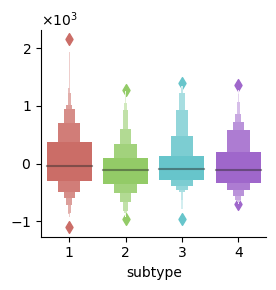

In [85]:
df_xx["resid"] = results.resid
fig, ax = plt.subplots(1,1,figsize=(3,3))
test_name = "abeta-upenn-adj-subtypes"
sns.boxenplot(data=df_xx, y="resid", x="subtype", 
              palette=palette_subtype, ax=ax)
ax.set_ylabel("")
# ax.set_title(r'F (p=0.01)', fontsize=12)
ax.spines[['right', 'top']].set_visible(False)
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
# ax.set_ylim([-.3,.3])
fig.tight_layout()
# fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)
kruskal(*[group["resid"].values for name, group in df_xx.groupby("subtype")])

In [86]:
# UC Berkely  (FDG data)

In [87]:
ucb_fdg_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/biospecimens/UCBERKELEYFDG_03_25_22_17May2024.csv"
ucb_fdg_df = pd.read_csv(ucb_fdg_path)
ucb_fdg_df.replace("sc","bl",inplace=True)
ucb_fdg_df2 = pd.merge(df_long_mci, ucb_fdg_df, left_on=["RID", "VISCODE"], right_on=["RID", "VISCODE2"],
         how="inner", suffixes=[None,"_"])
ucb_fdg_df2.sort_values(by=["RID", "EXAMDATE"], inplace=True)
ucb_fdg_df2_meta = ucb_fdg_df2[ucb_fdg_df2["ROINAME"]=="metaroi"]
ucb_fdg_df2_pons = ucb_fdg_df2[ucb_fdg_df2["ROINAME"]=="pons-vermis"]

In [88]:
ucb_fdg_df2_meta.drop_duplicates("RID", inplace=True)
ucb_fdg_df2_pons.drop_duplicates("RID", inplace=True)


In [89]:
ucb_fdg_df2_pons.shape

(618, 144)

# ANOVA for studying effects from stages and subtypes

In [90]:
from statsmodels.formula.api import ols
# model_anova = ols('resid ~ C(stage) + C(subtype) + C(stage):C(subtype)', data=df_xx).fit()
model_anova = ols('resid ~ C(stage) + C(subtype)', data=df_xx).fit()

In [91]:
sm.stats.anova_lm(model_anova, typ=2)

,sum_sq,df,F,PR(>F)
C(stage),5.483008e+04,5.0,0.048155,0.998603
C(subtype),1.136333e+06,3.0,1.663310,0.173876
Residual,1.241102e+08,545.0,NaN,NaN


In [92]:
test_name = "CSF_test"
groupby_var = "stage"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = process_df(df_long_adnimerge, fld)
    n_samples = df_mh_fld.shape[0]
    print("Shape", fld, df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby([groupby_var, fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    spearmanr_obj = spearmanr(df_mh_fld["stage"], df_mh_fld[fld])
    spearman_corr = spearmanr_obj.correlation
    spearman_pval = spearmanr_obj.pvalue
    
    neurobat_dict[fld] = [chi2_pval, spearman_corr, spearman_pval, n_samples]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", 
                                     columns = ["chi-2-pval", "spearmanr", "spearmanp", "n_samples"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))

Shape ABETA (551, 244)
Shape FDG (618, 244)


In [93]:
test_name = "CSF_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# Brain region volumes

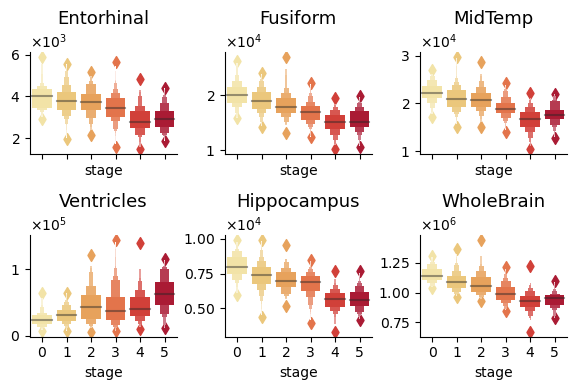

In [176]:
test_name = "Vol_test"
flds =  ["Entorhinal", "Fusiform", "MidTemp", "Ventricles", "Hippocampus", "WholeBrain"]
fig, ax = plt.subplots(2,3, sharex=True, sharey=False, figsize=(6,4))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
    r = _//3
    c = _%3
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c], 
                  palette=palette_color1)
    ax[r,c].set_ylabel("")
    ax[r,c].set_title(fld, fontsize=13)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
# fig.supylabel("Volume", fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [177]:
test_name = "vol_test_bar"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

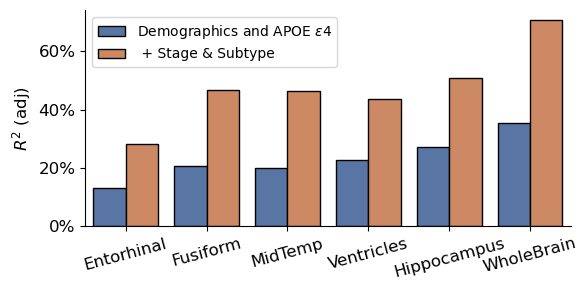

In [178]:
stats_df_all["r-sq-adj"] *= 100
fig, ax = plt.subplots(1,1,figsize=(6,3))
sns.barplot(data=stats_df_all, x="fld", y="r-sq-adj", hue="n-cov", 
            hue_order = ["excl-sustain", "incl-sustain"], ax=ax,
           palette="deep", edgecolor='k', 
            order=["Entorhinal", "Fusiform", "MidTemp", "Ventricles", "Hippocampus", "WholeBrain"])
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12,rotation=15)
ax.set_ylabel(r'$R^{2}$ (adj)', fontsize=12)
ax.set_xlabel("")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
leg = ax.get_legend()
leg.set_title("")
new_labels = [r'Demographics and APOE $\varepsilon$4', ' + Stage & Subtype']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

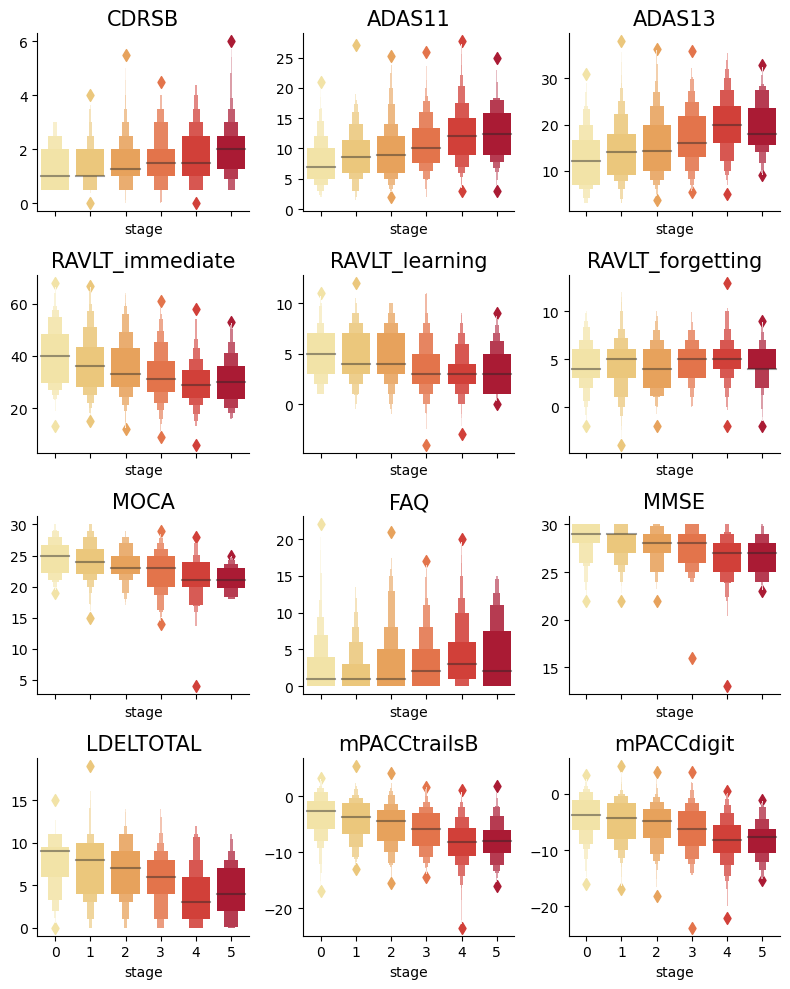

In [179]:
test_name = "adnimerge_cog"
flds = ["CDRSB", "ADAS11", "ADAS13"] + ["RAVLT_immediate","RAVLT_learning",
        "RAVLT_forgetting"] + ["MOCA", "FAQ","MMSE"] + ["LDELTOTAL", "mPACCtrailsB", "mPACCdigit"]
fig, ax = plt.subplots(4,3, sharex=True, sharey=False, figsize=(8,10))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_long_adnimerge, fld)
#     if fld in ["RAVLT_forgetting"]:
#         df_mh_fld = df_mh_fld[fld]
    r = _//3
    c = _%3
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c],
                 palette=palette_color1)
    ax[r,c].set_ylabel("")
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
# fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [180]:
test_name = "adnimerge_cog_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_long_adnimerge, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

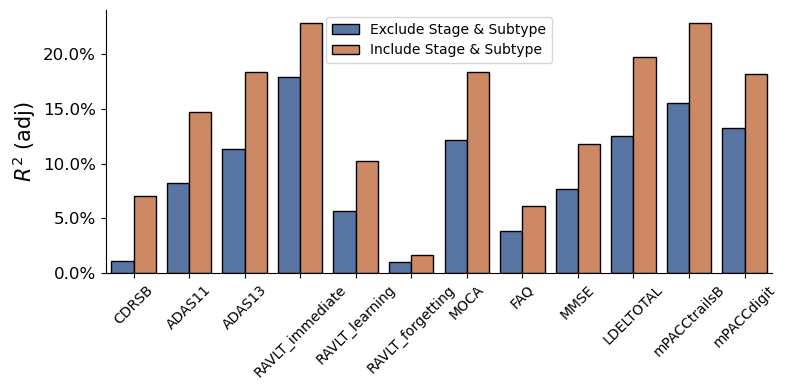

In [181]:
stats_df_all["r-sq-adj"] *= 100
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.barplot(data=stats_df_all, x="fld", y="r-sq-adj", hue="n-cov", 
            hue_order = ["excl-sustain", "incl-sustain"], ax=ax,
           palette="deep", edgecolor='k')
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=10,rotation=45)
ax.set_ylabel(r'$R^{2}$ (adj)', fontsize=15)
ax.set_xlabel("")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
leg = ax.get_legend()
leg.set_title("")
new_labels = ['Exclude Stage & Subtype', 'Include Stage & Subtype']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}_bar.png".format(test_name)), dpi=300)

# Relations between subtypes and Ethnicity, Race, Marry etc

In [182]:
# PTGENDER, #PTMARRY
fld = "PTMARRY"
df_mh_fld = process_df(df_long_all_adnimerge, fld,"first")
chi2_table = df_mh_fld.groupby(["subtype", fld]).size().unstack(level=1).fillna(0)
chi2_contingency(chi2_table)

(36.31349753190681,
 0.00028845427273704383,
 12,
 array([[ 68.13630881, 599.40892642,  29.06513872,   2.8588661 ,
          90.53075995],
        [ 29.23823884, 257.21471653,  12.47225573,   1.22677925,
          38.84800965],
        [ 22.94209891, 201.82629674,   9.78648975,   0.96260555,
          30.48250905],
        [ 22.68335344, 199.55006031,   9.6761158 ,   0.9517491 ,
          30.13872135]]))

In [183]:
chi2_table

PTMARRY,Divorced,Married,Never married,Unknown,Widowed
subtype,,,,,
0.0,89.0,562.0,25.0,3.0,111.0
1.0,18.0,283.0,12.0,2.0,24.0
2.0,13.0,208.0,11.0,1.0,33.0
3.0,23.0,205.0,13.0,0.0,22.0


In [184]:
chi2_table.sum().sum()

1658.0

In [185]:
df_mh_fld

,3rd-Ventricle,4th-Ventricle,Brain-Stem,CC_Anterior,CC_Central,CC_Mid_Anterior,CC_Mid_Posterior,CC_Posterior,CSF,CortexVol,...,TAU_bl,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2016,1594,21966,718,330,334,341,747,1744,428237.8199,...,355.2,34.73,NaN,NaN,NaN,0.000000,0.00000,0,0,2019-02-14 23:58:29.0
2,2274,1717,20363,743,352,361,309,844,1537,454812.9567,...,107.3,10.57,NaN,NaN,NaN,1.065020,12.75410,12,12,2019-02-14 23:58:30.0
5,2942,3382,24986,885,356,387,338,976,1260,416770.2777,...,188.6,15.82,NaN,NaN,NaN,0.000000,0.00000,0,0,2019-02-14 23:58:31.0
6,5319,3291,20851,641,222,209,223,732,3518,442137.1497,...,212.4,18.56,NaN,NaN,NaN,0.481862,5.77049,6,6,2019-02-14 23:58:31.0
7,3394,1751,19979,738,319,320,295,811,1423,361653.4100,...,265.9,22.82,NaN,NaN,NaN,3.986310,47.73770,48,48,2019-02-14 23:58:32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2441,1789,2143,21078,623,388,324,268,915,1281,362288.1733,...,277,23.97,1.33321,NaN,0.933541,0.000000,0.00000,0,0,2019-02-14 23:58:40.0
5398,1048,1313,16963,624,350,313,346,848,1313,371425.3641,...,312.6,26.47,1.49934,NaN,1.126160,0.000000,0.00000,0,0,2019-02-14 23:58:40.0
5402,1171,1675,19683,766,396,437,387,982,1587,422901.8755,...,339.4,32.22,1.25884,NaN,1.361980,0.000000,0.00000,0,0,2019-02-14 23:58:41.0
5406,3234,3131,20749,476,273,197,202,755,2035,385137.6643,...,295.5,27.57,1.36562,NaN,1.221260,0.000000,0.00000,0,0,2019-02-14 23:58:43.0


In [186]:
df_mh_fld["APOE4"]

0       1.0
2       0.0
5       1.0
6       2.0
7       0.0
       ... 
2441    0.0
5398    1.0
5402    0.0
5406    0.0
2445    0.0
Name: APOE4, Length: 1658, dtype: float64

# Demographics (Age, gender, education APOE4)

In [187]:
df_mci_demo = pd.merge(mci_solved, df_mci[["PTID", "APOE4", "PTGENDER", "PTEDUCAT", "AGE"]], left_on="PTID", right_on="PTID", how="inner")
df_cnad_demo = pd.merge(cnad_solved, df_cnad[["PTID", "APOE4", "PTGENDER", "PTEDUCAT", "AGE"]], left_on="PTID", right_on="PTID", how="inner")
df_demo = pd.concat([df_cnad_demo, df_mci_demo], axis=0)         

In [188]:
df_demo

,subtype,stage,DX,PTID,EXAMDATE,VISCODE,APOE4,PTGENDER,PTEDUCAT,AGE
0,3.0,2.0,0.0,002_S_0295,2006-05-09,bl,1.0,Male,18,84.8
1,3.0,1.0,0.0,002_S_0413,2007-06-01,m12,0.0,Female,16,76.3
2,1.0,2.0,0.0,002_S_0559,2006-06-20,bl,1.0,Male,16,79.3
3,1.0,3.0,1.0,002_S_0619,2006-12-13,m06,2.0,Male,12,77.5
4,2.0,4.0,0.0,002_S_0685,2010-07-15,m48,0.0,Female,16,89.6
...,...,...,...,...,...,...,...,...,...,...
803,1.0,3.0,2.0,941_S_4100,2015-08-28,m48,0.0,Female,12,78.5
804,0.0,0.0,2.0,941_S_4187,2011-08-25,bl,0.0,Male,16,62.0
805,0.0,3.0,2.0,941_S_4377,2012-02-14,bl,1.0,Female,12,69.3
806,0.0,0.0,2.0,941_S_4420,2012-04-03,bl,0.0,Male,18,81.4


In [189]:
df_demo.groupby(["subtype", "APOE4"]).size().unstack(level=1) 

APOE4,0.0,1.0,2.0
subtype,,,
0.0,412,296,79
1.0,178,127,34
2.0,134,100,31
3.0,153,86,23


# APOE4 allele frequency

In [190]:
np.dot(df_demo.groupby(["subtype", "APOE4"]).size().unstack(level=1), [0,1,2])/(2*df_demo.groupby(["subtype", "APOE4"]).size().unstack(level=1).sum(axis=1))

subtype
0.0    0.288437
1.0    0.287611
2.0    0.305660
3.0    0.251908
dtype: float64

In [194]:
chi2_table = df_demo.groupby(["subtype", "APOE4"]).size().unstack(level=1).fillna(0)
chi2_contingency(chi2_table)

(4.305921198723712,
 0.6353521250252376,
 6,
 array([[417.54325469, 289.94736842,  79.50937689],
        [179.85662432, 124.89473684,  34.24863884],
        [140.59588627,  97.63157895,  26.77253479],
        [139.00423472,  96.52631579,  26.46944949]]))

## Education and Age

In [195]:
[(name, group["AGE"].std()) for name, group in df_demo.groupby("subtype")]

[(0.0, 7.476022523517161),
 (1.0, 6.7426275519493215),
 (2.0, 6.459481358310217),
 (3.0, 6.360755019918423)]

In [196]:
kruskal(*[group["AGE"].values for name, group in df_demo.groupby("subtype")])

KruskalResult(statistic=59.97480286714624, pvalue=5.951546139798225e-13)

<AxesSubplot: xlabel='subtype', ylabel='PTEDUCAT'>

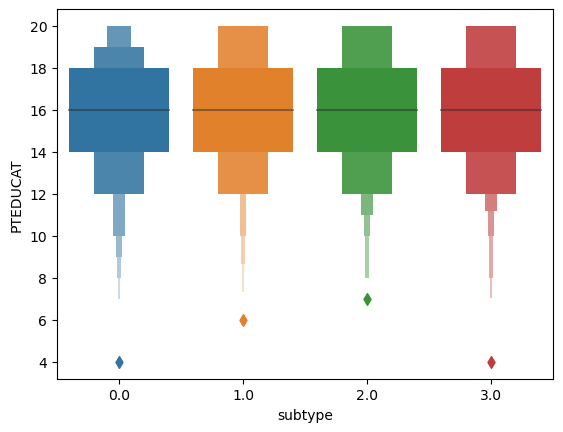

In [197]:
sns.boxenplot(data=df_demo, x="subtype",y="PTEDUCAT")

In [198]:
df_st0 = df_demo[df_demo["subtype"]==0]
df_st1 = df_demo[df_demo["subtype"]==1]
df_st2 = df_demo[df_demo["subtype"]==2]
df_st3 = df_demo[df_demo["subtype"]==3]

In [199]:
demo_x = "PTEDUCAT"
kruskal(df_st0[demo_x], df_st1[demo_x], df_st2[demo_x],df_st3[demo_x])

KruskalResult(statistic=9.452171974354897, pvalue=0.023845651683498812)

# Prepare data for StatsModel

In [200]:
def regress_score(df, field, covariates, examdate="EXAMDATE", n_subtypes=4):
    subtypes = list(range(n_subtypes))
    df_fld = df.dropna(subset=[field])
    df_fld.sort_values(["sid", examdate], inplace=True)
    df_fld.drop_duplicates("sid", keep="first", inplace=True)
    one_hot_cols = pd.get_dummies(df_fld["subtype"])
    one_hot_cols = one_hot_cols[subtypes]
    new_cols = ["st{}".format(_) for _ in subtypes]
    one_hot_cols.columns = new_cols
    df_one_hot = pd.concat([df_fld[covariates+[field]], one_hot_cols], axis=1)
    return df_one_hot

def process_df(df, fld, examdate="EXAMDATE"):
    df_fld = df.dropna(subset=[fld])
    df_fld.sort_values(["sid", examdate], inplace=True)
    df_fld.drop_duplicates("sid", keep="first", inplace=True)
    return df_fld

def regress_OLS(df, fld, cov):
    model = sm.OLS(df[[fld]], sm.add_constant(df[cov]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params, results.bse, results.conf_int()],axis=1)
    stats_df.columns = ["p-vals", "coef","std-err","conf-int-lower95", "conf-int-upper95"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    stats_df["f-pvalue"] = results.f_pvalue
    return stats_df

def regress_Logit(df, fld, cov):
    model = sm.Logit(df[[fld]], sm.add_constant(df[cov]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params, results.bse, results.conf_int()],axis=1)
    stats_df.columns = ["p-vals", "coef","std-err","conf-int-lower95", "conf-int-upper95"]
    stats_df["fld"] = fld
    stats_df["psuedo-r-sq"] = results.prsquared
    stats_df["llr_pvalue"] = results.llr_pvalue
    return stats_df

# Process data for filtering operations

## OLS regression function

In [201]:
def regress_OLS(df, fld, cov):
    model = sm.OLS(df[[fld]], sm.add_constant(df[cov]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params, results.bse, results.conf_int()],axis=1)
    stats_df.columns = ["p-vals", "coef","std-err","conf-int-lower95", "conf-int-upper95"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    stats_df["f-pvalue"] = results.f_pvalue
    return stats_df

## Logistic regression function

In [94]:
def regress_Logit(df, fld, cov):
    model = sm.Logit(df[[fld]], sm.add_constant(df[cov]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params, results.bse, results.conf_int()],axis=1)
    stats_df.columns = ["p-vals", "coef","std-err","conf-int-lower95", "conf-int-upper95"]
    stats_df["fld"] = fld
    stats_df["psuedo-r-sq"] = results.prsquared
    stats_df["llr_pvalue"] = results.llr_pvalue
    return stats_df

# NeuroBAT

In [95]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "NEUROBAT_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["sid", "VISCODE"], 
         right_on=["PTID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

# Trail Tests

### Regression Models

In [204]:
flds = ["TRAASCOR","TRAAERRCOM","TRAAERROM","TRABSCOR","TRABERRCOM","TRABERROM"]
test_name = "trail_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [205]:
flds = ["TRAASCOR","TRAAERRCOM","TRAAERROM","TRABSCOR","TRABERRCOM","TRABERROM"]
test_name = "trail_test"
groupby_var = "stage"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = process_df(df_mh, fld)
    n_samples = df_mh_fld.shape[0]
    print("Shape", fld, df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby([groupby_var, fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr, n_samples]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", 
                                     columns = ["chi-2-pval", "spearmanr", "n_samples"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))

Shape TRAASCOR (808, 96)
Shape TRAAERRCOM (808, 96)
Shape TRAAERROM (808, 96)
Shape TRABSCOR (806, 96)
Shape TRABERRCOM (804, 96)
Shape TRABERROM (804, 96)


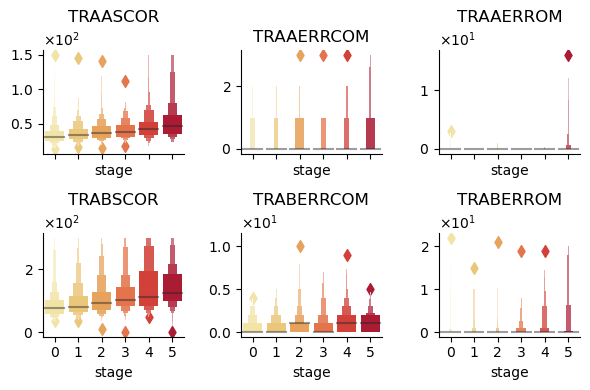

In [206]:
nrows=2
ncols=3
fig, ax = plt.subplots(nrows,ncols, sharex=True, sharey=False, figsize=(6,4))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//ncols
    c = _%ncols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c], 
                  palette=palette_color1)
    ax[r, c].set_ylabel("")
    ax[r, c].set_title(fld, fontsize=12)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

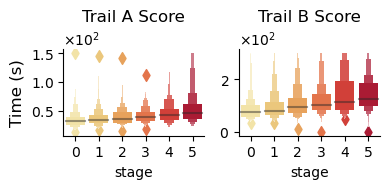

In [207]:
flds = ["TRAASCOR","TRABSCOR"]
fld_title = {"TRAASCOR":"Trail A Score", "TRABSCOR":"Trail B Score"}
test_name = "trail_A_B_test"
nrows=1
ncols=2
fig, ax = plt.subplots(nrows,ncols, sharex=True, sharey=False, figsize=(4,2))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    c = _%ncols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[c], 
                  palette=palette_color1)
    ax[c].set_ylabel("")
    ax[c].set_title(fld_title[fld], fontsize=12)
    ax[c].spines[['right', 'top']].set_visible(False)
    ax[c].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
ax[0].set_ylabel("Time (s)", fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

### RAVLT

In [96]:
flds = ["AVTOT1","AVTOT2","AVTOT3","AVTOT4","AVTOT5","AVTOT6","AVTOTB",
        "AVERR1","AVERR2","AVERR3","AVERR4","AVERR5","AVERR6","AVERRB"]
test_name = "RAVLT_test"
groupby_var = "stage"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    n_samples = df_mh_fld.shape[0]
    print("Shape", fld, df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby([groupby_var, fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr, n_samples]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr", "n_samples"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))

Shape AVTOT1 (808, 96)
Shape AVTOT2 (808, 96)
Shape AVTOT3 (808, 96)
Shape AVTOT4 (808, 96)
Shape AVTOT5 (808, 96)
Shape AVTOT6 (808, 96)
Shape AVTOTB (808, 96)
Shape AVERR1 (808, 96)
Shape AVERR2 (808, 96)
Shape AVERR3 (808, 96)
Shape AVERR4 (808, 96)
Shape AVERR5 (808, 96)
Shape AVERR6 (808, 96)
Shape AVERRB (808, 96)


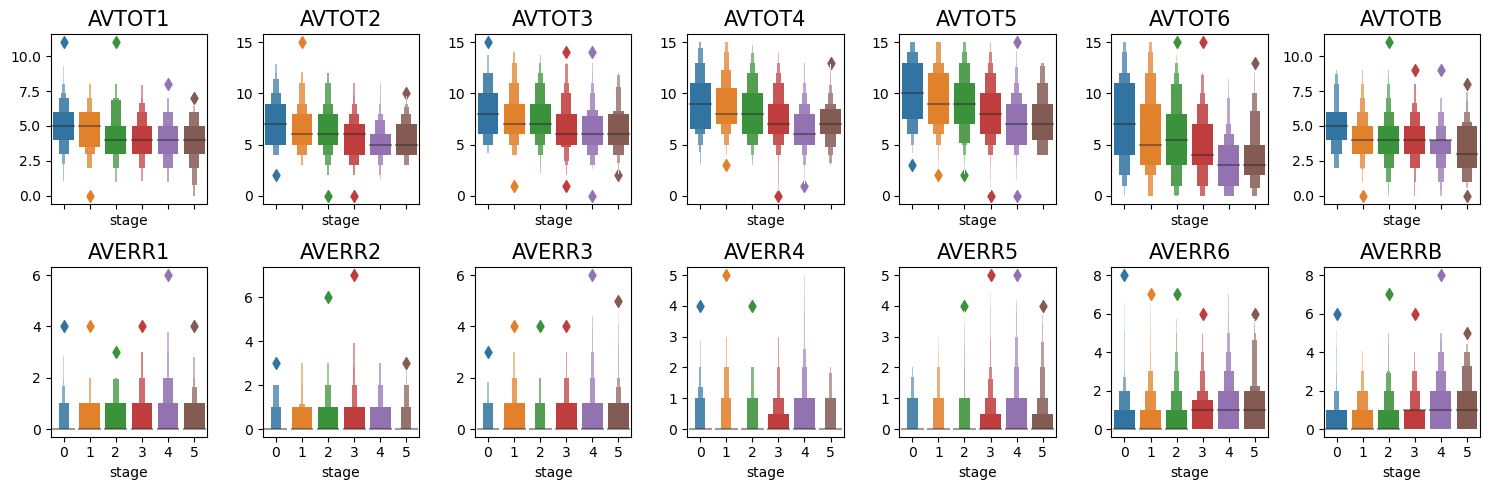

In [97]:
rows = 2; cols=7;
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(15,5))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c])
    ax[r, c].set_ylabel("")
    ax[r, c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

### Regression

In [98]:
flds = ["AVTOT1","AVTOT2","AVTOT3","AVTOT4","AVTOT5","AVTOT6","AVTOTB",
        "AVERR1","AVERR2","AVERR3","AVERR4","AVERR5","AVERR6","AVERRB"]
test_name = "RAVLT_test"
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    model = sm.OLS(df_xx[[fld]], 
                   sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params],axis=1)
    stats_df.columns = ["p-vals", "coef"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    stats_df_list.append(stats_df)
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [99]:
flds = ["AVTOT1","AVTOT2","AVTOT3","AVTOT4","AVTOT5","AVTOT6","AVTOTB",
        "AVERR1","AVERR2","AVERR3","AVERR4","AVERR5","AVERR6","AVERRB"]
test_name = "RAVLT_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

### RAVLT delayed

In [100]:
flds = ["AVDEL30MIN", "AVDELERR1", "AVDELTOT", "AVDELERR2"]
test_name = "RAVLT_delayed"
groupby_var = "stage"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    n_samples = df_mh_fld.shape[0]
    print("Shape", fld, df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby([groupby_var, fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr, n_samples]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr", "n_samples"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))

Shape AVDEL30MIN (808, 96)
Shape AVDELERR1 (808, 96)
Shape AVDELTOT (808, 96)
Shape AVDELERR2 (808, 96)


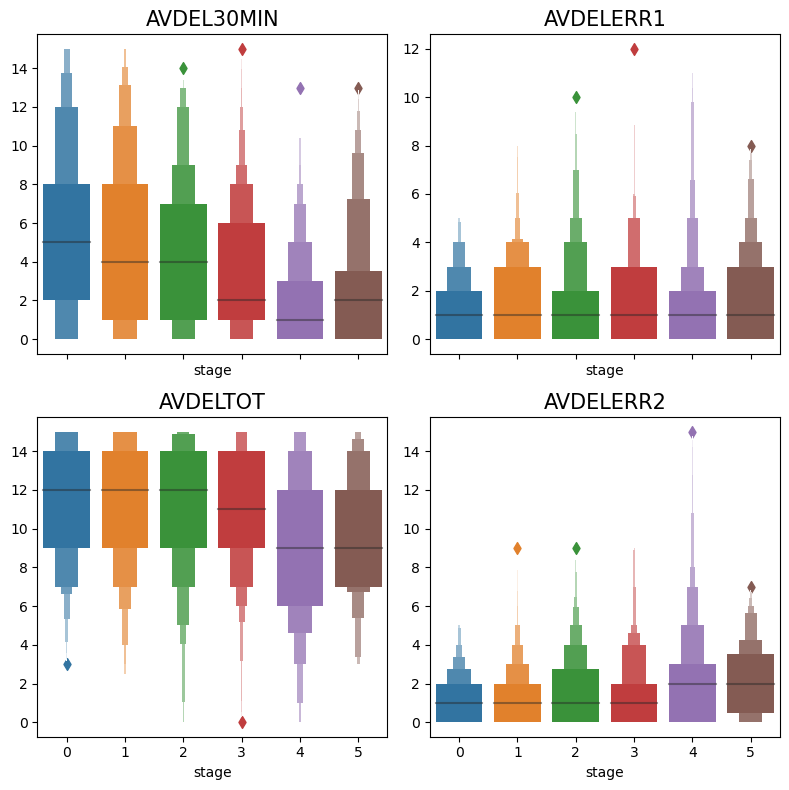

In [101]:
rows = 2; cols=2;
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(8,8))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c])
    ax[r, c].set_ylabel("")
    ax[r, c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

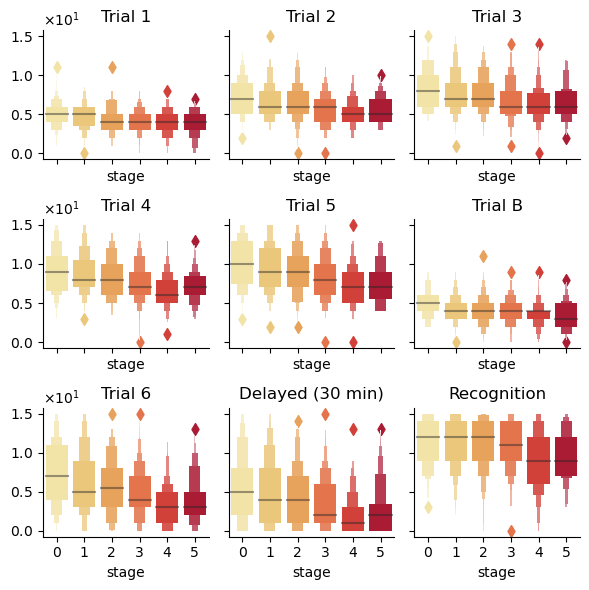

In [102]:
flds = ["AVTOT1","AVTOT2","AVTOT3","AVTOT4","AVTOT5","AVTOTB", "AVTOT6", "AVDEL30MIN", "AVDELTOT"]
flds_title = {"AVTOT1":"Trial 1", "AVTOT2":"Trial 2", "AVTOT3":"Trial 3",
             "AVTOT4":"Trial 4", "AVTOT5":"Trial 5", "AVTOTB":"Trial B",
             "AVTOT6":"Trial 6", "AVDEL30MIN":"Delayed (30 min)", "AVDELTOT":"Recognition"}
rows = 3; cols=3;
test_name = "RAVLT_delayed_final"
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=True, figsize=(6,6))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c], palette=palette_color1)
    ax[r, c].set_ylabel("")
    ax[r, c].set_title(flds_title[fld], fontsize=12)
    ax[r, c].spines[['right', 'top']].set_visible(False)
    ax[r, c].ticklabel_format(style='scientific', axis='y', 
                              scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

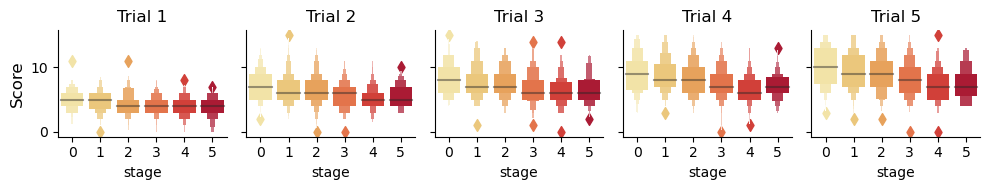

In [111]:
flds = ["AVTOT1","AVTOT2","AVTOT3","AVTOT4","AVTOT5"]
flds_title = {"AVTOT1":"Trial 1", "AVTOT2":"Trial 2", "AVTOT3":"Trial 3",
             "AVTOT4":"Trial 4", "AVTOT5":"Trial 5", "AVTOTB":"Trial B",
             "AVTOT6":"Trial 6", "AVDEL30MIN":"Delayed (30 min)", "AVDELTOT":"Recognition"}
rows = 1; cols=5;
test_name = "RAVLT_trials_1_5"
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=True, figsize=(10,2))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[c], palette=palette_color1)
    ax[c].set_ylabel("")
    ax[c].set_title(flds_title[fld], fontsize=12)
    ax[c].spines[['right', 'top']].set_visible(False)
#     ax[c].ticklabel_format(style='scientific', axis='y', 
#                               scilimits=(0,0), useMathText=True)
ax[0].set_ylabel("Score", fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

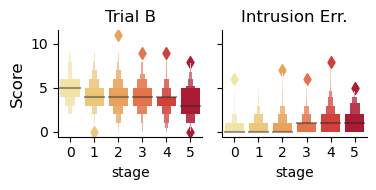

In [114]:
flds = ["AVTOTB","AVERRB"]
flds_title = {"AVTOTB":"Trial B","AVERRB":"Intrusion Err."}
rows = 1; cols=2;
test_name = "RAVLT_trials_B"
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=True, figsize=(4,2))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[c], palette=palette_color1)
    ax[c].set_ylabel("")
    ax[c].set_title(flds_title[fld], fontsize=12)
    ax[c].spines[['right', 'top']].set_visible(False)
#     ax[c].ticklabel_format(style='scientific', axis='y', 
#                               scilimits=(0,0), useMathText=True)
ax[0].set_ylabel("Score", fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

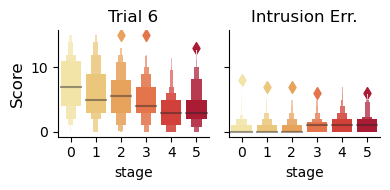

In [116]:
flds = ["AVTOT6","AVERR6"]
flds_title = {"AVTOT6":"Trial 6","AVERR6":"Intrusion Err."}
rows = 1; cols=2;
test_name = "RAVLT_trials_6"
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=True, figsize=(4,2))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[c], palette=palette_color1)
    ax[c].set_ylabel("")
    ax[c].set_title(flds_title[fld], fontsize=12)
    ax[c].spines[['right', 'top']].set_visible(False)
#     ax[c].ticklabel_format(style='scientific', axis='y', 
#                               scilimits=(0,0), useMathText=True)
ax[0].set_ylabel("Score", fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [ ]:
flds = ["AVDEL30MIN","AVERRB"]
flds_title = {"AVDEL30MIN":"Delayed (30 min)","AVERRB":"Intrusion Err."}
rows = 1; cols=2;
test_name = "RAVLT_trials_B"
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=True, figsize=(4,2))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[c], palette=palette_color1)
    ax[c].set_ylabel("")
    ax[c].set_title(flds_title[fld], fontsize=12)
    ax[c].spines[['right', 'top']].set_visible(False)
#     ax[c].ticklabel_format(style='scientific', axis='y', 
#                               scilimits=(0,0), useMathText=True)
ax[0].set_ylabel("Score", fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

### Regression

In [215]:
flds = ["AVTOT1","AVTOT2","AVTOT3","AVTOT4","AVTOT5","AVTOT6","AVTOTB",
        "AVERR1","AVERR2","AVERR3","AVERR4","AVERR5","AVERR6","AVERRB"] + ["AVDEL30MIN", "AVDELERR1", "AVDELTOT", "AVDELERR2"]
test_name = "RAVLT_delayed"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# CLOCK tests

In [361]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "NEUROBAT_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["sid", "VISCODE"], 
         right_on=["PTID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [362]:
flds = ["CLOCKCIRC","CLOCKSYM","CLOCKNUM","CLOCKHAND","CLOCKTIME",
        "COPYCIRC","COPYSYM","COPYNUM","COPYHAND","COPYTIME","LDELCUE"]
test_name = "clock_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_Logit(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_Logit(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

Optimization terminated successfully.
         Current function value: 0.084381
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.086684
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.504765
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371636
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373947
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.124069
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.130925
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.572477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587981
  

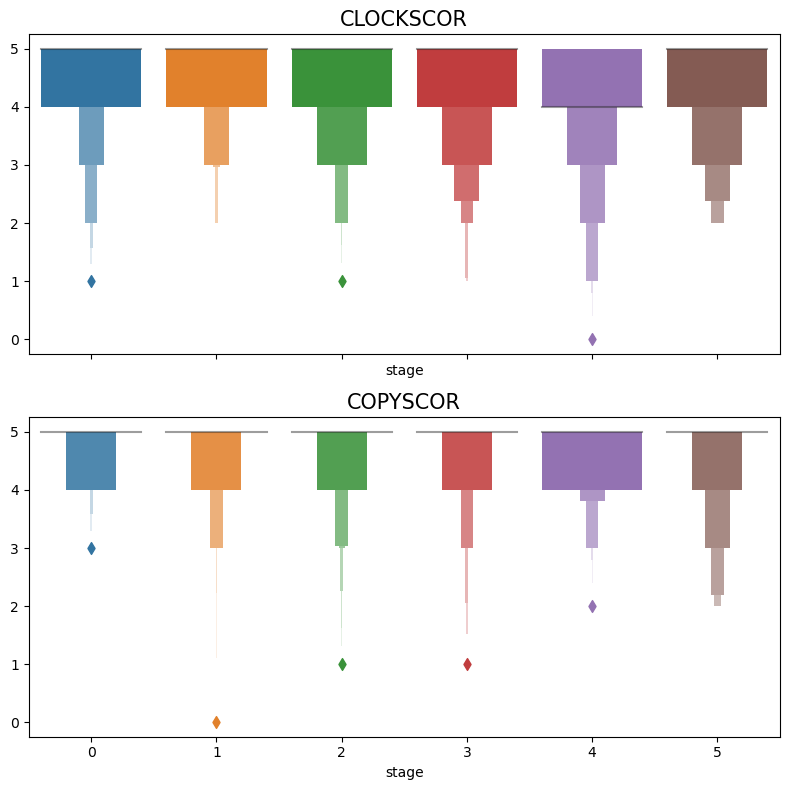

In [363]:
flds = ["CLOCKSCOR", "COPYSCOR"]
test_name = "clock_test"
rows = 2; cols=1;
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(8,8))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[_])
    ax[_].set_ylabel("")
    ax[_].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

# Line plots to show odds of failing a clock test as a fn of stage

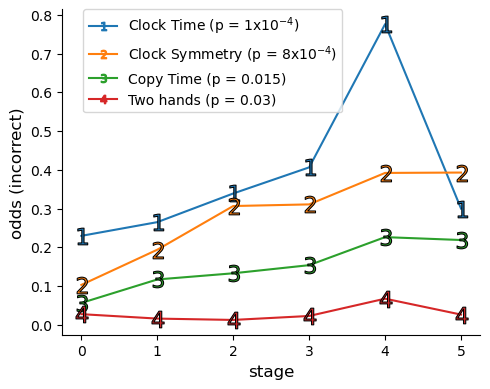

In [364]:
# flds = ["CLOCKCIRC","CLOCKSYM","CLOCKNUM","CLOCKHAND","CLOCKTIME"]
# flds = ["COPYCIRC","COPYSYM","COPYNUM","COPYHAND","COPYTIME"]
flds = ["CLOCKTIME", "CLOCKSYM", "COPYTIME","CLOCKHAND"]
binary = flds
test_name = "clock_ratio_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
fig, ax = plt.subplots(1,1,figsize=(5,4))
markers = ['${}$'.format(_+1) for _ in range(len(binary))]
sns.lineplot(data=ratio_df, ax = ax, dashes=False, markers=markers, markersize=12, mec="k")

plt.legend(bbox_to_anchor=(0.05, 1.00), loc='upper left', borderaxespad=0, ncol=1)
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel('odds (incorrect)', fontsize=12)
ax.set_xlabel('stage', fontsize=12)
leg = ax.get_legend()

flds_text = {"CLOCKTIME":r'Clock Time (p = 1x$10^{-4}$)',
             "CLOCKSYM":r'Clock Symmetry (p = 8x$10^{-4}$)',
            "COPYTIME":r'Copy Time (p = 0.015)',
             "CLOCKHAND":r'Two hands (p = 0.03)'}
for t, l in zip(leg.texts, flds):
    t.set_text(flds_text[l])

fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)


# Neurobat others

### Logical Memory

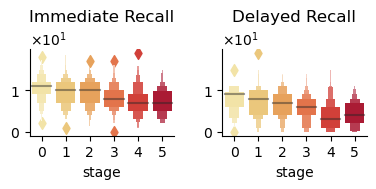

In [365]:
flds = ["LIMMTOTAL", "LDELTOTAL"]
fld_title = {"LIMMTOTAL":"Immediate Recall","LDELTOTAL":"Delayed Recall"}
rows = 1; cols=2;
test_name = "logical_memory"
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(4,2))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[_],
                palette=palette_color1)
    ax[_].set_ylabel("")
    ax[_].set_title(fld, fontsize=12)
    ax[_].spines[['right', 'top']].set_visible(False)
    ax[_].ticklabel_format(style='scientific', axis='y', 
                              scilimits=(0,0), useMathText=True)
    ax[_].set_title(fld_title[fld],fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

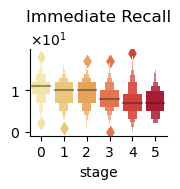

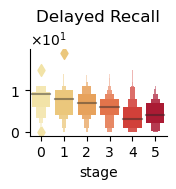

In [368]:
flds = ["LIMMTOTAL", "LDELTOTAL"]
fld_title = {"LIMMTOTAL":"Immediate Recall","LDELTOTAL":"Delayed Recall"}
rows = 1; cols=1;
test_name = "logical_memory"
for _,fld in enumerate(flds):
    fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(2,2))
    df_mh_fld = process_df(df_mh, fld)
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax,
                palette=palette_color1)
    ax.set_ylabel("")
    ax.set_title(fld, fontsize=12)
    ax.spines[['right', 'top']].set_visible(False)
    ax.ticklabel_format(style='scientific', axis='y', 
                              scilimits=(0,0), useMathText=True)
    ax.set_title(fld_title[fld],fontsize=12)
    fig.tight_layout()
    fig.savefig(os.path.join(dir_path, "{}.png".format(fld)), dpi=300)

# LDELCUE

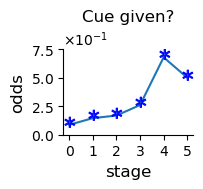

In [396]:
flds = ["LDELCUE"]
# flds = ["COPYCIRC","COPYSYM","COPYNUM","COPYHAND","COPYTIME"]
binary = flds
test_name = "LDELCUE_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[1]/chi2_table[0]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
fig, ax = plt.subplots(1,1,figsize=(2,2))
markers = ['${}$'.format("*") for _ in range(len(binary))]
sns.lineplot(data=ratio_df, ax = ax, dashes=False, markers=markers, markersize=12,mec="b")

# plt.legend(bbox_to_anchor=(0.05, 1.00), loc='upper left', borderaxespad=0, ncol=1, fontsize=12)
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel('odds', fontsize=12)
ax.set_xlabel('stage', fontsize=12)
leg = ax.get_legend()
flds_text = {"LDELCUE":'Cue given?\n(p = 1x$10^{-7}$)'}
# for t, l in zip(leg.texts, flds):
#     t.set_text(flds_text[l])
ax.set_title("Cue given?",fontsize=12)
ax.get_legend().remove()
ax.set_ylim([0,0.75])
ax.set_xticks([0,1,2,3,4,5])
ax.ticklabel_format(style='scientific', axis='y', 
                          scilimits=(0,0), useMathText=True)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)


In [225]:
flds = ["LDELCUE"]
test_name = "ldelcue_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_Logit(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_Logit(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

Optimization terminated successfully.
         Current function value: 0.474536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495423
         Iterations 6


In [ ]:
flds = ["LIMMTOTAL", "LDELTOTAL", ]
fld_title = {"LIMMTOTAL":"Immediate Recall","LDELTOTAL":"Delayed Recall","LDELCUE":"Cue given?"}
rows = 1; cols=3;
test_name = "logical_memory"
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(4,2))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[_],
                palette=palette_color1)
    ax[_].set_ylabel("")
    ax[_].set_title(fld, fontsize=12)
    ax[_].spines[['right', 'top']].set_visible(False)
    ax[_].ticklabel_format(style='scientific', axis='y', 
                              scilimits=(0,0), useMathText=True)
    ax[_].set_title(fld_title[fld],fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

# DigitSpan test

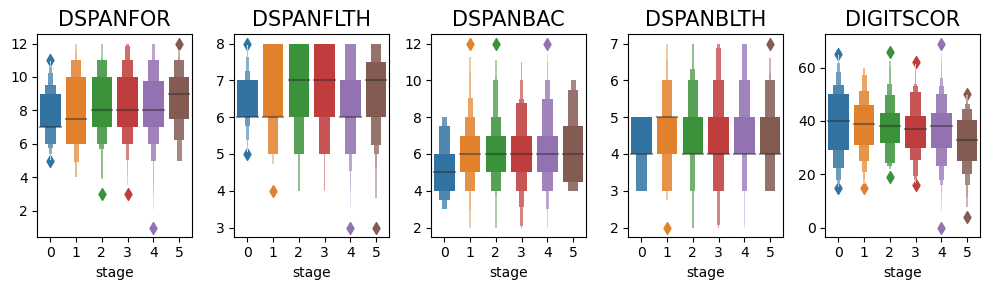

In [226]:
flds = ["DSPANFOR", "DSPANFLTH", "DSPANBAC", "DSPANBLTH", "DIGITSCOR"]
rows = 1; cols=5;
test_name = "digit_span"
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(10,3))
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[_])
    ax[_].set_ylabel("")
    ax[_].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [ ]:
# Category Fluency Test

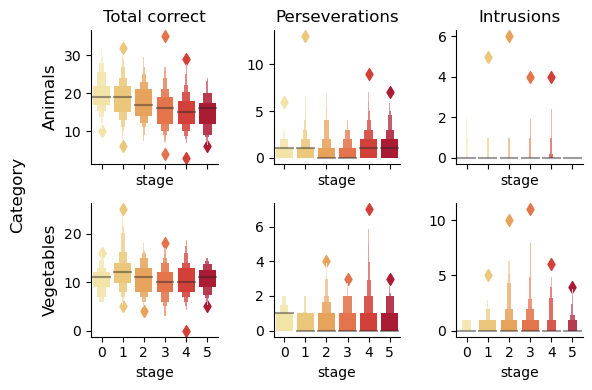

In [227]:
flds = ["CATANIMSC", "CATANPERS", "CATANINTR", "CATVEGESC", "CATVGPERS", "CATVGINTR"]
flds_title = {"CATANIMSC":"Total correct", "CATANPERS":"Perseverations", "CATANINTR":"Intrusions",
             "CATVEGESC":"", "CATVGPERS":"", "CATVGINTR":""}
rows = 2; cols=3;
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(6,4))
test_name = "cat_test"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c],palette=palette_color1)
    ax[r, c].set_ylabel("")
    ax[r, c].set_title(flds_title[fld], fontsize=12)
    ax[r, c].spines[['right', 'top']].set_visible(False)
ax[0,0].set_ylabel("Animals", fontsize=12)
ax[1,0].set_ylabel("Vegetables", fontsize=12)
fig.supylabel("Category", fontsize=12)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

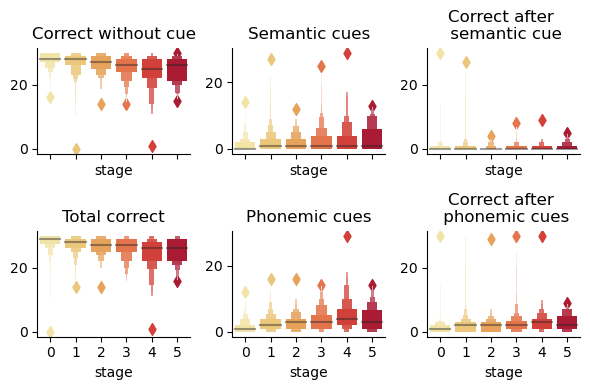

In [228]:
flds = ["BNTSPONT", "BNTSTIM", "BNTCSTIM", "BNTTOTAL", "BNTPHON", "BNTCPHON"]
flds_title = {"BNTSPONT":"Correct without cue", "BNTSTIM": "Semantic cues",
             "BNTCSTIM":"Correct after \n semantic cue", "BNTPHON":"Phonemic cues",
             "BNTCPHON":"Correct after \n phonemic cues", "BNTTOTAL":"Total correct"}
rows = 2; cols=3;
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(6,4))
test_name = "bnt_test"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax[r,c], palette=palette_color1)
    ax[r, c].set_ylabel("")
    ax[r, c].set_title(flds_title[fld], fontsize=12)
    ax[r, c].spines[['right', 'top']].set_visible(False)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

# American National Adult Reading Test

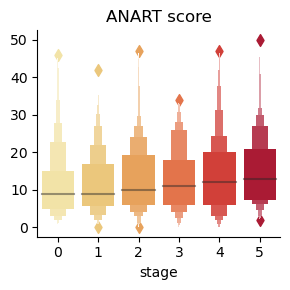

In [119]:
flds = ["ANARTERR"]
rows = 1; cols=1;
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(3,3))
test_name = "anart_test"
for _,fld in enumerate(flds):
    df_mh_fld = process_df(df_mh, fld)
    r = _//cols
    c = _%cols
    sns.boxenplot(data=df_mh_fld, x="stage", y=fld, ax=ax, palette=palette_color1)
    ax.set_ylabel("")
    ax.set_title("ANART score", fontsize=12)
fig.tight_layout()
ax.spines[['right', 'top']].set_visible(False)
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [122]:
neuro_sc = "ANARTERR"
df_xx = regress_score(df_mh_fld, neuro_sc, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4", "stage"])
df_xx.dropna(inplace=True)
model = sm.OLS(df_xx[[neuro_sc]], 
               sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT","AGE"]]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               ANARTERR   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     42.02
Date:                Sun, 16 Jun 2024   Prob (F-statistic):           2.46e-31
Time:                        19:38:12   Log-Likelihood:                -2293.0
No. Observations:                 651   AIC:                             4596.
Df Residuals:                     646   BIC:                             4618.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.6591      3.853      8.476      0.0

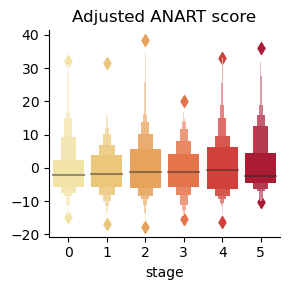

In [129]:
fig, ax = plt.subplots(rows,cols, sharex=True, sharey=False, figsize=(3,3))
test_name = "anart_test_resid"
sns.boxenplot(data=pd.concat([results.resid, df_xx["stage"]], axis=1),  x="stage", y=0, palette=palette_color1)
ax.set_ylabel("")
ax.set_title(r'Adjusted ANART score', fontsize=12)
fig.tight_layout()
ax.spines[['right', 'top']].set_visible(False)
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)


In [121]:
df_mh_fld["ANARTERR"]

12      26.0
21       4.0
28       2.0
35       2.0
38       6.0
        ... 
3228     6.0
3234     6.0
3239     5.0
3243     2.0
3247     2.0
Name: ANARTERR, Length: 653, dtype: float64

# Regression stats for all neurobattery tests (clock, BNT, CATegory etc)

In [231]:
flds = ["CLOCKSCOR", "COPYSCOR"] + ["LIMMTOTAL", "DSPANFOR", "DSPANFLTH", 
        "DSPANBAC", "DSPANBLTH", "DIGITSCOR", "CATANIMSC", "CATANPERS", "CATANINTR",
        "CATVEGESC", "CATVGPERS", "CATVGINTR"] + ["LDELTOTAL", "BNTSPONT", "BNTSTIM",
        "BNTCSTIM", "BNTPHON", "BNTCPHON", "BNTTOTAL", "ANARTERR"]
test_name = "neurobat_ols_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [232]:
df_xx = regress_score(df_mh, "ANARTERR", ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
df_xx.dropna(inplace=True)
stats_df1 = regress_OLS(df_xx, "ANARTERR", cov1)

In [233]:
stats_df1

,p-vals,coef,std-err,conf-int-lower95,conf-int-upper95,fld,r-sq-adj,f-pvalue
const,1.661282e-15,33.145078,4.057686,25.177139,41.113017,ANARTERR,0.20481,1.213082e-29
PTGENDER,6.560939e-06,3.292751,0.724454,1.870165,4.715337,ANARTERR,0.20481,1.213082e-29
APOE4,5.269306e-01,0.305101,0.481959,-0.641306,1.251509,ANARTERR,0.20481,1.213082e-29
PTEDUCAT,1.891558e-30,-1.455810,0.120442,-1.692317,-1.219303,ANARTERR,0.20481,1.213082e-29
AGE,8.882677e-01,0.007217,0.051345,-0.093607,0.108040,ANARTERR,0.20481,1.213082e-29
stage,8.504097e-02,0.458508,0.265830,-0.063492,0.980509,ANARTERR,0.20481,1.213082e-29
st1,1.714968e-01,-1.216394,0.888566,-2.961240,0.528453,ANARTERR,0.20481,1.213082e-29
st2,2.300564e-01,-1.198143,0.997326,-3.156559,0.760273,ANARTERR,0.20481,1.213082e-29
st3,1.571542e-01,-1.394735,0.984730,-3.328416,0.538946,ANARTERR,0.20481,1.213082e-29


# MMSE

In [42]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "MMSE_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["PTID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["sid", "VISCODE"], 
         right_on=["PTID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

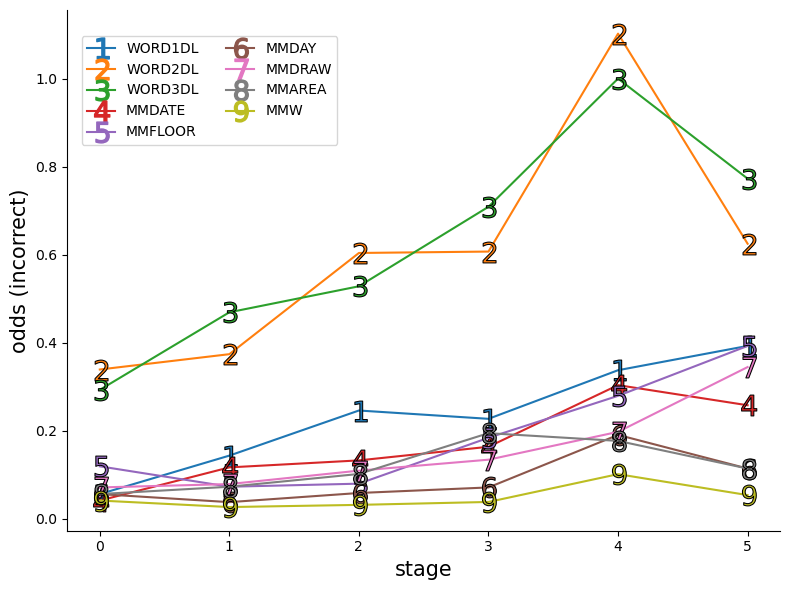

In [43]:
flds = ["MMDATE","MMYEAR","MMMONTH","MMDAY","MMSEASON","MMHOSPIT","MMFLOOR","MMCITY","MMAREA","MMSTATE",
       "WORD1","WORD2","WORD3","MMTRIALS","MMD","MML","MMR","MMO","MMW",
        "WORD1DL","WORD2DL","WORD3DL","MMWATCH","MMPENCIL","MMREPEAT","MMHAND","MMFOLD",
        "MMONFLR","MMREAD","MMWRITE","MMDRAW","MMSCORE"]
# binary = ["MMDATE","MMYEAR","MMMONTH","MMDAY","MMSEASON","MMHOSPIT","MMFLOOR","MMCITY","MMAREA","MMSTATE",
#        "WORD1","WORD2","WORD3","MMD","MML","MMR","MMO","MMW",
#         "WORD1DL","WORD2DL","WORD3DL","MMWATCH","MMPENCIL","MMREPEAT","MMHAND","MMFOLD",
#         "MMONFLR","MMREAD","MMWRITE","MMDRAW"]
binary = ["WORD1DL", "WORD2DL", "WORD3DL", "MMDATE", "MMFLOOR", "MMDAY", "MMDRAW", "MMAREA", "MMW"]
test_name = "mmse_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
fig, ax = plt.subplots(figsize=(8,6))
markers = ['${}$'.format(_+1) for _ in range(len(binary))]
sns.lineplot(data=ratio_df[binary], ax = ax, dashes=False, markers=markers, markersize=15, mec="k")

lgnd = plt.legend(bbox_to_anchor=(0.02, 0.95), loc='upper left', borderaxespad=0, ncol=2)
for m_ in range(len(markers)):
    lgnd.legendHandles[m_].set_markersize(15)
    
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel("odds (incorrect)", fontsize=15)
ax.set_xlabel("stage", fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)


In [44]:
mmdraw = ratio_df["MMDRAW"]

In [236]:
neuro_sc = "MMSCORE"
df_xx = regress_score(df_mh, neuro_sc, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
df_xx.dropna(inplace=True)
model = sm.OLS(df_xx[[neuro_sc]], 
               sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                MMSCORE   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     14.42
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           9.25e-20
Time:                        15:25:18   Log-Likelihood:                -1669.5
No. Observations:                 806   AIC:                             3357.
Df Residuals:                     797   BIC:                             3399.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.3664      0.856     33.133      0.0

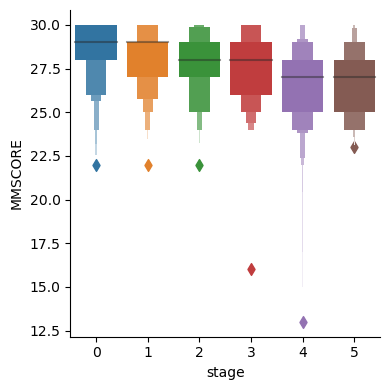

In [237]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=False, figsize=(4, 4))
sns.boxenplot(data=df_mh_fld, x="stage", y="MMSCORE")
ax.spines[['right', 'top']].set_visible(False)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "MMSCORE_boxen.png"), dpi=300)


In [238]:
fld = "WORLDSCORE"
df_mh_fld = process_df(df_mh, fld)
sns.boxenplot(data=df_mh_fld, x="stage", y=fld)

ValueError: min() arg is an empty sequence

In [239]:
df_mh["WORLDSCORE"]

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
2585   NaN
2586   NaN
2587   NaN
2588   NaN
2589   NaN
Name: WORLDSCORE, Length: 2590, dtype: float64

## Logistic regression - MMSE

In [240]:
flds = ["MMDATE","MMYEAR","MMMONTH","MMDAY","MMSEASON","MMHOSPIT","MMFLOOR","MMCITY","MMAREA","MMSTATE",
       "WORD1","WORD2","MMD","MML","MMR","MMO","MMW",
        "WORD1DL","WORD2DL","WORD3DL","MMWATCH","MMPENCIL","MMREPEAT","MMHAND","MMFOLD",
        "MMONFLR","MMREAD","MMWRITE","MMDRAW"]
test_name = "mmse_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_Logit(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_Logit(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

Optimization terminated successfully.
         Current function value: 0.390022
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404909
         Iterations 6
         Current function value: 0.072759
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.078206
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.090190
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.093797
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.260250
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.268878
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.304280
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.305564
         Iterations 7
Optimization ter

# EMBIC

In [241]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "EMBICqCP_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [242]:
flds = ["N1M","N1SD","N2M","N2SD","N3M","N3SD","N4M","N4SD","R1M","R1SD","R2M","R2SD","R3M","R3SD","MIFR1M","MIFR1SD",
        "MIFR2M","MIFR2SD","MIFR3M","MIFR3SD","MDFR1M","MDFR1SD","MTranM","MTranSD","MDuraM","MDuraSD"]
test_name = "embic_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = process_df(df_mh, fld)
    print("Shape", df_mh_fld.shape)
    kruskal_stats = kruskal(*[group[fld].values for name, group in df_mh_fld.groupby("stage")])
    kruskal_pval = kruskal_stats.pvalue
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [kruskal_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["kruskal-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))


Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)
Shape (773, 41)


### Regression

In [243]:
df_xx

,AGE,PTGENDER,PTEDUCAT,APOE4,stage,MMDRAW,st0,st1,st2,st3
0,65.1,0,16,1.0,4,1.0,1,0,0,0
4,81.6,1,16,0.0,4,1.0,0,1,0,0
8,69.3,0,14,1.0,4,1.0,0,0,1,0
11,73.6,1,14,0.0,1,1.0,0,1,0,0
15,57.8,1,20,0.0,1,1.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
2576,78.5,0,12,0.0,3,1.0,0,1,0,0
2577,62.0,1,16,0.0,0,1.0,1,0,0,0
2581,69.3,0,12,1.0,3,0.0,1,0,0,0
2584,81.4,1,18,0.0,0,1.0,1,0,0,0


In [244]:
flds = ["N1M","N1SD","N2M","N2SD","N3M","N3SD","N4M","N4SD","R1M","R1SD","R2M","R2SD","R3M","R3SD","MIFR1M","MIFR1SD",
        "MIFR2M","MIFR2SD","MIFR3M","MIFR3SD","MDFR1M","MDFR1SD","MTranM","MTranSD","MDuraM","MDuraSD"]
test_name = "embic_test_logodds"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS_logodds(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS_logodds(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [245]:
flds = ["N1M","N1SD","N2M","N2SD","N3M","N3SD","N4M","N4SD","R1M","R1SD","R2M","R2SD","R3M","R3SD","MIFR1M","MIFR1SD",
        "MIFR2M","MIFR2SD","MIFR3M","MIFR3SD","MDFR1M","MDFR1SD","MTranM","MTranSD","MDuraM","MDuraSD"]
test_name = "embic_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

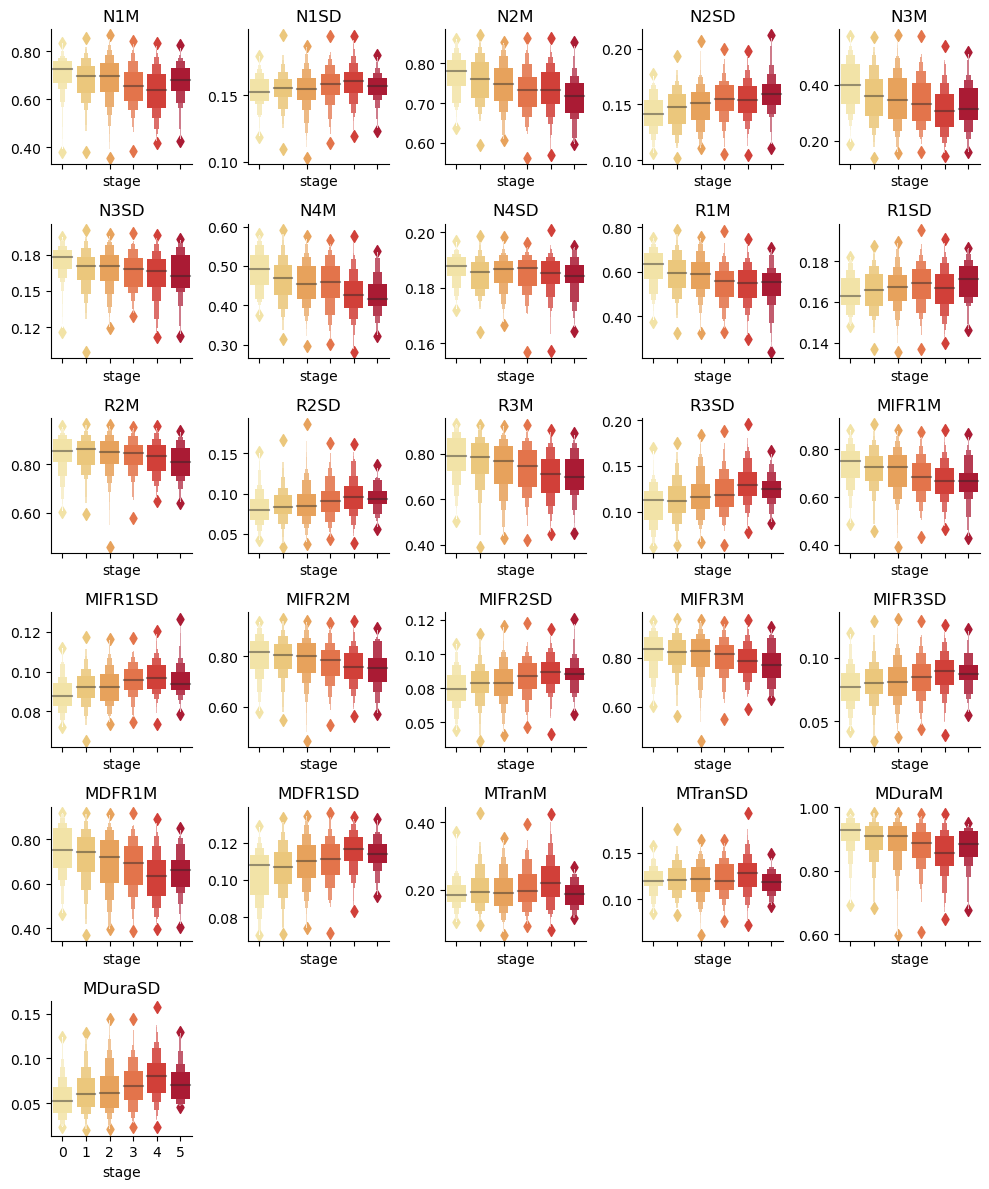

In [246]:
fmt = '%.2f'
yticks = mtick.FormatStrFormatter(fmt)
fig, ax = plt.subplots(6,5, figsize=(10,12), sharex=True)
for i, fld in enumerate(flds):
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    r = i // 5
    c = i % 5
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c],
                 palette=palette_color1)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].set_ylabel("")
    ax[r,c].yaxis.set_major_formatter(yticks)
    ax[r,c].set_title(fld, fontsize=12)

for _ in range(1,5):
    ax[5,_].set_axis_off()
    
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

# ADAS - ADNI GO, 2, 3

In [354]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "ADAS_ADNIGO23_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [355]:
flds = ["Q3TASK1", "Q3TASK2", "Q3TASK3", "Q3TASK4", "TOTSCORE", "TOTAL13"]
binary = []
test_name = "adas_go23_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print("Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))


Shape (457, 134)
Shape (457, 134)
Shape (457, 134)
Shape (457, 134)
Shape (457, 134)
Shape (457, 134)


# Logistic regression for the cube test

In [356]:
fld = "Q3TASK4"
test_name = "adas_go23_test"
df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
df_xx.dropna(inplace=True)
df_xx[fld] = df_xx[fld].map({1:1,2:0,3:0})
stats_df1 = regress_Logit(df_xx, fld, cov1)
stats_df1

Optimization terminated successfully.
         Current function value: 0.654782
         Iterations 5


,p-vals,coef,std-err,conf-int-lower95,conf-int-upper95,fld,psuedo-r-sq,llr_pvalue
const,0.904306,0.151610,1.261072,-2.320045,2.623265,Q3TASK4,0.053287,0.000049
PTGENDER,0.410294,-0.180533,0.219259,-0.610273,0.249207,Q3TASK4,0.053287,0.000049
APOE4,0.112855,-0.234913,0.148164,-0.525309,0.055483,Q3TASK4,0.053287,0.000049
PTEDUCAT,0.001954,0.117329,0.037882,0.043081,0.191577,Q3TASK4,0.053287,0.000049
AGE,0.269906,-0.017435,0.015803,-0.048407,0.013538,Q3TASK4,0.053287,0.000049
stage,0.019983,-0.194959,0.083793,-0.359190,-0.030728,Q3TASK4,0.053287,0.000049
st1,0.506381,0.178898,0.269229,-0.348781,0.706576,Q3TASK4,0.053287,0.000049
st2,0.219678,-0.387114,0.315397,-1.005281,0.231053,Q3TASK4,0.053287,0.000049
st3,0.176051,-0.399996,0.295633,-0.979425,0.179434,Q3TASK4,0.053287,0.000049


In [357]:
df_xx

,AGE,PTGENDER,PTEDUCAT,APOE4,stage,Q3TASK4,st0,st1,st2,st3
0,57.8,1,20,0.0,1,1,0,1,0,0
4,62.9,0,20,1.0,1,1,0,0,0,1
10,72.2,0,20,1.0,1,1,0,0,1,0
12,63.4,0,20,0.0,1,1,0,0,1,0
18,69.4,1,16,0.0,3,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1459,78.5,0,12,0.0,3,0,0,1,0,0
1460,62.0,1,16,0.0,0,1,1,0,0,0
1464,69.3,0,12,1.0,3,1,1,0,0,0
1467,81.4,1,18,0.0,0,0,1,0,0,0


Shape (457, 134)


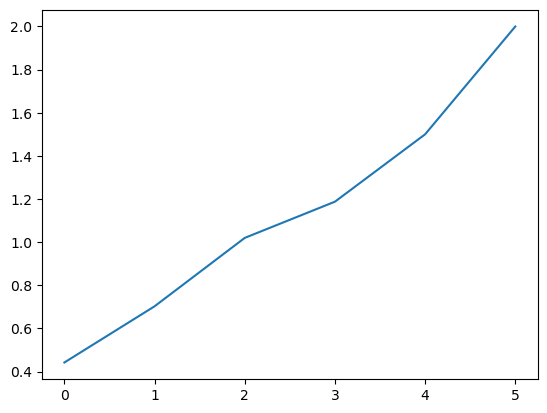

In [358]:
fld = "Q3TASK4"
test_name = "adas_go23_test"

ratio_df = pd.DataFrame()
df_mh_fld = process_df(df_mh, fld)
print("Shape", df_mh_fld.shape)
chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
chi2_stats = chi2_contingency(chi2_table)
chi2_pval = chi2_stats[1]
ratio = chi2_table[2]/chi2_table[1]
# ratio_df[fld] = ratio
spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
plt.plot(ratio)


In [359]:
chi2_table, spearmanr_corr

(Q3TASK4   1.0   2.0  3.0
 stage                   
 0        43.0  19.0  1.0
 1        84.0  59.0  0.0
 2        51.0  52.0  0.0
 3        32.0  38.0  1.0
 4        26.0  39.0  0.0
 5         4.0   8.0  0.0,
 0.18513668716299386)

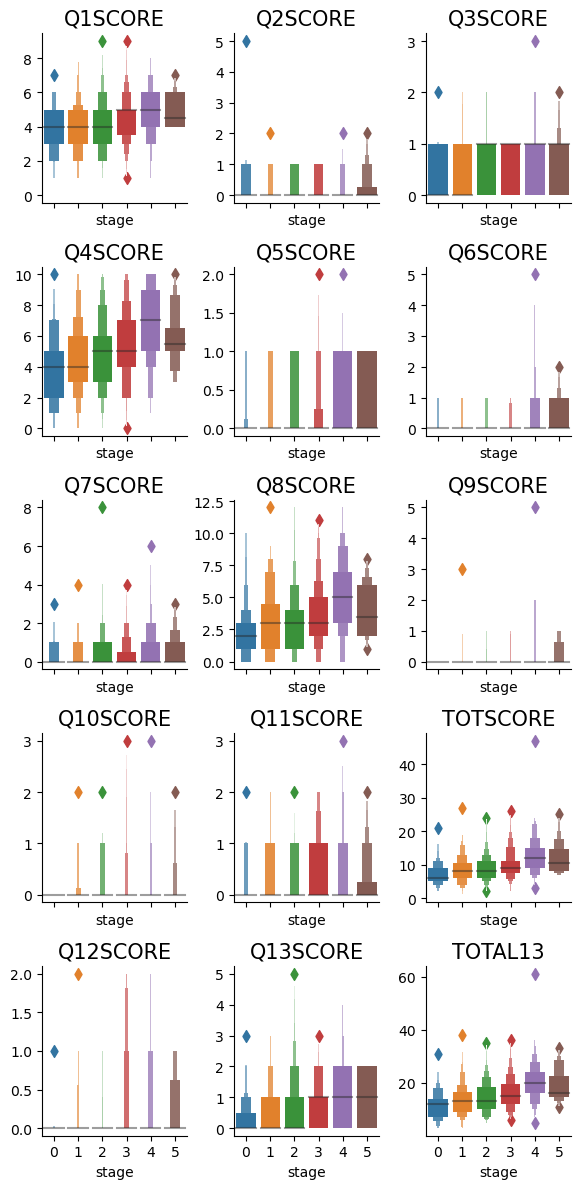

In [253]:
flds = ["Q1SCORE", "Q2SCORE", "Q3SCORE", "Q4SCORE", "Q5SCORE",
        "Q6SCORE", "Q7SCORE", "Q8SCORE", "Q9SCORE", "Q10SCORE",
       "Q11SCORE", "TOTSCORE", "Q12SCORE", "Q13SCORE", "TOTAL13"]
fig, ax = plt.subplots(5,3, figsize=(6,12), sharex=True)
for i, fld in enumerate(flds):
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    r = i // 3
    c = i % 3
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].set_ylabel("")
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [254]:
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    model = sm.OLS(df_xx[[fld]], 
                   sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT", "AGE", 
                                          "stage","st1", "st2", "st3"]]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params],axis=1)
    stats_df.columns = ["p-vals", "coef"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    
    stats_df_list.append(stats_df)
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [255]:
stats_df_all

,p-vals,coef,fld,r-sq-adj
const,9.125630e-03,2.218399,Q1SCORE,0.161232
PTGENDER,3.209060e-04,0.527950,Q1SCORE,0.161232
APOE4,1.297959e-05,0.435477,Q1SCORE,0.161232
PTEDUCAT,6.703917e-02,-0.045798,Q1SCORE,0.161232
AGE,3.975130e-02,0.021805,Q1SCORE,0.161232
...,...,...,...,...
AGE,6.604275e-03,0.130916,TOTAL13,0.217029
stage,1.022495e-10,1.681504,TOTAL13,0.217029
st1,1.709415e-01,1.119028,TOTAL13,0.217029
st2,6.943843e-01,0.374722,TOTAL13,0.217029


# ADAS - ADNI 1

In [256]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "ADAS_ADNI1_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [257]:
df_mh_fld = process_df(df_mh, "COCONSTR")

In [258]:
def harmonize_coconstr(x):
    l = x.split(":")
    int_l =[int(_) for _ in l]
    int_l.sort()
    res_list = []
    res_list = [1*(_ in int_l) for _ in range(1,6)]
    return res_list

In [259]:
s = df_mh_fld["COCONSTR"].apply(lambda x: harmonize_coconstr(x))
df_coconstr = pd.DataFrame(np.vstack(s))
df_coconstr.columns = ["no-shape", "circ", "rectangles", "rhombus", "cube"]
df_coconstr2 = pd.concat([df_mh_fld, df_coconstr], axis=1)

Shape (609, 99)


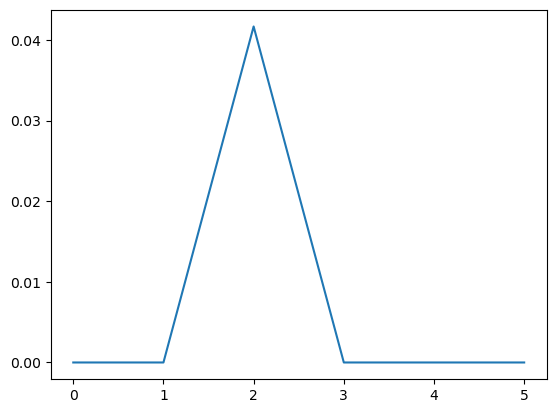

In [260]:
fld = "rectangles"
test_name = "adas_1_test"
ratio_df = pd.DataFrame()
print("Shape", df_coconstr2.shape)
chi2_table = df_coconstr2.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
chi2_stats = chi2_contingency(chi2_table)
chi2_pval = chi2_stats[1]
ratio = chi2_table[0]/chi2_table[1]
# ratio_df[fld] = ratio
# spearmanr_corr = spearmanr(df_coconstr["stage"], df_coconstr[fld]).correlation
plt.plot(ratio)


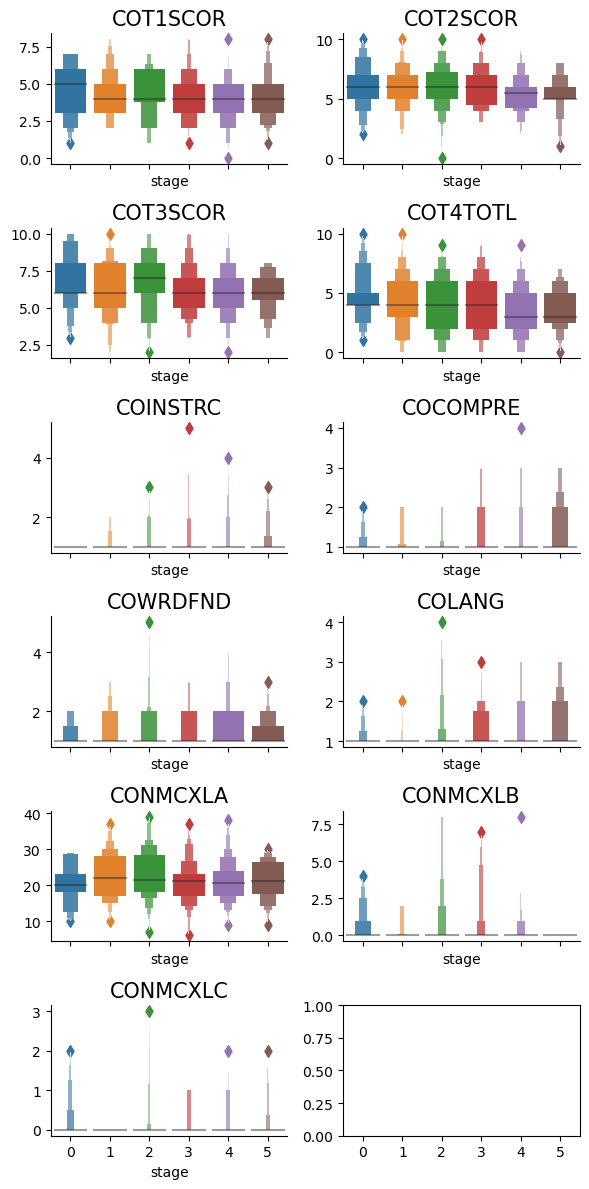

In [261]:
flds = ["COT1SCOR", "COT2SCOR", "COT3SCOR", "COT4TOTL",
        "COINSTRC", "COCOMPRE", "COWRDFND", "COLANG", "CONMCXLA",
        "CONMCXLB", "CONMCXLC"]
test_name = "ADAS1_test"
fig, ax = plt.subplots(6,2, figsize=(6,12), sharex=True)
for i, fld in enumerate(flds):
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    r = i // 2
    c = i % 2
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
    ax[r,c].spines[['right', 'top']].set_visible(False)
    ax[r,c].set_ylabel("")
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [262]:
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    model = sm.OLS(df_xx[[fld]], 
                   sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT", "AGE", 
                                          "stage","st1", "st2", "st3"]]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params],axis=1)
    stats_df.columns = ["p-vals", "coef"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    
    stats_df_list.append(stats_df)
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [263]:
stats_df_all

,p-vals,coef,fld,r-sq-adj
const,0.000321,3.544380,COT1SCOR,0.052898
PTGENDER,0.424982,-0.151615,COT1SCOR,0.052898
APOE4,0.045051,-0.240546,COT1SCOR,0.052898
PTEDUCAT,0.018218,0.063718,COT1SCOR,0.052898
AGE,0.480851,0.009069,COT1SCOR,0.052898
...,...,...,...,...
AGE,0.800860,0.000646,CONMCXLC,-0.016440
stage,0.777063,0.004148,CONMCXLC,-0.016440
st1,0.846469,0.008922,CONMCXLC,-0.016440
st2,0.656829,0.021030,CONMCXLC,-0.016440


# CDR

In [264]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "CDR_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [265]:
flds = ["CDMEMORY","CDORIENT","CDJUDGE","CDCOMMUN","CDHOME","CDCARE","CDGLOBAL","CDRSB"]
binary = []
test_name = "cdrsb_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print("Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))
# fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)



Shape (808, 36)
Shape (808, 36)
Shape (808, 36)
Shape (808, 36)
Shape (808, 36)
Shape (808, 36)
Shape (808, 36)
Shape (808, 36)


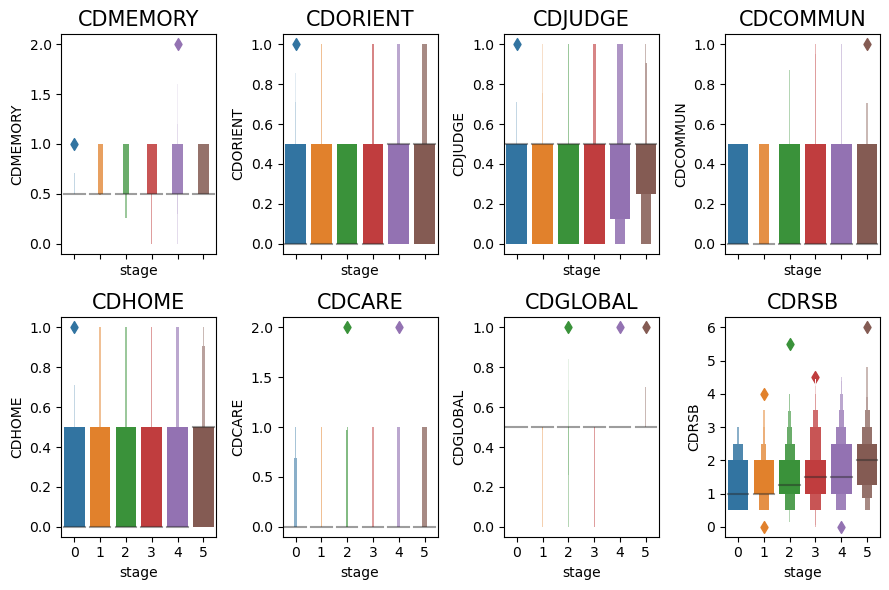

In [266]:
fig, ax = plt.subplots(2,4, figsize=(9,6), sharex=True)
for i, fld in enumerate(flds):
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    r = i // 4
    c = i % 4
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "CDR.png"), dpi=300)

In [267]:
neurobat_df

,chi-2-pval,spearmanr
CDMEMORY,0.000403,0.184647
CDORIENT,0.013003,0.126085
CDJUDGE,0.002487,0.161278
CDCOMMUN,0.005894,0.131220
CDHOME,0.005988,0.150496
CDCARE,0.560470,0.059751
CDGLOBAL,0.347212,0.022600
CDRSB,0.000027,0.213908


In [268]:
flds = ["CDMEMORY","CDORIENT","CDJUDGE","CDCOMMUN","CDHOME","CDCARE","CDGLOBAL","CDRSB"]
test_name = "cdr_test"
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    model = sm.OLS(df_xx[[fld]], 
                   sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT","AGE", "stage", "st1", "st2", "st3"]]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params],axis=1)
    stats_df.columns = ["p-vals", "coef"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    
    stats_df_list.append(stats_df)
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

In [269]:
stats_df_all

,p-vals,coef,fld,r-sq-adj
const,9.495171e-15,0.625321,CDMEMORY,0.045519
PTGENDER,9.443990e-01,0.000994,CDMEMORY,0.045519
APOE4,1.220681e-01,0.014655,CDMEMORY,0.045519
PTEDUCAT,2.456885e-01,0.002639,CDMEMORY,0.045519
AGE,6.260656e-03,-0.002783,CDMEMORY,0.045519
...,...,...,...,...
AGE,2.669131e-03,-0.015228,CDRSB,0.070042
stage,1.534141e-12,0.187193,CDRSB,0.070042
st1,2.089203e-02,0.201537,CDRSB,0.070042
st2,9.904055e-01,-0.001169,CDRSB,0.070042


# GDSCALE

In [397]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "GDSCALE_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)
df_mh["GDDROP"] = df_mh["GDDROP"].map({0:1, 1:0})

Shape (2, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)
Shape (786, 43)


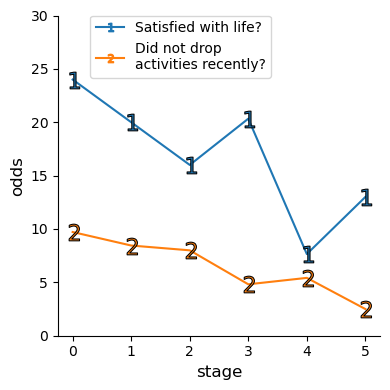

In [412]:
flds = ["GDUNABL", "GDSATIS", "GDDROP", "GDEMPTY", "GDBORED", "GDSPIRIT", "GDAFRAID", "GDHAPPY", "GDHELP", "GDHOME", "GDMEMORY",
        "GDALIVE", "GDWORTH", "GDENERGY", "GDHOPE", "GDBETTER", "GDTOTAL"]
# binary = ["GDSATIS", "GDDROP", "GDEMPTY", "GDBORED", "GDSPIRIT", "GDAFRAID", "GDHAPPY", "GDHELP", "GDHOME", "GDMEMORY",
#         "GDALIVE", "GDWORTH", "GDENERGY", "GDHOPE"]
binary = ["GDSATIS", "GDDROP"]
test_name = "gdscale_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = process_df(df_mh, fld)
    print("Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[1]/chi2_table[0]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

fig, ax = plt.subplots(figsize=(4,4))
markers = ['${}$'.format(_+1) for _ in range(len(binary))]
sns.lineplot(data=ratio_df[binary], ax = ax, dashes=False, markers=markers, markersize=12, mec="k")

lgnd = plt.legend(borderaxespad=0, ncol=1)
for m_ in range(len(markers)):
    lgnd.legendHandles[m_].set_markersize(12)

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel("odds", fontsize=12)
ax.set_xlabel("stage", fontsize=12)
ax.set_xticks([0,1,2,3,4,5])
ax.set_ylim([0,30])
lgnd = plt.legend(bbox_to_anchor=(0.1, 1.), loc='upper left', borderaxespad=0, ncol=1)
# for m_ in range(len(markers)):
#     lgnd.legendHandles[m_].set_markersize(12)
flds_text = {"GDSATIS":"Satisfied with life?","GDDROP":"Did not drop\nactivities recently?"}
for t, l in zip(lgnd.texts, binary):
    t.set_text(flds_text[l])
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))


In [272]:
flds = ["GDSATIS", "GDDROP", "GDEMPTY", "GDBORED", "GDSPIRIT", "GDAFRAID", "GDHAPPY", "GDHELP", "GDHOME", "GDMEMORY",
        "GDALIVE", "GDWORTH", "GDENERGY", "GDHOPE"]
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_Logit(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_Logit(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

Optimization terminated successfully.
         Current function value: 0.235500
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.243313
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401968
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.120506
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.121757
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.292464
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.295594
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.155392
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.156188
  

In [273]:
neuro_sc = "GDTOTAL"
df_xx = regress_score(df_mh, neuro_sc, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
df_xx.dropna(inplace=True)
model = sm.OLS(df_xx[[neuro_sc]], 
               sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                GDTOTAL   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.274
Date:                Sun, 02 Jun 2024   Prob (F-statistic):             0.0209
Time:                        15:27:59   Log-Likelihood:                -1429.9
No. Observations:                 784   AIC:                             2878.
Df Residuals:                     775   BIC:                             2920.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4194      0.676      5.056      0.0

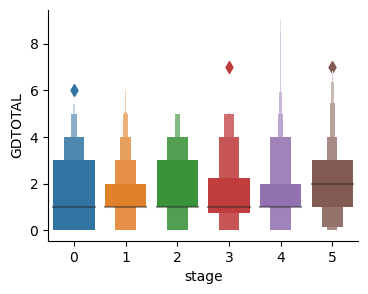

In [274]:
fig, ax = plt.subplots(1,1, sharex=True, sharey=False, figsize=(4, 3))
df_mh_fld = process_df(df_mh, "GDTOTAL")
sns.boxenplot(data=df_mh_fld, x="stage", y="GDTOTAL")
ax.spines[['right', 'top']].set_visible(False)
fig.savefig(os.path.join(dir_path, "GDTOTAL_boxen.png"), dpi=300)


# FAQ Test

In [275]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "FAQ_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [276]:
flds = ["FAQFINAN", "FAQFORM", "FAQSHOP", "FAQGAME", "FAQBEVG", "FAQMEAL", "FAQEVENT",
        "FAQTV", "FAQREM", "FAQTRAVL", "FAQTOTAL"]
binary = []
test_name = "FAQ_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print(fld, "Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))



FAQFINAN Shape (807, 36)
FAQFORM Shape (807, 36)
FAQSHOP Shape (808, 36)
FAQGAME Shape (808, 36)
FAQBEVG Shape (808, 36)
FAQMEAL Shape (808, 36)
FAQEVENT Shape (808, 36)
FAQTV Shape (808, 36)
FAQREM Shape (808, 36)
FAQTRAVL Shape (808, 36)
FAQTOTAL Shape (807, 36)


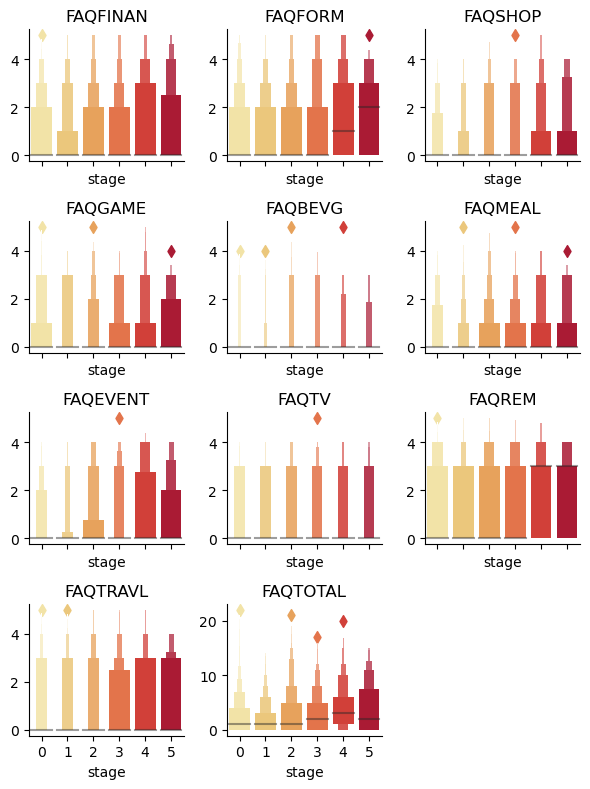

In [277]:
fig, ax = plt.subplots(4,3, figsize=(6,8), sharex=True)
for i, fld in enumerate(flds):
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    r = i // 3
    c = i % 3
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c], palette=palette_color1)
    ax[r,c].set_title(fld, fontsize=12)
    ax[r,c].set_ylabel("")
    ax[r,c].spines[['right', 'top']].set_visible(False)
ax[3,2].set_axis_off()
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "FAQ_test.png"), dpi=300)

In [278]:
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

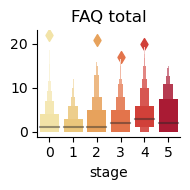

In [279]:
fld = "FAQTOTAL"
fig, ax = plt.subplots(1,1, figsize=(2,2), sharex=True)
df_mh_fld = df_mh.dropna(subset=[fld])
df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax, palette=palette_color1)
ax.set_title("FAQ total", fontsize=12)
ax.set_ylabel("")
ax.spines[['right', 'top']].set_visible(False)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "FAQ_total_test.png"), dpi=300)

# UWNPSYCHSUM

In [280]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "UWNPSYCHSUM_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

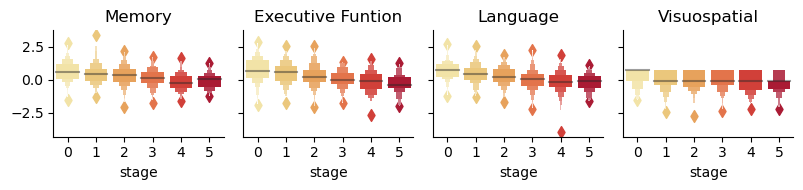

In [281]:
test_name="uwnpsych_test"
flds = ["ADNI_MEM", "ADNI_EF", "ADNI_LAN", "ADNI_VS"]
flds_dict = {"ADNI_MEM":"Memory", "ADNI_EF":"Executive Funtion", "ADNI_EF2":r'$Executive Function^{2}$', 
             "ADNI_LAN":"Language", "ADNI_VS":"Visuospatial"}
fig, ax = plt.subplots(1,4, figsize=(8,2), sharex=True, sharey=True)
for i, fld in enumerate(flds):
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[i], palette=palette_color1)
    ax[i].set_title(flds_dict[fld], fontsize=12)
    ax[i].set_ylabel("")
    ax[i].spines[['right', 'top']].set_visible(False)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [282]:
test_name = "uwnpsych_test"
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# ADAS scores

In [283]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "ADASSCORES_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)

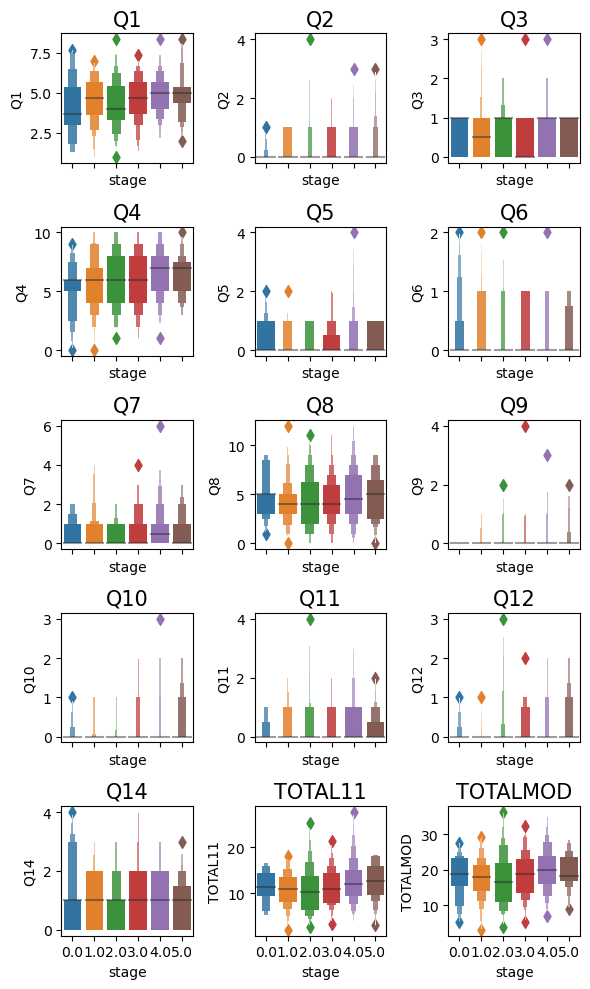

In [284]:
test_name="adas_scores_test"
flds = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8", "Q9",
        "Q10", "Q11", "Q12", "Q14", "TOTAL11", "TOTALMOD"]
fig, ax = plt.subplots(5,3, figsize=(6,10), sharex=True)
for i, fld in enumerate(flds):
    r = i // 3
    c = i % 3
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [285]:
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# FCI

### The data is only after 2017 so there are no matches

# ADNI-CBBRESULTS

### The data does not have viscode making it harder to align.
### Also, it was only started to be measured around 2015, so there is not much data.

# ECOGSP

In [286]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "ECOGSP_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1,9],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

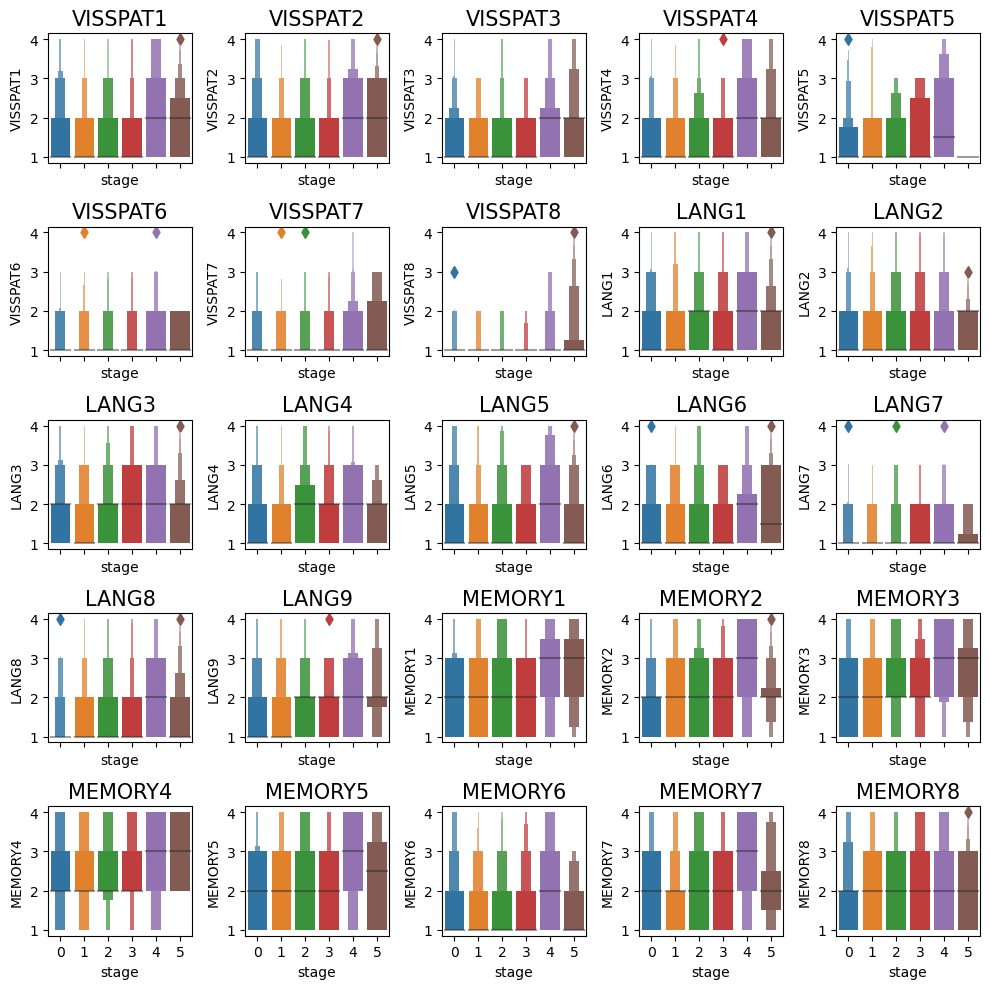

In [287]:
test_name="ecogsp_test"
flds = ["VISSPAT1", "VISSPAT2", "VISSPAT3", "VISSPAT4", "VISSPAT5", "VISSPAT6", "VISSPAT7", "VISSPAT8",
        "LANG1", "LANG2", "LANG3","LANG4","LANG5","LANG6","LANG7","LANG8","LANG9",
        "MEMORY1", "MEMORY2", "MEMORY3", "MEMORY4", "MEMORY5", "MEMORY6", "MEMORY7", "MEMORY8"]
fig, ax = plt.subplots(5,5, figsize=(10,10), sharex=True)
for i, fld in enumerate(flds):
    r = i // 5
    c = i % 5
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [288]:
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# ECOGSP2 - PLANNING, ORGANIZING, DIVATT 

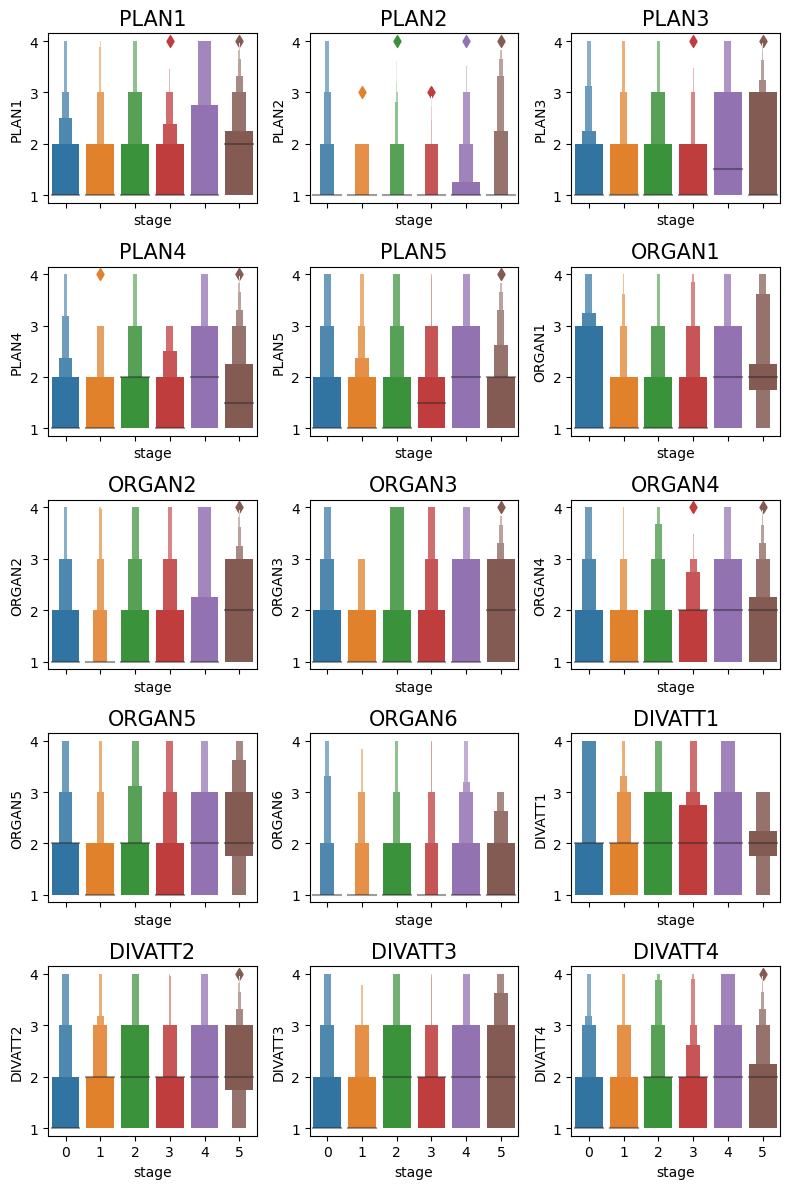

In [289]:
test_name = "ecogsp2_test"
flds = ["PLAN1", "PLAN2", "PLAN3", "PLAN4", "PLAN5", "ORGAN1", "ORGAN2", "ORGAN3", 
        "ORGAN4", "ORGAN5", "ORGAN6", "DIVATT1", "DIVATT2", "DIVATT3", "DIVATT4"]
fig, ax = plt.subplots(5,3, figsize=(8,12), sharex=True)
for i, fld in enumerate(flds):
    r = i // 3
    c = i % 3
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [290]:
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# ECOGPT

In [291]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "ECOGPT_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1,9],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

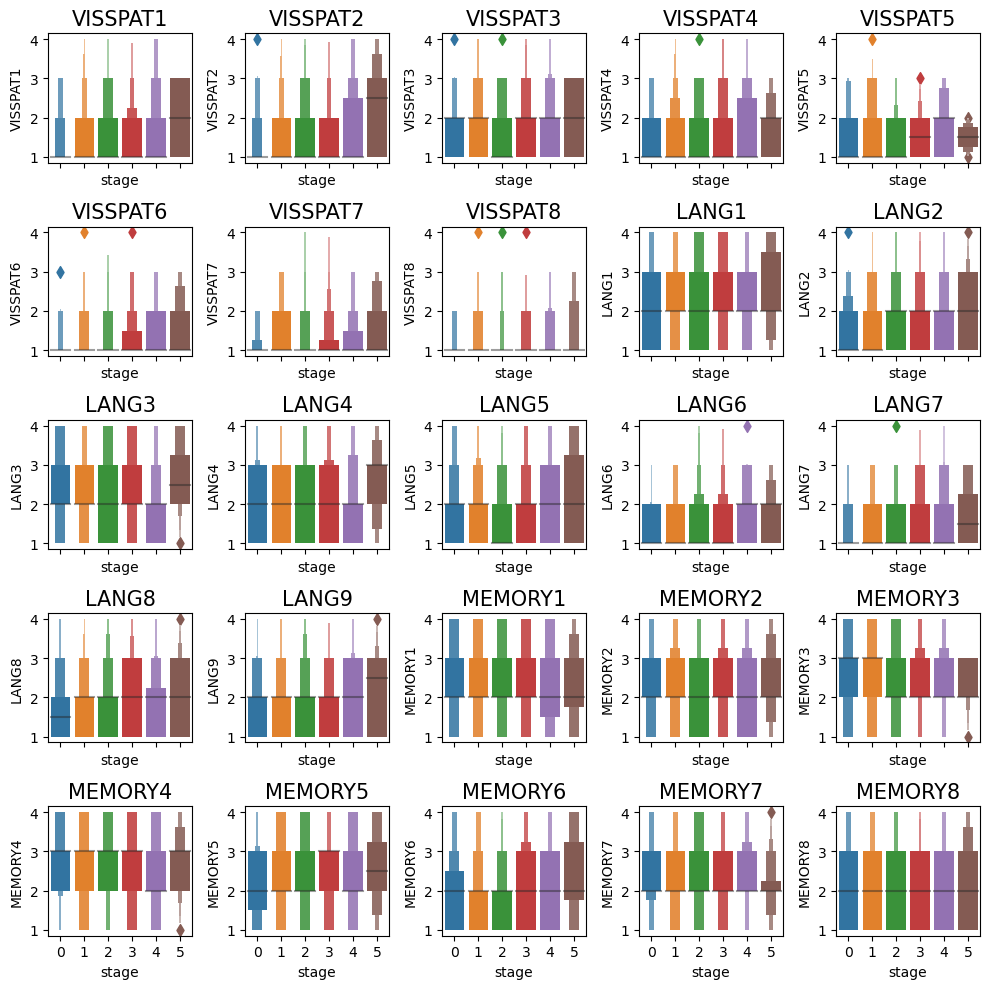

In [292]:
test_name="ecogpt_test"
flds = ["VISSPAT1", "VISSPAT2", "VISSPAT3", "VISSPAT4", "VISSPAT5", "VISSPAT6", "VISSPAT7", "VISSPAT8",
        "LANG1", "LANG2", "LANG3","LANG4","LANG5","LANG6","LANG7","LANG8", "LANG9",
        "MEMORY1", "MEMORY2", "MEMORY3", "MEMORY4", "MEMORY5", "MEMORY6", "MEMORY7", "MEMORY8"]
fig, ax = plt.subplots(5,5, figsize=(10,10), sharex=True)
for i, fld in enumerate(flds):
    r = i // 5
    c = i % 5
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [293]:
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# ECOGPT2 - PLANNING, ORGANIZING, DIVATT

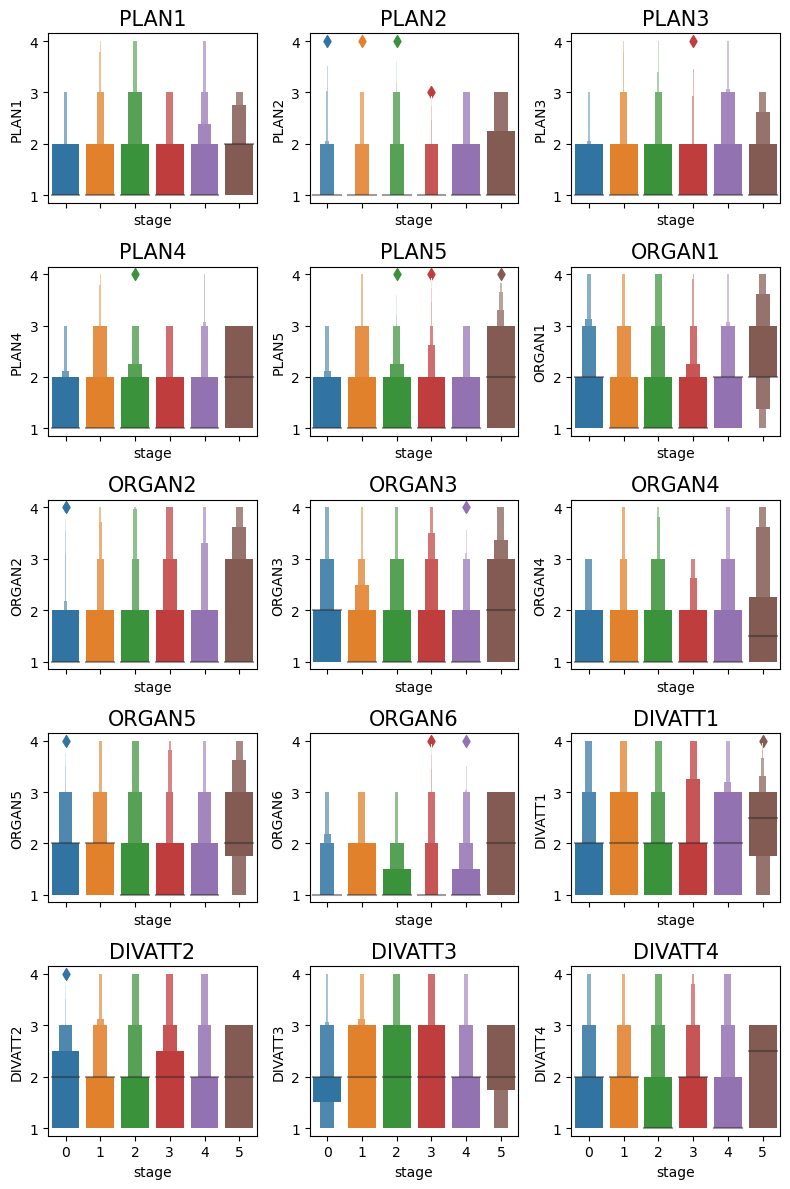

In [294]:
test_name = "ecogpt2_test"
flds = ["PLAN1", "PLAN2", "PLAN3", "PLAN4", "PLAN5", "ORGAN1", "ORGAN2", "ORGAN3", 
        "ORGAN4", "ORGAN5", "ORGAN6", "DIVATT1", "DIVATT2", "DIVATT3", "DIVATT4"]
fig, ax = plt.subplots(5,3, figsize=(8,12), sharex=True)
for i, fld in enumerate(flds):
    r = i // 3
    c = i % 3
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [295]:
cov1 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE","stage","st1", "st2", "st3"]
cov2 = ["PTGENDER", "APOE4", "PTEDUCAT","AGE"]
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_OLS(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_OLS(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# NPI testing

In [296]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "NPI_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

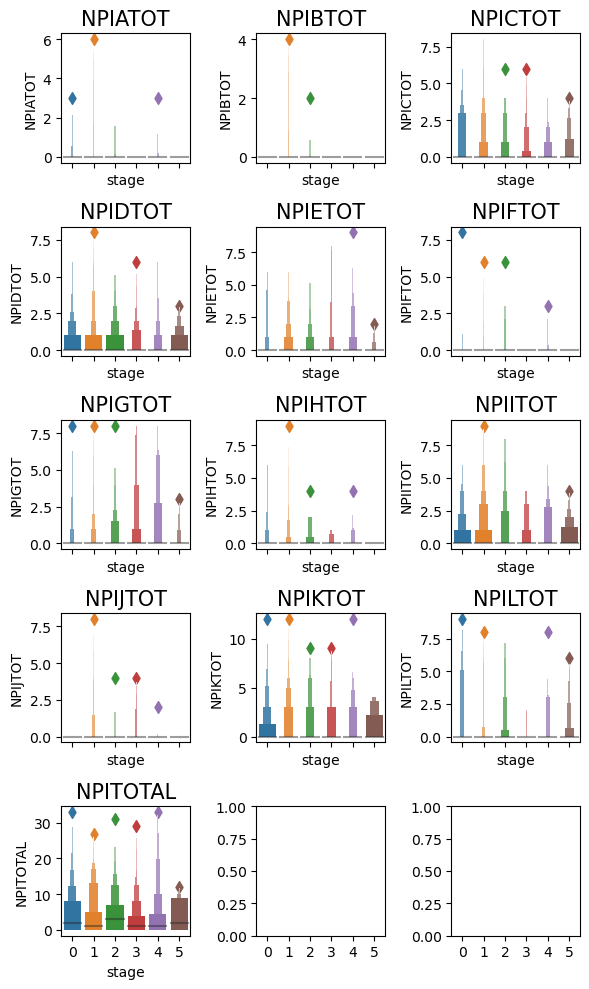

In [297]:
test_name="NPI_test"
flds = ["NPIATOT","NPIBTOT","NPICTOT","NPIDTOT","NPIETOT","NPIFTOT","NPIGTOT","NPIHTOT",
        "NPIITOT","NPIJTOT","NPIKTOT","NPILTOT","NPITOTAL"]
fig, ax = plt.subplots(5,3, figsize=(6,10), sharex=True)
for i, fld in enumerate(flds):
    r = i // 3
    c = i % 3
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [298]:
dir_path

'/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2'

In [299]:
binary = []
test_name = "NPI_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print(fld, "Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["subtype", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))



NPIATOT Shape (427, 176)
NPIBTOT Shape (427, 176)
NPICTOT Shape (427, 176)
NPIDTOT Shape (427, 176)
NPIETOT Shape (427, 176)
NPIFTOT Shape (427, 176)
NPIGTOT Shape (427, 176)
NPIHTOT Shape (427, 176)
NPIITOT Shape (427, 176)
NPIJTOT Shape (427, 176)
NPIKTOT Shape (427, 176)
NPILTOT Shape (427, 176)
NPITOTAL Shape (427, 176)


In [300]:
neurobat_df

,chi-2-pval,spearmanr
NPIATOT,0.611028,-0.028669
NPIBTOT,0.086127,-0.039159
NPICTOT,0.197190,-0.042851
NPIDTOT,0.206652,-0.054759
NPIETOT,0.128164,0.051473
NPIFTOT,0.241293,0.002153
NPIGTOT,0.122818,0.120510
NPIHTOT,0.144822,0.007497
NPIITOT,0.035846,-0.036454
NPIJTOT,0.167555,0.023843


In [301]:
fld = "NPIITOT"
chi2_table = df_mh_fld.groupby(["subtype", fld]).size().unstack(level=1).fillna(0)
chi2_table.div(chi2_table.sum(axis=1), axis=0)

NPIITOT,0.0,1.0,2.0,3.0,4.0,6.0,8.0,9.0
subtype,,,,,,,,
0.0,0.782609,0.072464,0.038647,0.024155,0.048309,0.028986,0.004831,0.000000
1.0,0.775510,0.081633,0.010204,0.071429,0.010204,0.010204,0.030612,0.010204
2.0,0.737705,0.114754,0.000000,0.016393,0.098361,0.032787,0.000000,0.000000
3.0,0.672131,0.163934,0.016393,0.065574,0.032787,0.049180,0.000000,0.000000


In [302]:
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    model = sm.OLS(df_xx[[fld]], 
                   sm.add_constant(df_xx[["PTGENDER", "APOE4", "PTEDUCAT","AGE", "stage", "st1", "st2", "st3"]]))
    results = model.fit()
    stats_df = pd.concat([results.pvalues,results.params],axis=1)
    stats_df.columns = ["p-vals", "coef"]
    stats_df["fld"] = fld
    stats_df["r-sq-adj"] = results.rsquared_adj
    
    stats_df_list.append(stats_df)
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

# NPIQ

In [303]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "NPIQ_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

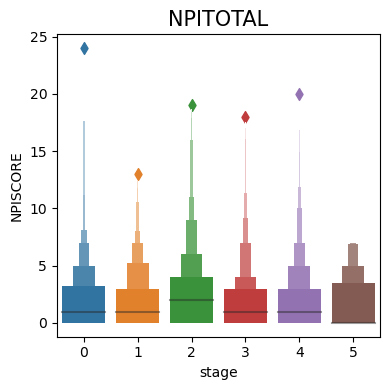

In [304]:
test_name="NPIQ_test"
flds = "NPISCORE"
fig, ax = plt.subplots(1,1, figsize=(4,4), sharex=True)
df_mh_fld = df_mh.dropna(subset=[flds])
df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
sns.boxenplot(data=df_mh_fld,x="stage", y=flds, ax=ax)
ax.set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

In [305]:
flds = ["NPIA","NPIB","NPIC","NPID","NPIE","NPIF","NPIG","NPIH",
        "NPII","NPIJ","NPIK","NPIL"]
binary = []
test_name = "NPIQ_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print(fld, "Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["subtype", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))



NPIA Shape (728, 52)
NPIB Shape (728, 52)
NPIC Shape (728, 52)
NPID Shape (728, 52)
NPIE Shape (728, 52)
NPIF Shape (728, 52)
NPIG Shape (728, 52)
NPIH Shape (728, 52)
NPII Shape (728, 52)
NPIJ Shape (728, 52)
NPIK Shape (728, 52)
NPIL Shape (728, 52)


In [306]:
neurobat_df

,chi-2-pval,spearmanr
NPIA,0.172358,0.022590
NPIB,0.801394,-0.000995
NPIC,0.136194,0.009302
NPID,0.391152,-0.030114
NPIE,0.439273,0.009387
NPIF,0.344362,0.050922
NPIG,0.052084,0.044315
NPIH,0.037925,0.030087
NPII,0.477864,-0.085622
NPIJ,0.275763,0.003658


In [307]:
fld = "NPIH"
chi2_table = df_mh_fld.groupby(["subtype", fld]).size().unstack(level=1).fillna(0)
chi2_table.div(chi2_table.sum(axis=1), axis=0)

NPIH,0.0,1.0
subtype,,
0.0,0.913295,0.086705
1.0,0.837349,0.162651
2.0,0.909091,0.090909
3.0,0.924528,0.075472


## Only NPIH differs across subtypes,
## NPIH : Aggressive behaviour. More in subtype 2 which has more men.

# CCI

## Very little data (not useful)

In [308]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "CCI_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

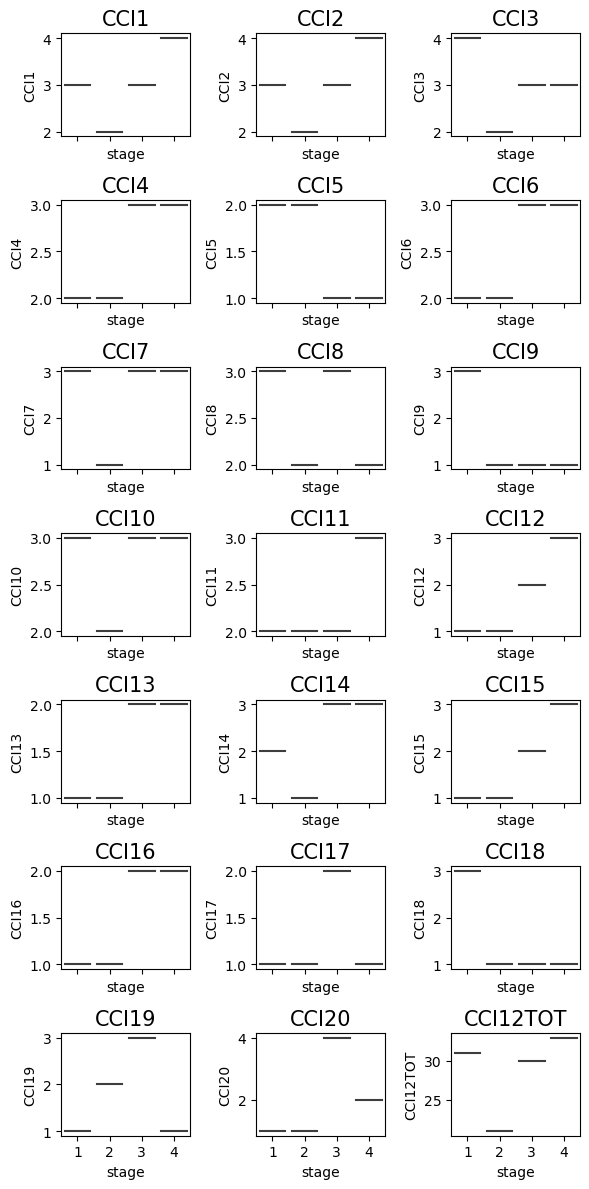

In [309]:
test_name="CCI_test"
flds = ["CCI1","CCI2","CCI3","CCI4","CCI5","CCI6","CCI7","CCI8","CCI9","CCI10",
        "CCI11","CCI12","CCI13","CCI14","CCI15","CCI16","CCI17","CCI18","CCI19","CCI20",
        "CCI12TOT"]
fig, ax = plt.subplots(7,3, figsize=(6,12), sharex=True)
for i, fld in enumerate(flds):
    r = i // 3
    c = i % 3
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    sns.boxenplot(data=df_mh_fld,x="stage", y=fld, ax=ax[r,c])
    ax[r,c].set_title(fld, fontsize=15)
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png".format(test_name)), dpi=300)

# MOCA

In [38]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "MOCA_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [39]:
# del_cols = ["DELW1","DELW2","DELW3","DELW4","DELW5"]
# for dc in del_cols:
#     df_mh[dc] = df_mh[dc].replace([1,2,3],1)

TRAILS Shape (456, 66)
CUBE Shape (456, 66)
CLOCKCON Shape (456, 66)
CLOCKNO Shape (456, 66)
CLOCKHAN Shape (456, 66)
LION Shape (456, 66)
RHINO Shape (456, 66)
CAMEL Shape (456, 66)
IMMT1W1 Shape (456, 66)
IMMT1W2 Shape (456, 66)
IMMT1W3 Shape (456, 66)
IMMT1W4 Shape (456, 66)
IMMT1W5 Shape (456, 66)
IMMT2W1 Shape (456, 66)
IMMT2W2 Shape (456, 66)
IMMT2W3 Shape (456, 66)
IMMT2W4 Shape (456, 66)
IMMT2W5 Shape (456, 66)
DIGFOR Shape (456, 66)
DIGBACK Shape (456, 66)
LETTERS Shape (456, 66)
SERIAL1 Shape (456, 66)
SERIAL2 Shape (456, 66)
SERIAL3 Shape (456, 66)
SERIAL4 Shape (456, 66)
SERIAL5 Shape (456, 66)
REPEAT1 Shape (456, 66)
REPEAT2 Shape (456, 66)
FFLUENCY Shape (456, 66)
ABSTRAN Shape (456, 66)
ABSMEAS Shape (456, 66)
DELW1 Shape (454, 66)
DELW2 Shape (454, 66)
DELW3 Shape (454, 66)
DELW4 Shape (454, 66)
DELW5 Shape (454, 66)
DATE Shape (456, 66)
MONTH Shape (456, 66)
YEAR Shape (456, 66)
DAY Shape (456, 66)
PLACE Shape (456, 66)
CITY Shape (456, 66)


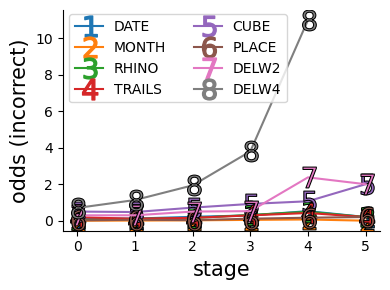

In [40]:
flds = ["TRAILS","CUBE","CLOCKCON","CLOCKNO","CLOCKHAN","LION","RHINO","CAMEL","IMMT1W1",
        "IMMT1W2","IMMT1W3","IMMT1W4","IMMT1W5","IMMT2W1","IMMT2W2","IMMT2W3","IMMT2W4",
        "IMMT2W5","DIGFOR","DIGBACK","LETTERS","SERIAL1","SERIAL2","SERIAL3","SERIAL4","SERIAL5",
        "REPEAT1","REPEAT2","FFLUENCY","ABSTRAN","ABSMEAS","DELW1","DELW2","DELW3","DELW4","DELW5",
        "DATE","MONTH","YEAR","DAY","PLACE","CITY"]

# binary = ["TRAILS","CUBE","CLOCKCON","CLOCKNO","CLOCKHAN","LION","RHINO","CAMEL","IMMT1W1",
#         "IMMT1W2","IMMT1W3","IMMT1W4","IMMT1W5","IMMT2W1","IMMT2W2","IMMT2W3","IMMT2W4",
#         "IMMT2W5","DIGFOR","DIGBACK", "SERIAL1","SERIAL2","SERIAL3","SERIAL4","SERIAL5",
#           "DELW1","DELW2","DELW3","DELW4","DELW5",
#         "REPEAT1","REPEAT2","ABSTRAN","ABSMEAS", "DATE","MONTH","YEAR","DAY","PLACE","CITY"]
binary = ["DATE", "MONTH", "RHINO", "TRAILS", "CUBE", "PLACE", "DELW2", "DELW4"]
test_name = "MOCA_test"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = process_df(df_mh, fld)
    print(fld, "Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
fig, ax = plt.subplots(figsize=(4,3))

markers = ['${}$'.format(_+1) for _ in range(len(binary))]
sns.lineplot(data=ratio_df[binary], ax = ax, dashes=False, markers=markers, markersize=15, mec="k")
lgnd = plt.legend(bbox_to_anchor=(0.02, 0.98), loc='upper left', borderaxespad=0, ncol=2)
for m_ in range(len(markers)):
    lgnd.legendHandles[m_].set_markersize(15)
# ax.set_ylim([0,1])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel("odds (incorrect)", fontsize=15)
ax.set_xlabel("stage", fontsize=15)
fig.tight_layout()

# fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)



In [41]:
moca_cube = ratio_df["CUBE"]

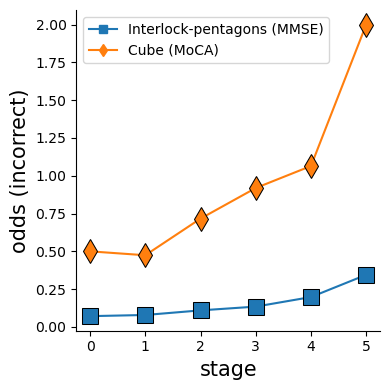

In [46]:
test_name = "cube_pent"
cube_pent_data = pd.concat([mmdraw,moca_cube],axis=1)
cube_pent_data.columns = ["Interlock-pentagons (MMSE)", "Cube (MoCA)"]
fig, ax = plt.subplots(1,1,figsize=(4,4))
sns.lineplot(data=cube_pent_data,dashes=False, markers=["s","d"], markersize=12, mec="k",ax=ax)
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel("odds (incorrect)", fontsize=15)
ax.set_xlabel("stage", fontsize=15)
ax.set_xticks([0,1,2,3,4,5])
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)

In [477]:
dir_path

'/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery'

In [464]:
mmdraw

stage
0    0.071429
1    0.079096
2    0.109589
3    0.134454
4    0.197674
5    0.344828
Name: MMDRAW, dtype: float64

,p-vals,coef,std-err,conf-int-lower95,conf-int-upper95,fld,r-sq-adj,f-pvalue
const,0.060081,1.705743,0.904903,-0.072670,3.484157,LETTERS,0.022383,0.020322
PTGENDER,0.227392,0.187934,0.155475,-0.117623,0.493491,LETTERS,0.022383,0.020322
APOE4,0.215142,-0.130847,0.105410,-0.338010,0.076316,LETTERS,0.022383,0.020322
PTEDUCAT,0.003364,-0.078436,0.026604,-0.130722,-0.026150,LETTERS,0.022383,0.020322
AGE,0.932400,-0.000958,0.011290,-0.023146,0.021230,LETTERS,0.022383,0.020322
stage,0.188643,0.078612,0.059708,-0.038731,0.195956,LETTERS,0.022383,0.020322
st1,0.499112,-0.129703,0.191743,-0.506537,0.247131,LETTERS,0.022383,0.020322
st2,0.116862,0.351958,0.224015,-0.088301,0.792218,LETTERS,0.022383,0.020322
st3,0.371910,-0.189485,0.211998,-0.606127,0.227157,LETTERS,0.022383,0.020322


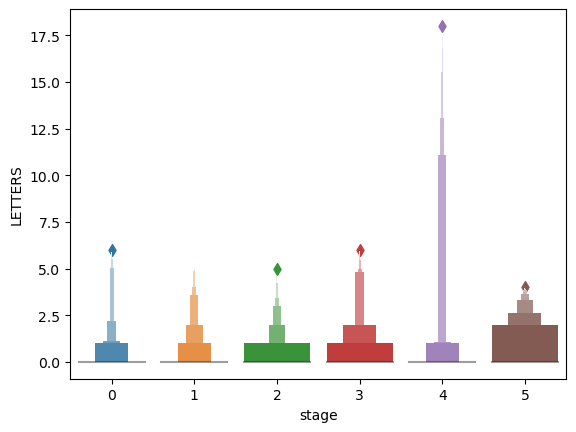

In [313]:
fld = "LETTERS"
df_mh_fld = process_df(df_mh, fld)
sns.boxenplot(data=df_mh_fld, x="stage", y=fld)
df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
df_xx.dropna(inplace=True)
stats_df1 = regress_OLS(df_xx, fld, cov1)
stats_df1

In [314]:
flds = ["TRAILS","CUBE","CLOCKCON","CLOCKNO","CLOCKHAN","LION","RHINO","CAMEL","IMMT1W1",
        "IMMT1W2","IMMT1W3","IMMT1W4","IMMT1W5","IMMT2W1","IMMT2W2","IMMT2W3","IMMT2W4",
        "IMMT2W5","DIGFOR","DIGBACK", "SERIAL1","SERIAL2","SERIAL3","SERIAL4","SERIAL5",
        "DELW1","DELW2","DELW3","DELW4","DELW5",
        "REPEAT1","REPEAT2","ABSTRAN","ABSMEAS", "DATE","MONTH","YEAR","DAY","PLACE","CITY"]
test_name = "moca_test"
stats_df_list = []
for fld in flds:
    df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
    df_xx.dropna(inplace=True)
    stats_df1 = regress_Logit(df_xx, fld, cov1)
    stats_df1["n-cov"] = "incl-sustain"
    stats_df2 = regress_Logit(df_xx, fld, cov2)
    stats_df2["n-cov"] = "excl-sustain"
    stats_df_list += [stats_df1, stats_df2]
stats_df_all = pd.concat(stats_df_list, axis=0)
dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
stats_df_all.to_csv(os.path.join(dir_path,"stats_{}.csv".format(test_name)))

Optimization terminated successfully.
         Current function value: 0.406006
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415440
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.651235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658293
         Iterations 4
         Current function value: 0.065978
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.076194
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415543
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.553704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559670
         Iterations 5
Optimization ter

ValueError: endog must be in the unit interval.

In [315]:
fld = "LETTERS"
df_xx = regress_score(df_mh, fld, ["AGE", "PTGENDER", "PTEDUCAT", "APOE4","stage"])
# df_xx = df_xx[df_xx[fld].isin([0,1])]
df_xx.dropna(inplace=True)
regress_OLS(df_xx, fld, cov1), regress_OLS(df_xx, fld, cov2) 

(            p-vals      coef   std-err  conf-int-lower95  conf-int-upper95  \
 const     0.060081  1.705743  0.904903         -0.072670          3.484157   
 PTGENDER  0.227392  0.187934  0.155475         -0.117623          0.493491   
 APOE4     0.215142 -0.130847  0.105410         -0.338010          0.076316   
 PTEDUCAT  0.003364 -0.078436  0.026604         -0.130722         -0.026150   
 AGE       0.932400 -0.000958  0.011290         -0.023146          0.021230   
 stage     0.188643  0.078612  0.059708         -0.038731          0.195956   
 st1       0.499112 -0.129703  0.191743         -0.506537          0.247131   
 st2       0.116862  0.351958  0.224015         -0.088301          0.792218   
 st3       0.371910 -0.189485  0.211998         -0.606127          0.227157   
 
               fld  r-sq-adj  f-pvalue  
 const     LETTERS  0.022383  0.020322  
 PTGENDER  LETTERS  0.022383  0.020322  
 APOE4     LETTERS  0.022383  0.020322  
 PTEDUCAT  LETTERS  0.022383  0.020322  
 AG

In [316]:
Counter(df_xx["DELW1"])

KeyError: 'DELW1'

# PDXCONV

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "DXSUM_PDXCONV_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [ ]:
flds = ["DXMPTR1","DXMPTR2","DXMPTR3","DXMPTR4","DXMPTR5","DXMPTR6", "DXMDUE", "DXMOTHET", "DXDSEV", "DXDDUE",
        "DXAPP", "DXAPOSS", "DXODES", "DXDEP", "DXPARK", "DXPATYP"]

binary = ["DXMPTR1","DXMPTR2","DXMPTR3","DXMPTR4","DXMPTR5","DXMPTR6"]
test_name = "pdxconv"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print(fld, "Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["subtype", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
fig, ax = plt.subplots(figsize=(10,5))

markers = ['${}$'.format(_) for _ in range(len(binary))]
sns.lineplot(data=ratio_df, ax = ax, dashes=False, markers=markers, markersize=15, mec="k")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, ncols=2)
# ax.set_ylim([0,1])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)



In [ ]:
neurobat_df

In [ ]:
multipletests(neurobat_df["chi-2-pval"],0.05,"fdr_bh")

In [ ]:
fld = "DXMPTR1"
df_mh_fld = df_mh.dropna(subset=[fld])
df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
print(fld, "Shape", df_mh_fld.shape)
chi2_table = df_mh_fld.groupby(["subtype", fld]).size().unstack(level=1).fillna(0)
chi2_table

# ECOGPT Results

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "ECOGPT_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [ ]:
# flds = ["VISSPAT1", "VISSPAT2", "VISSPAT3", "VISSPAT4", "VISSPAT5", "VISSPAT6", "VISSPAT7", "VISSPAT8"]
# flds = ["LANG1", "LANG2", "LANG3","LANG4","LANG5","LANG6","LANG7","LANG8"]
# flds = ["MEMORY1", "MEMORY2", "MEMORY3", "MEMORY4", "MEMORY5", "MEMORY6", "MEMORY7", "MEMORY8"]
flds = ["PLAN1", "PLAN2", "PLAN3", "PLAN4", "PLAN5", "ORGAN1", "ORGAN2", "ORGAN3", "ORGAN4", "ORGAN5", "ORGAN6", "DIVATT1",
 "DIVATT2", "DIVATT3", "DIVATT4"]
binary = []
test_name = "ecogpt"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print(fld, "Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))


In [ ]:
neurobat_df

In [ ]:
fld = "ORGAN4"
df_mh_fld = df_mh.dropna(subset=[fld])
df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
print(fld, "Shape", df_mh_fld.shape)
chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
chi2_stats = chi2_contingency(chi2_table)
chi2_pval = chi2_stats[1]

In [ ]:
chi2_table

In [ ]:
neurobat_df

# ADAS

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "ADAS_ADNI1_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess["VISCODE"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(df_long_mci_subset, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)

In [ ]:
flds = ["COT1SCOR", "COT2SCOR", "COT3SCOR", "COP7COMP","CO8NURSE","CO8MAGAZ","CO8WIZRD","CO8WIZRR","CO8VAN","CO8VANR","CO8LEPRD","CO8LEPRR"]
binary = []
test_name = "adas"
neurobat_dict = {}
ratio_df = pd.DataFrame()
for fld in flds:
    df_mh_fld = df_mh.dropna(subset=[fld])
    df_mh_fld.sort_values(["sid", "EXAMDATE"], inplace=True)
    df_mh_fld.drop_duplicates("sid", keep="first", inplace=True)
    print(fld, "Shape", df_mh_fld.shape)
    chi2_table = df_mh_fld.groupby(["stage", fld]).size().unstack(level=1).fillna(0)
    chi2_stats = chi2_contingency(chi2_table)
    chi2_pval = chi2_stats[1]
    if fld in binary:
        ratio = chi2_table[0]/chi2_table[1]
        ratio_df[fld] = ratio
    spearmanr_corr = spearmanr(df_mh_fld["stage"], df_mh_fld[fld]).correlation
    neurobat_dict[fld] = [chi2_pval, spearmanr_corr]

dir_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery"
neurobat_df = pd.DataFrame.from_dict(neurobat_dict, orient="index", columns = ["chi-2-pval", "spearmanr"])
fig, ax = plt.subplots(figsize=(10,5))

markers = ['${}$'.format(_) for _ in range(len(binary))]
sns.lineplot(ratio_df, ax = ax, dashes=False, markers=markers, markersize=15, mec="k")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, ncols=2)
# ax.set_ylim([0,1])
neurobat_df.to_csv(os.path.join(dir_path, "{}_df.csv".format(test_name)))
fig.tight_layout()
fig.savefig(os.path.join(dir_path, "{}.png").format(test_name), dpi=300)



In [ ]:
neurobat_df

# Comorbidity Analysis

## APOE4 genotype across subtypes

In [ ]:
df_apoe4 = df_adnimerge[["PTID", "APOE4"]].dropna().sort_values("PTID").drop_duplicates("PTID", keep="first")
df_mh = pd.merge(final_df, df_apoe4, on=["PTID"], how="inner", suffixes=[None, "_y"])

In [ ]:
chi2_table = df_mh.groupby(["subtype", "APOE4"]).size().unstack(level=1)
chi2_contingency(chi2_table.values)


# Medical History

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/medical_history/"
file_name = "MEDHIST_12Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess.drop_duplicates("RID", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])


In [ ]:
# fields_test = ["MHPSYCH", "MH2NEURL", "MH3HEAD", "MH4CARD", "MH6HEPAT", "MH7DERM", "MH8MUSCL", "MH9ENDO", "MH10GAST", "MH11HEMA", "MH12RENA", "MH13ALLE", 
#                "MH14ALCH", "MH15DRUG", "MH16SMOK", "MH17MALI", "MH18SURG"]
fields_test = ["MHPSYCH", "MH2NEURL", "MH3HEAD", "MH4CARD", "MH6HEPAT", "MH7DERM", "MH9ENDO", "MH11HEMA", "MH12RENA", 
               "MH14ALCH", "MH16SMOK", "MH17MALI"]

ft = "MH19OTHR"
chi2_table = df_mh.groupby(["subtype", ft]).size().unstack(level=1)
print(chi2_table, "\n\n")
print(chi2_contingency(chi2_table.values))


In [ ]:
# fields_test = ["MHPSYCH", "MH2NEURL", "MH3HEAD", "MH4CARD", "MH6HEPAT", "MH7DERM", "MH8MUSCL", "MH9ENDO", "MH10GAST", "MH11HEMA", "MH12RENA", "MH13ALLE", 
#                "MH14ALCH", "MH15DRUG", "MH16SMOK", "MH17MALI", "MH18SURG"]
fields_test = ["MHPSYCH", "MH2NEURL", "MH3HEAD", "MH4CARD", "MH6HEPAT", "MH7DERM", "MH9ENDO", "MH11HEMA", "MH12RENA", 
               "MH14ALCH", "MH16SMOK", "MH17MALI"]
mh_dict = {}
for ft in fields_test:
    
    chi2_table = df_mh.groupby(["subtype", ft]).size().unstack(level=1)
    p_val = chi2_contingency(chi2_table.values)[1]
    st_max = (chi2_table[1]/chi2_table[0]).argmax()
    st_min = (chi2_table[1]/chi2_table[0]).argmin()
    mh_dict[ft] = (p_val, st_max, st_min)
    
    

In [ ]:
fig_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/"
mh_df = pd.DataFrame.from_dict(mh_dict, orient="index")
mh_df.columns = ["p-vals", "st_max", "st_min"]
mh_df.sort_values("p-vals", inplace=True)

# mh_df.to_csv(os.path.join(fig_path, "comorbidities_MEDHIST.csv"))


In [ ]:
p_vec1 = mh_df["p-vals"].sort_values()
p_vec2 = np.arange(1, p_vec1.shape[0]+1)

In [ ]:
from statsmodels.stats.multitest import fdrcorrection

In [ ]:
multipletests(mh_df["p-vals"], method="fdr_bh", alpha=0.1)[1]

In [ ]:
mh_df["adj-p"] = multipletests(mh_df["p-vals"], method="fdr_bh", alpha=0.1)[1]

In [ ]:
mh_df

In [ ]:
ft = "MH17MALI"
chi2_table = df_mh.groupby(["subtype", ft]).size().unstack(level=1)
chi2_table["odds"] = chi2_table[1]/chi2_table[0]
chi2_table

In [ ]:
chi2_contingency(chi2_table)

In [ ]:
df_mh

In [ ]:
np.arange(1,10)

In [ ]:
multipletests(mh_df["p-vals"], 0.05, "fdr_bh")

# Subject Characteristics

## Parents history - not very useful (FAMHXPAR)

## Sibling History and parent history shows no effects

## Patient demographics

In [ ]:
final_df

## marriage and gender

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/subject_characteristics/"
file_name = "PTDEMOG_11May2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(final_df, df_assess, left_on=["RID", "VISCODE"], 
         right_on=["RID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1,9999],np.nan, inplace=True)

# df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])
# df_mh.replace([-4,-1,9999], np.nan, inplace=True)

In [ ]:
# PTMARRY, PTNOTRT
fields_test = ["PTGENDER", "PTHAND", "PTEDUCAT", "PTWORKHS",
               "PTNOTRT", "PTTLANG", "PTETHCAT", "PTRACCAT", "PTMARRY", "PTHOME"]
mh_dict = {}
for ft in fields_test:
    df_mh_fld = df_mh.dropna(subset=ft)
    chi2_table = df_mh_fld.groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
    p_val = chi2_contingency(chi2_table.values)[1]
#     st_max = (chi2_table[2]/chi2_table[1]).argmax()
#     st_min = (chi2_table[2]/chi2_table[1]).argmin()
    mh_dict[ft] = p_val
mh_df = pd.DataFrame.from_dict(mh_dict, orient="index")
mh_df.columns = ["p-vals"]
mh_df.sort_values("p-vals", inplace=True)
# _ = "PTNOTRT"
# df_mh_fld = df_mh.dropna(subset=[_])
# df_mh_fld.drop_duplicates("RID", keep="first",inplace=True)
# chi2_table = df_mh_fld.groupby(["subtype", _]).size().unstack(level=1).fillna(0)
# p_val = chi2_contingency(chi2_table.values)[1]
# chi2_table, p_val

In [ ]:
mh_df["adj-pval"] = multipletests(mh_df["p-vals"], 0.1, "fdr_bh")[1]
mh_df

In [ ]:
ft = "PTNOTRT"
df_mh_fld = df_mh.dropna(subset=ft)
chi2_table = df_mh_fld.groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
print(chi2_table, "\n\n")
chi2_contingency(chi2_table[[0,1]])
# print(chi2_table,"\n\n")
# print(chi2_table.T.div(chi2_table.sum(axis=0), axis=0))

In [ ]:
df_mh_fld

In [ ]:
ft = "PTMARRY"
df_mh_fld = df_mh.dropna(subset=ft)
chi2_table = df_mh_fld.groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
# print(chi2_table,"\n\n")
chi2_table["no"] = chi2_table[[2,3,4,5]].sum(axis=1)
chi2_marry = chi2_table[[1.0, "no"]]
chi2_marry.div(chi2_marry.sum(axis=1), axis=0)

# PTCOGBEG, PTADBEG - beginning of cog decline and AD

In [413]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/subject_characteristics/"
file_name = "PTDEMOG_11May2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1,9999],np.nan, inplace=True)

In [414]:
df_mh["PTADDX"].fillna(df_mh["PTADBEG"], inplace=True)
cnad_ptid = df_cnad["PTID"].unique().tolist()
mci_ptid = df_mci["PTID"].unique().tolist()
cn_ptid = df_cnad[df_cnad["DX"].isin(["CN"])]["PTID"].unique().tolist()
ad_ptid = df_cnad[df_cnad["DX"].isin(["Dementia"])]["PTID"].unique().tolist()

In [415]:
fld = "PTCOGBEG"
ptid_list = cnad_ptid + mci_ptid
df_mh_subset = df_mh[df_mh["PTID"].isin(ptid_list)]
df_mh_subset.dropna(subset=fld, inplace=True)
df_mh_subset.sort_values(["PTID", "VISDATE"], inplace=True)
df_mh_subset.drop_duplicates("PTID",keep="first",inplace=True)
cogbeg_dict = dict(zip(df_mh_subset["PTID"], df_mh_subset[fld]))

fld = "PTADDX"
df_mh_subset = df_mh[df_mh["PTID"].isin(ptid_list)]
df_mh_subset.dropna(subset=fld, inplace=True)
df_mh_subset.sort_values(["PTID", "VISDATE"], inplace=True)
df_mh_subset.drop_duplicates("PTID",keep="first",inplace=True)
adbeg_dict = dict(zip(df_mh_subset["PTID"], df_mh_subset[fld]))

In [416]:

df_temp = final_df.merge(df_long, left_on=["PTID", "EXAMDATE"], right_on=["PTID", "EXAMDATE"], how="inner", suffixes=[None,"_y"])
df_temp = df_temp[["PTID", "subtype", "stage", "APOE4", "PTGENDER", "PTEDUCAT"]]
df_temp["PTGENDER"] = df_temp["PTGENDER"].map({"Male":1, "Female":0})
# df_long.sort_valuesdrop_duplicates( ["APOE4"]

In [417]:
cogbeg_df = pd.DataFrame.from_dict(cogbeg_dict, orient="index", columns=["cogbeg"])
adbeg_df = pd.DataFrame.from_dict(adbeg_dict, orient="index", columns=["adbeg"])
df_beg = cogbeg_df.merge(adbeg_df, left_index=True, right_index=True, how="outer")
df_beg = df_beg.merge(df_mh[["PTID", "PTDOBYY"]].dropna(subset="PTDOBYY").drop_duplicates("PTID"), 
             left_index=True, right_on="PTID", how="inner")

# df_beg = df_beg.merge(final_df, left_on="PTID", right_on="PTID", how="inner")
df_beg = df_beg.merge(df_temp, left_on="PTID", right_on="PTID", how="inner")
df_beg["subtype"] = df_beg["subtype"].astype(int)
df_beg["subtype"] += 1
df_beg["AGEADBEG"] = df_beg["adbeg"] - df_beg["PTDOBYY"]
df_beg["AGECOGBEG"] = df_beg["cogbeg"] - df_beg["PTDOBYY"]
df_beg_ad = df_beg.dropna(subset="AGEADBEG")
df_beg_cog = df_beg.dropna(subset="AGECOGBEG")
df_beg_ad.rename(columns={"AGEADBEG":"age"}, inplace=True)
df_beg_ad["onset"] = "AD onset"
df_beg_cog.rename(columns={"AGECOGBEG":"age"}, inplace=True)
df_beg_cog["onset"] = "cognitive symptoms"




In [418]:
df_beg_cog

,cogbeg,adbeg,PTID,PTDOBYY,subtype,stage,APOE4,PTGENDER,PTEDUCAT,AGEADBEG,age,onset
1,2005.0,2009.0,002_S_0729,1941.0,1,4.0,1.0,0,16,68.0,64.0,cognitive symptoms
6,2001.0,NaN,002_S_1155,1949.0,2,1.0,0.0,1,20,NaN,52.0,cognitive symptoms
7,2007.0,NaN,002_S_1268,1924.0,3,3.0,1.0,1,20,NaN,83.0,cognitive symptoms
8,2008.0,NaN,002_S_2010,1947.0,4,1.0,1.0,0,20,NaN,61.0,cognitive symptoms
9,2005.0,NaN,002_S_2043,1938.0,3,1.0,1.0,0,20,NaN,67.0,cognitive symptoms
...,...,...,...,...,...,...,...,...,...,...,...,...
959,1997.0,NaN,941_S_4036,1937.0,4,1.0,0.0,1,20,NaN,60.0,cognitive symptoms
960,2006.0,NaN,941_S_4187,1949.0,1,0.0,0.0,1,16,NaN,57.0,cognitive symptoms
961,2008.0,NaN,941_S_4377,1942.0,1,3.0,1.0,0,12,NaN,66.0,cognitive symptoms
962,2010.0,NaN,941_S_4420,1930.0,1,0.0,0.0,1,18,NaN,80.0,cognitive symptoms


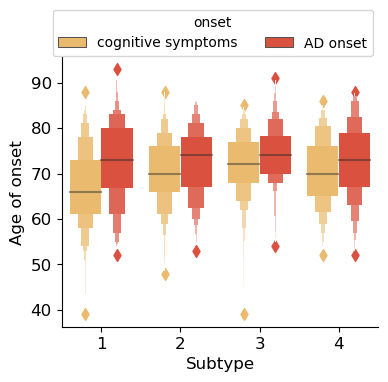

In [419]:
fig, ax = plt.subplots(figsize=(4,4))
sns.boxenplot(data=pd.concat([df_beg_cog, df_beg_ad], axis=0), 
              x="subtype", y="age", hue="onset", orient="v",
             palette=palette_color1, linewidth=1.5, color="g")
ax.set_xlabel("Subtype", fontsize=12)
ax.set_ylabel("Age of onset", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines[['right', 'top']].set_visible(False)
ax.legend(ncols=2, title="onset",loc='upper left', bbox_to_anchor=(-.05, 1.2))
fig.tight_layout()
fig.savefig(os.path.join("/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4",
                         "age-onset.png"), dpi=300)


## Age of cognitive symptom onset adjusted for gender, education, and APOE4 

KruskalResult(statistic=37.420072991493434, pvalue=3.749726820278805e-08)

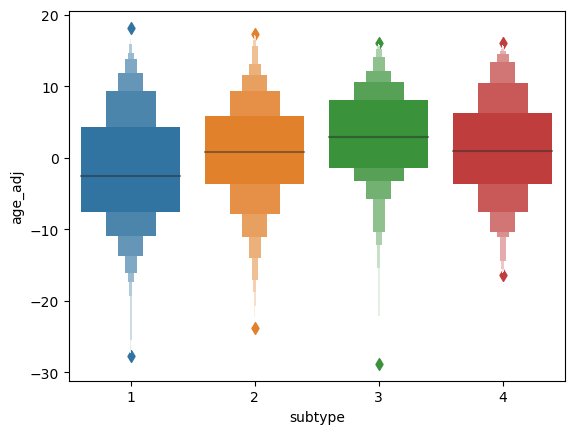

In [336]:
df_regress = df_beg_cog.dropna(subset=["age", "APOE4", "PTGENDER", "PTEDUCAT"])
model = sm.OLS(df_regress[["age"]], sm.add_constant(df_regress[["APOE4", "PTGENDER", "PTEDUCAT"]]))
result = model.fit()
df_regress["age_adj"] = result.resid
sns.boxenplot(data=df_regress, x="subtype", y="age_adj")
kruskal(*[group["age_adj"].values for name, group in df_regress.groupby("subtype")])

## Age of AD diagnosis adjusted for gender, education, and APOE4 

KruskalResult(statistic=3.838909844308938, pvalue=0.27939258728203964)

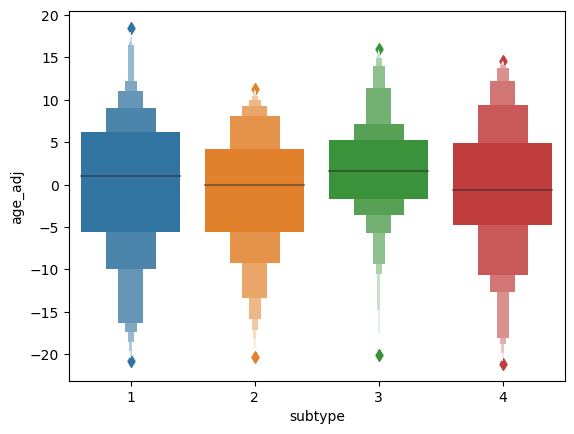

In [337]:
df_regress = df_beg_ad.dropna(subset=["age", "APOE4", "PTGENDER", "PTEDUCAT"])
model = sm.OLS(df_regress[["age"]], sm.add_constant(df_regress[["APOE4", "PTGENDER", "PTEDUCAT"]]))
result = model.fit()
df_regress["age_adj"] = result.resid
sns.boxenplot(data=df_regress, x="subtype", y="age_adj")
kruskal(*[group["age_adj"].values for name, group in df_regress.groupby("subtype")])

In [340]:
df_beg

,cogbeg,adbeg,PTID,PTDOBYY,subtype,stage,APOE4,PTGENDER,PTEDUCAT,AGEADBEG,AGECOGBEG
0,NaN,1993.0,002_S_0619,1928.0,2,3.0,2.0,1,12,65.0,NaN
1,2005.0,2009.0,002_S_0729,1941.0,1,4.0,1.0,0,16,68.0,64.0
2,NaN,2005.0,002_S_0816,1935.0,3,2.0,2.0,1,20,70.0,NaN
3,NaN,1998.0,002_S_0938,1924.0,4,4.0,0.0,0,16,74.0,NaN
4,NaN,2001.0,002_S_0955,1928.0,1,5.0,1.0,0,16,73.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
959,1997.0,NaN,941_S_4036,1937.0,4,1.0,0.0,1,20,NaN,60.0
960,2006.0,NaN,941_S_4187,1949.0,1,0.0,0.0,1,16,NaN,57.0
961,2008.0,NaN,941_S_4377,1942.0,1,3.0,1.0,0,12,NaN,66.0
962,2010.0,NaN,941_S_4420,1930.0,1,0.0,0.0,1,18,NaN,80.0


p-value annotation legend:
      ns: 1.00e-04 < p <= 1.00e+00
       *: 1.00e-06 < p <= 1.00e-04
      **: 1.00e-08 < p <= 1.00e-06
     ***: 1.00e-10 < p <= 1.00e-08
    ****: p <= 1.00e-10

1 vs. 2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.487e-06 U_stat=2.438e+04
2 vs. 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.948e-02 U_stat=8.772e+03
3 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.710e-01 U_stat=7.782e+03
1 vs. 3: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.075e-08 U_stat=1.334e+04
2 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.999e-01 U_stat=1.106e+04
1 vs. 4: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.093e-05 U_stat=1.724e+04


KruskalResult(statistic=43.1686466391393, pvalue=2.2662292555206573e-09)

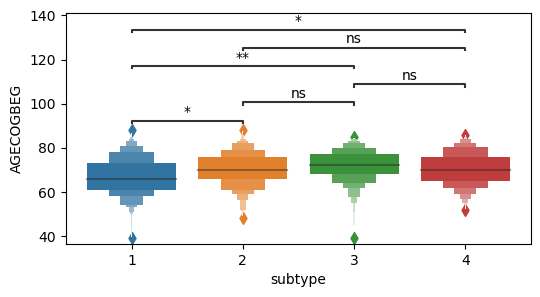

In [341]:
_="AGECOGBEG"
pairs = [(1,2),(2,3),(3,4),(1,3),(1,4),(2,4)]
fig, ax = plt.subplots(1,1, figsize=(6,3), sharey=True)
df_mh_cog = df_beg.dropna(subset=[_])
df_mh_cog["onset"] = "cognitive-decline"
sns.boxenplot(data=df_mh_cog, x="subtype", y=_, ax=ax)
annotator = Annotator(ax, pairs, data=df_mh_cog, x="subtype", y=_)
annotator._pvalue_format.pvalue_thresholds =  [[1e-4, '*'], [1e-6, '**'], [1e-8, '***'], [1e-10, '****'], [1, 'ns']]
annotator.configure(test='Mann-Whitney', text_format='star', 
                    loc='inside',comparisons_correction="Benjamini-Hochberg")
annotator.apply_and_annotate()
kruskal(*[group[_].values for name, group in df_mh_cog.groupby("subtype")])

KruskalResult(statistic=2.6798934958500427, pvalue=0.4436550051899343)

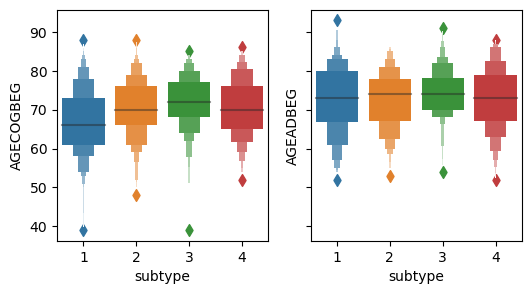

In [342]:
_="AGECOGBEG"
fig, ax = plt.subplots(1,2, figsize=(6,3), sharey=True)
df_mh_cog = df_beg.dropna(subset=[_])
# df_mh_cog.drop_duplicates("PTID",keep="first",inplace=True)
df_mh_cog["onset"] = "cognitive-decline"
sns.boxenplot(data=df_mh_cog, x="subtype", y=_, ax=ax[0])
# ax.set_ylim([40,90])
kruskal(*[group[_].values for name, group in df_mh_cog.groupby("subtype")])

_="AGEADBEG"
df_mh_ad = df_beg.dropna(subset=[_])
# df_mh_ad.drop_duplicates("PTID",keep="first", inplace=True)
df_mh_ad["onset"] = "AD"
sns.boxenplot(data=df_mh_ad, x="subtype", y=_, ax=ax[1])
# ax.set_ylim([40,90])
kruskal(*[group[_].values for name, group in df_mh_ad.groupby("subtype")])

In [343]:
df_mh_ad.groupby("subtype")["AGEADBEG"].median() - df_mh_cog.groupby("subtype")["AGECOGBEG"].median()


subtype
1    7.0
2    4.0
3    2.0
4    3.0
dtype: float64

In [344]:
df_mh["AGEADBEG"] = df_mh["PTADDX"] - df_mh["PTDOBYY"]
df_mh["AGECOGBEG"] = df_mh["PTCOGBEG"] - df_mh["PTDOBYY"]

KruskalResult(statistic=2.6798934958500427, pvalue=0.4436550051899343)

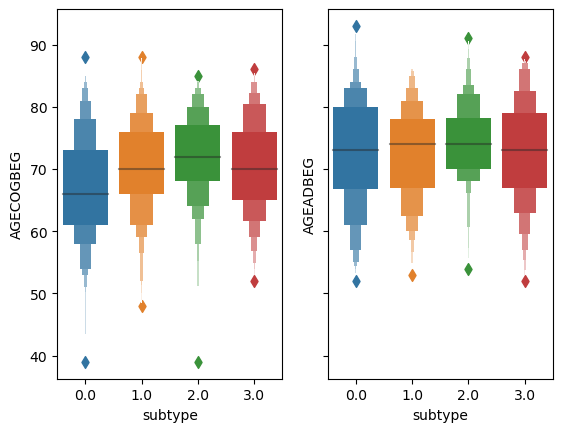

In [345]:
_="AGECOGBEG"
fig, ax = plt.subplots(1,2, sharey=True)
df_mh_cog = df_mh.dropna(subset=[_])
df_mh_cog.drop_duplicates("PTID",keep="first",inplace=True)
df_mh_cog["onset"] = "cognitive-decline"
sns.boxenplot(data=df_mh_cog, x="subtype", y=_, ax=ax[0])
# ax.set_ylim([40,90])
kruskal(*[group[_].values for name, group in df_mh_cog.groupby("subtype")])

_="AGEADBEG"
df_mh_ad = df_mh.dropna(subset=[_])
df_mh_ad.drop_duplicates("PTID",keep="first", inplace=True)
df_mh_ad["onset"] = "AD"
sns.boxenplot(data=df_mh_ad, x="subtype", y=_, ax=ax[1])
# df_mh_fld_ad["onset"] = "AD"
# ax.set_ylim([40,90])
kruskal(*[group[_].values for name, group in df_mh_ad.groupby("subtype")])

KruskalResult(statistic=2.6798934958500427, pvalue=0.4436550051899343)

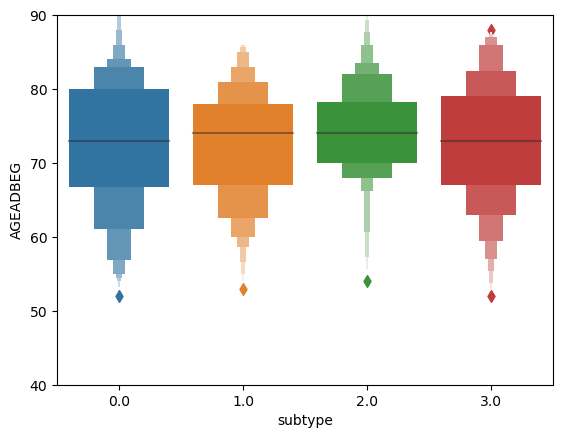

In [346]:
_="AGEADBEG"
fig, ax = plt.subplots()
df_mh_ad = df_mh.dropna(subset=[_])
df_mh_ad.drop_duplicates("PTID",keep="first", inplace=True)
df_mh_ad["onset"] = "AD"
sns.boxenplot(data=df_mh_ad, x="subtype", y=_, ax=ax)
# df_mh_fld_ad["onset"] = "AD"
ax.set_ylim([40,90])
kruskal(*[group[_].values for name, group in df_mh_ad.groupby("subtype")])

<AxesSubplot: xlabel='subtype', ylabel='AGEADBEG'>

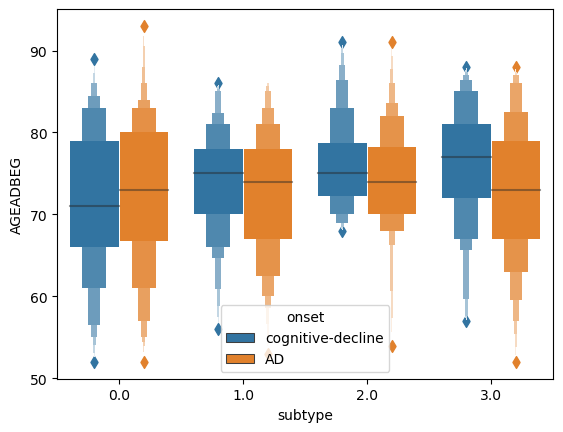

In [347]:
df_onset = pd.concat([df_mh_cog, df_mh_ad], axis=0)
sns.boxenplot(data=df_onset, x="subtype", y=_, hue="onset")

In [348]:
df_onset

,subtype,stage,DX,PTID,EXAMDATE,VISCODE,RID,PHASE,PTID_y,VISCODE_y,...,SITEID,USERDATE,USERDATE2,DD_CRF_VERSION_LABEL,LANGUAGE_CODE,HAS_QC_ERROR,update_stamp,AGEADBEG,AGECOGBEG,onset
27,0.0,0.0,AD,002_S_5018,2012-11-15,bl,5018,ADNI2,002_S_5018,v01,...,1,2012-10-29,NaN,NaN,NaN,NaN,2013-05-30 10:05:05.0,73.0,69.0,cognitive-decline
28,2.0,1.0,Controls,002_S_5178,2013-05-28,bl,5178,ADNI2,002_S_5178,v01,...,1,2013-05-08,NaN,NaN,NaN,NaN,2013-05-30 10:05:05.0,NaN,66.0,cognitive-decline
30,0.0,2.0,Controls,002_S_5256,2013-07-30,bl,5256,ADNI2,002_S_5256,v01,...,1,2013-07-02,NaN,NaN,NaN,NaN,2013-07-03 19:18:57.0,NaN,68.0,cognitive-decline
45,1.0,2.0,AD,003_S_4136,2011-08-23,bl,4136,ADNI2,003_S_4136,v01,...,2,2011-07-27,NaN,NaN,NaN,NaN,2013-05-30 10:05:05.0,66.0,66.0,cognitive-decline
46,3.0,1.0,AD,003_S_4152,2011-09-27,bl,4152,ADNI2,003_S_4152,v01,...,2,2011-07-27,2011-08-02,NaN,NaN,NaN,2013-05-30 10:05:05.0,57.0,56.0,cognitive-decline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2368,1.0,3.0,MCI,137_S_0973,2007-05-22,m06,973,ADNIGO,137_S_0973,sc,...,55,2010-12-06,2011-03-09,NaN,NaN,NaN,2012-11-16 09:42:47.0,80.0,75.0,AD
2383,0.0,4.0,MCI,137_S_4815,2012-09-04,bl,4815,ADNI2,137_S_4815,v01,...,55,2012-06-20,2012-08-30,NaN,NaN,NaN,2013-05-30 10:05:05.0,69.0,69.0,AD
2390,2.0,4.0,MCI,141_S_0697,2006-09-14,bl,697,ADNI2,141_S_0697,v06,...,56,2011-10-20,2013-10-09,NaN,NaN,NaN,2013-10-09 19:19:30.0,91.0,76.0,AD
2393,0.0,4.0,MCI,141_S_0915,2006-10-31,bl,915,ADNI2,141_S_0915,v06,...,56,2012-01-11,NaN,NaN,NaN,NaN,2013-05-30 10:05:05.0,84.0,79.0,AD


In [349]:
# fig, ax = plt.subplots(1,2,figsize=(6,3))
df_mh_cog_beg = df_mh.dropna(subset=["AGECOGBEG"])
# sns.boxenplot(data=df_mh_fld, x="subtype", y=_, ax = ax[0])
# kruskal(*[group[_].values for name, group in df_mh_fld.groupby("subtype")])
df_mh_ad_beg = df_mh.dropna(subset=["AGEADBEG"])



In [350]:
df_assess

,PHASE,PTID,RID,VISCODE,VISCODE2,VISDATE,PTSOURCE,PTGENDER,PTDOB,PTDOBYY,...,PTBIRPR,PTBIRGR,ID,SITEID,USERDATE,USERDATE2,DD_CRF_VERSION_LABEL,LANGUAGE_CODE,HAS_QC_ERROR,update_stamp
1,ADNI1,022_S_0001,1,f,f,2005-08-18,1.0,2.0,12/1944,1944.0,...,NaN,NaN,20,10,2005-08-18,NaN,NaN,NaN,NaN,2005-08-18 00:00:00.0
0,ADNI1,011_S_0002,2,sc,bl,2005-08-17,1.0,1.0,04/1931,1931.0,...,NaN,NaN,18,107,2005-08-17,NaN,NaN,NaN,NaN,2005-08-17 00:00:00.0
1571,ADNIGO,011_S_0002,2,sc,bl,2010-09-22,1.0,1.0,04/1931,1931.0,...,NaN,NaN,304,8,2010-09-22,NaN,NaN,NaN,NaN,2013-03-22 15:23:58.0
2404,ADNI2,011_S_0002,2,v06,m72,2011-09-19,1.0,1.0,04/1931,1931.0,...,NaN,NaN,636,8,2011-09-20,NaN,NaN,NaN,NaN,2013-05-30 10:05:05.0
2,ADNI1,011_S_0003,3,sc,bl,2005-08-18,1.0,1.0,05/1924,1924.0,...,NaN,NaN,22,107,2005-08-18,NaN,NaN,NaN,NaN,2005-08-18 00:00:00.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5057,ADNI4,941_S_10111,10111,4_sc,NaN,2024-04-25,1.0,2.0,12/1953,1953.0,...,0.0,0.0,14253,941,2024-04-26,2024-04-26,v1,e,0.0,2024-04-27 01:40:12.0
5062,ADNI4,036_S_10112,10112,4_sc,NaN,2024-04-29,1.0,1.0,08/1953,1953.0,...,0.0,0.0,14565,36,2024-04-29,2024-04-29,v1,e,0.0,2024-04-30 01:40:49.0
5063,ADNI4,073_S_10113,10113,4_sc,NaN,2024-04-30,1.0,2.0,07/1965,1965.0,...,0.0,0.0,14802,73,2024-04-30,2024-04-30,v1,e,0.0,2024-05-01 01:38:35.0
5069,ADNI4,021_S_10114,10114,4_sc,NaN,2024-05-02,1.0,2.0,12/1950,1950.0,...,1.0,1.0,15514,21,2024-05-07,2024-05-07,v1,e,0.0,2024-05-08 01:41:10.0


In [351]:
df_mh_ad_beg

,subtype,stage,DX,PTID,EXAMDATE,VISCODE,RID,PHASE,PTID_y,VISCODE_y,...,ID,SITEID,USERDATE,USERDATE2,DD_CRF_VERSION_LABEL,LANGUAGE_CODE,HAS_QC_ERROR,update_stamp,AGEADBEG,AGECOGBEG
6,1.0,3.0,AD,002_S_0619,2006-12-13,m06,619,ADNI1,002_S_0619,sc,...,1164.0,101,2006-05-25,NaN,NaN,NaN,NaN,2006-05-25 00:00:00.0,65.0,NaN
11,2.0,2.0,AD,002_S_0816,2007-03-28,m06,816,ADNI1,002_S_0816,sc,...,1584.0,101,2006-08-16,NaN,NaN,NaN,NaN,2006-08-16 00:00:00.0,70.0,NaN
12,3.0,4.0,AD,002_S_0938,2008-10-23,m24,938,ADNI1,002_S_0938,sc,...,1794.0,101,2006-09-20,NaN,NaN,NaN,NaN,2006-09-20 00:00:00.0,74.0,NaN
13,0.0,5.0,AD,002_S_0955,2006-10-25,bl,955,ADNI1,002_S_0955,sc,...,1850.0,101,2006-10-02,NaN,NaN,NaN,NaN,2006-10-02 00:00:00.0,73.0,NaN
14,0.0,3.0,AD,002_S_1018,2006-12-14,bl,1018,ADNI1,002_S_1018,sc,...,2194.0,101,2006-11-21,NaN,NaN,NaN,NaN,2006-11-21 00:00:00.0,69.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2383,0.0,4.0,MCI,137_S_4815,2012-09-04,bl,4815,ADNI2,137_S_4815,v01,...,2170.0,55,2012-06-20,2012-08-30,NaN,NaN,NaN,2013-05-30 10:05:05.0,69.0,69.0
2390,2.0,4.0,MCI,141_S_0697,2006-09-14,bl,697,ADNI2,141_S_0697,v06,...,826.0,56,2011-10-20,2013-10-09,NaN,NaN,NaN,2013-10-09 19:19:30.0,91.0,76.0
2393,0.0,4.0,MCI,141_S_0915,2006-10-31,bl,915,ADNI2,141_S_0915,v06,...,1230.0,56,2012-01-11,NaN,NaN,NaN,NaN,2013-05-30 10:05:05.0,84.0,79.0
2405,0.0,4.0,MCI,141_S_1255,2007-03-09,bl,1255,ADNIGO,141_S_1255,sc,...,1060.0,56,2011-03-16,2012-07-05,NaN,NaN,NaN,2012-11-16 09:42:47.0,80.0,76.0


In [352]:
chi2_table.div(chi2_table.sum(axis=1), axis=0)

CITY,0.0,1.0
stage,,
0,0.015873,0.984127
1,0.020979,0.979021
2,0.038835,0.961165
3,0.014085,0.985915
4,0.015625,0.984375
5,0.083333,0.916667


In [ ]:
chi2_table.sum(axis=1)

# Rurality - doesn't help

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/subject_characteristics/"
file_name = "RURALITY_11May2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess.drop_duplicates("RID", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1,9999], np.nan, inplace=True)

In [ ]:
_ = "RUCC"
df_mh_fld = df_mh.dropna(subset=[_])
chi2_table = df_mh_fld.groupby(["subtype", _]).size().unstack(level=1).fillna(0)
p_val = chi2_contingency(chi2_table.values)[1]
chi2_table, p_val

# NeuroExam

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/medical_history/"
file_name = "NEUROEXM_12Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess.drop_duplicates("RID", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-1,-4], np.nan, inplace=True)


In [ ]:
fields_test = ["NXVISUAL", "NXAUDITO", "NXTREMOR", "NXCONSCI", "NXNERVE", "NXMOTOR",
               "NXFINGER", "NXHEEL", "NXSENSOR", "NXTENDON", "NXPLANTA", "NXGAIT", "NXOTHER", "NXABNORM"]

mh_dict = {}
for ft in fields_test:
    
    chi2_table = df_mh.groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
    p_val = chi2_contingency(chi2_table.values)[1]
    st_max = (chi2_table[1]/chi2_table[2]).argmax()
    st_min = (chi2_table[1]/chi2_table[2]).argmin()
    mh_dict[ft] = (p_val, st_max, st_min)

In [ ]:
df_mh.groupby(["subtype", "NXOTHER"]).size().unstack(level=1)

In [ ]:
multipletests(pd.DataFrame.from_dict(mh_dict, orient="index")[0], 0.05, "fdr_bh")

# VITALS

In [ ]:
def process_df_subtypes(df, fld, ptid="PTID", examdate="EXAMDATE"):
    df_fld = df.dropna(subset=[fld])
    df_fld.sort_values([ptid, examdate], inplace=True)
    df_fld.drop_duplicates(ptid, keep="first", inplace=True)
    return df_fld

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/medical_history/"
file_name = "VITALS_12Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess["VISCODE2"].replace("sc", "bl", inplace=True)
df_mh = pd.merge(final_df, df_assess, left_on=["PTID", "VISCODE"], 
         right_on=["PTID", "VISCODE2"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1],np.nan, inplace=True)
df_mh["stage"] = df_mh["stage"].astype(int)

In [ ]:
fld = "VSTEMP"
df_vitals_xx = process_df_subtypes(df_mh, fld)
sns.boxenplot(data=df_vitals_xx, x="subtype", y=fld)

# Modified Hachinski

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/assessments/"
file_name = "MODHACH_15Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["EXAMDATE"] = pd.to_datetime(df_assess["EXAMDATE"])
df_assess.sort_values(["RID", "EXAMDATE"], inplace=True)
df_assess.drop_duplicates("RID", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1], np.nan, inplace=True)


In [ ]:
fields_test = ["HMONSET", "HMSTEPWS", "HMSOMATC", "HMEMOTIO",
          "HMHYPERT", "HMSTROKE", "HMNEURSG", "HMNEURSM", "HMSCORE"]
mh_dict = {}
for ft in fields_test:
    df_mh_fld = df_mh.dropna(subset=ft)
    chi2_table = df_mh_fld.groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
    p_val = chi2_contingency(chi2_table.values)[1]
#     st_max = (chi2_table[1]/chi2_table[0]).argmax()
#     st_min = (chi2_table[1]/chi2_table[0]).argmin()
    mh_dict[ft] = (p_val,)

fig_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2/"
mh_df = pd.DataFrame.from_dict(mh_dict, orient="index")
mh_df.columns = ["p-vals"]
# mh_df.to_csv(os.path.join(fig_path, "comorbidities_MEDHIST.csv"))


In [ ]:
multipletests(mh_df["p-vals"], 0.1, "fdr_bh")

In [ ]:
ft = "HMSCORE"
chi2_table = df_mh.groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
# fig, ax = plt.subplots()
# ax.plot(chi2_table[1]/chi2_table[0])
# ax.set_ylabel("Odds of hypertension history")
# ax.set_xlabel("Stage")
print(chi2_table, "\n\n")
chi2_contingency(chi2_table)

# NEUROEXM

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/medical_history/"
file_name = "NEUROEXM_12Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess.drop_duplicates("RID", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])


In [ ]:
chi2_table = df_mh.groupby(["subtype", "NXABNORM"]).size().unstack(level=0).T

In [ ]:
chi2_table

In [ ]:
chi2_contingency(chi2_table.values)

# PHYSICAL

In [32]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/medical_history/"
file_name = "PHYSICAL_12Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess.drop_duplicates("RID", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])
df_mh.replace([-4,-1], np.nan, inplace=True)

In [33]:
fields_test = ["PXHEADEY", "PXCHEST", "PXHEART", "PXABDOM",
               "PXEDEMA", "PXPERIPH", "PXSKIN", "PXMUSCUL", "PXBACK"]
mh_dict = {}
for ft in fields_test:
    df_mh_fld = df_mh.dropna(subset=ft)
    chi2_table = df_mh_fld.groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
    p_val = chi2_contingency(chi2_table.values)[1]
#     st_max = (chi2_table[1]/chi2_table[0]).argmax()
#     st_min = (chi2_table[1]/chi2_table[0]).argmin()
    mh_dict[ft] = (p_val,)

fig_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_4/neurobattery2/"
mh_df = pd.DataFrame.from_dict(mh_dict, orient="index")
mh_df.columns = ["p-vals"]
# mh_df.to_csv(os.path.join(fig_path, "comorbidities_MEDHIST.csv"))


In [44]:
df_mh_fld = df_mh.dropna(subset="PXEDEMA")
chi2_table = df_mh_fld[df_mh_fld["PTID"].isin(mci_ptid)].groupby(["subtype", ft]).size().unstack(level=1).fillna(0)
chi2_table[2]/chi2_table[1]

subtype
0.0    0.028846
1.0    0.073684
2.0    0.092593
3.0    0.103448
dtype: float64

In [46]:
chi2_contingency(chi2_table)

(6.245483451897401,
 0.10025893948116031,
 3,
 array([[202.30068337,  11.69931663],
        [ 96.42369021,   5.57630979],
        [ 55.77448747,   3.22551253],
        [ 60.50113895,   3.49886105]]))

In [42]:
mci_ptid

NameError: name 'mci_ptid' is not defined

In [ ]:
multipletests(mh_df["p-vals"], 0.05, "fdr_bh")

In [ ]:
chi2_table = df_mh.groupby(["subtype", "PXSKIN"]).size().unstack(level=1).fillna(0)
chi2_table

In [ ]:
chi2_table[2.0]/chi2_table[1.0]

In [ ]:
chi2_contingency(chi2_table.values)

# RECMHIST

In [ ]:
mh_dir = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/medical_history/"
file_name = "RECMHIST_12Apr2024.csv"
df_assess = pd.read_csv(os.path.join(mh_dir, file_name))
df_assess["VISDATE"] = pd.to_datetime(df_assess["VISDATE"])
df_assess.sort_values(["RID", "VISDATE"], inplace=True)
df_assess.drop_duplicates("RID", inplace=True)
df_mh = pd.merge(final_df, df_assess, on=["RID"], how="inner", suffixes=[None, "_y"])


In [ ]:
chi2_table = df_mh.groupby(["subtype", "MHNUM"]).size().unstack(level=1).fillna(0)

In [ ]:
chi2_table

In [ ]:
chi2_contingency(chi2_table)

# Scrap Work

In [ ]:
def append_counts_bar(df, st_min=0, st_max=5):
    if df["stage"].min() > st_min:
        new_row = {"stage":0.0, "DX":"Controls", "value":0.0}
#         new_row = {"stage":0.0, "DX":"MCI", "value":0.0}
#         new_row = {"stage":0.0, "DX":"AD", "value":0.0}
        df = df.append(new_row, ignore_index=True)
    if df["stage"].max() < st_max:
        new_row = {"stage":5.0, "DX":"AD", "value":0.0}
        df = df.append(new_row, ignore_index=True)
    return df

In [ ]:
subtype_select = 2
final_df_grouped = final_df[final_df["subtype"] == subtype_select].groupby(["stage", "DX"]).size().reset_index()
final_df_pivot = final_df_grouped.pivot(columns="DX", values=0, index="stage").fillna(0)
final_df_pivot /= final_df_pivot.sum(axis=0)
counts_bar = final_df_pivot.melt(ignore_index=False, value_vars=["Controls","AD","MCI"]).reset_index()

In [ ]:
counts_bar = append_counts_bar(counts_bar)
counts_bar["stage"] = counts_bar["stage"].astype(int)

In [ ]:
fig, ax = plt.subplots(figsize=(4,2))
hue_order=["Controls", "MCI", "AD"]
palette = ["g", "orange","r"]
sns.barplot(data=counts_bar, x="stage", y="value", 
            hue="DX",ax=ax, hue_order=hue_order, 
            palette=palette,edgecolor="k",linewidth=1)
ax.set_xlabel("stage", fontsize=15)
ax.set_ylabel("")
    
ax.get_legend().remove()

ax.tick_params(axis='both', which='major', labelsize=15)


# ax.set_ylim([0])
ax.set_title("Subtype {}".format(int(subtype_select+1)), fontsize=12)
sns.despine()
plt.tight_layout()
fig_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole19_mixture_GMM/figures_3/"
fname = "stage_hist_subtype_{}.png".format(int(subtype_select+1))
fig.savefig(os.path.join(fig_path, fname), dpi=300, transparent=True)


In [ ]:
k=118
df_total = pd.concat([df_mci, df_cnad], axis=0)
SuStaIn_df = pd.merge(df_total, final_df, on=["PTID", "EXAMDATE"])
SuStaIn_df = SuStaIn_df[SuStaIn_df["DX_y"]=="MCI"]
MRI_cols = SuStaIn_df.columns.tolist()[:k]
SuStaIn_cols = MRI_cols + ["subtype", "stage"]
SuStaIn_df_rel = SuStaIn_df[SuStaIn_cols]
SuStaIn_df_rel["subtype"] += 1
# df_total

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# palette="autumn_r",
SuStaIn_embedded = TSNE(n_components=2, learning_rate='auto',
                       init='pca', perplexity=30, random_state=0).fit_transform(SuStaIn_df_rel[MRI_cols].values)
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.scatterplot(x=SuStaIn_embedded[:,0], y=SuStaIn_embedded[:,1],
                palette = "viridis", s = 100, ax = ax[0],edgecolor='face', linewidth=1,
                hue = SuStaIn_df_rel["subtype"].astype(int))
sns.scatterplot(x=SuStaIn_embedded[:,0], y=SuStaIn_embedded[:,1],
                s = 100, ax = ax[1], palette="YlOrBr", edgecolor='face', linewidth=1,
                hue = SuStaIn_df_rel["stage"].astype(int))
ax[0].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0),
             borderaxespad=0., frameon=False, fontsize=18,
            markerscale=1.5, title="subtype",
             title_fontproperties={'weight':'bold', 'size':18})
ax[1].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0),
             borderaxespad=0., frameon=False, fontsize=18,
            markerscale=1.5, title="stage",
             title_fontproperties={'weight':'bold', 'size':18})

for ha in ax[0].legend_.legendHandles:
    ha.set_edgecolor("k")

for ha in ax[1].legend_.legendHandles:
    ha.set_edgecolor("k")
    
# ax[1].legend(bbox_to_anchor=(1.3, 1), loc='upper right', borderaxespad=0., frameon=False)
ax[0].axis("off")
ax[1].axis("off")
fig.tight_layout()
fig.savefig(os.path.join(fig_path, "t-SNE_MCI_full.png"), dpi=400)


# Progression curves

In [ ]:
# def prepare_longitudinal_data(first_visit_df):
#     # Read the MRI data across all subjects
#     path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/dfMri_D12_ebm.csv"
#     df = pd.read_csv(path)
#     sid = df["Measure:volume"].apply(lambda x: x.split("-",1))
#     df_sid = pd.DataFrame(sid.tolist(), columns=["sid", "time"])
#     sid_time = df_sid["time"].apply(lambda x: x.split("_",1))
#     df_sid_time = pd.DataFrame(sid_time.tolist(), columns=["date", "time"])
#     df_concat = pd.concat([df_sid, df_sid_time], axis=1)[["sid", "date"]]
#     df_concat["date"] = pd.to_datetime(df_concat["date"])

#     # Read the ADNIMERGE file     
#     adnimerge_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/ADNIMERGE.csv"
#     df_adnimerge =pd.read_csv(adnimerge_path)[["PTID", "DX_bl", "DX", "EXAMDATE", "VISCODE", "AGE","PTGENDER","PTEDUCAT", "APOE4"]]
#     df_adnimerge["EXAMDATE"] = pd.to_datetime(df_adnimerge["EXAMDATE"])
#     merged_df = df_adnimerge.merge(df_concat, left_on=["PTID", "EXAMDATE"], right_on=["sid", "date"])
    
#     # longitudinal_records
#     longitudinal_records = df_adnimerge.sort_values(["PTID", "EXAMDATE"]).set_index("PTID").dropna(subset=["DX"])
#     d = {}
#     for i, row in first_visit_df.iterrows():
#         ptid = row["PTID"]
#         d[ptid] = longitudinal_records.loc[ptid, :]
#     return d, merged_df
    

In [ ]:
def prepare_longitudinal_data_newL(first_visit_df):
    path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_long_no_5_ventricle.csv"
    df = pd.read_csv(path)
    df.dropna(subset=["DX"], inplace=True)
    df["EXAMDATE"] = pd.to_datetime(df["EXAMDATE"])
    
    # longitudinal_records
    meta_cols = ["DX_bl", "DX", "EXAMDATE", "VISCODE", "AGE","PTGENDER","PTEDUCAT", "APOE4", "PTID"]
    longitudinal_records = df.sort_values(["PTID", "EXAMDATE"]).dropna(subset=["DX"])[meta_cols]
    
    d = {}
    for i, row in first_visit_df.iterrows():
        ptid = row["PTID"]
        d[ptid] = longitudinal_records[longitudinal_records["PTID"].isin([ptid])].reset_index(drop=True)
    return d, longitudinal_records

In [43]:
cnad_ptid = df_cnad["PTID"].unique().tolist()
mci_ptid = df_mci["PTID"].unique().tolist()
cn_ptid = df_cnad[df_cnad["DX"].isin(["CN"])]["PTID"].unique().tolist()
ad_ptid = df_cnad[df_cnad["DX"].isin(["Dementia"])]["PTID"].unique().tolist()

In [ ]:
d, merged_df = prepare_longitudinal_data_newL(final_df)
mci_demographics = merged_df[merged_df["PTID"].isin(mci_ptid)].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")
cn_demographics = merged_df[merged_df["PTID"].isin(cn_ptid)].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")

In [ ]:
Su = 2.0
mci_subtype = mci_solved[mci_solved["subtype"]==Su]
fraction_mci = mci_subtype.shape[0]/mci_solved.shape[0]
cox_mci = mci_demographics[mci_demographics["PTID"].isin(mci_subtype["PTID"])]
dict_stage = dict(zip(mci_subtype["PTID"],mci_subtype["stage"]))

In [ ]:
cmap = cm.get_cmap('autumn_r')
fig, ax = plt.subplots(1,1, figsize=(5,5), constrained_layout=True)
delta_years = list(range(3,6))
colors = [cmap(_) for _ in np.linspace(0.15,1,len(delta_years))]
d_colors = dict(zip(delta_years, colors))

for d_yr in delta_years:
    d_convert = {}
    d_timedelta = {}
    for i, row in mci_subtype.iterrows():
        ptid = row["PTID"]
        examdate = row["EXAMDATE"]
        examdate_max = examdate + relativedelta(years=d_yr, months=0)
        if (d[ptid].shape[0] > 1):
            ptid_df = d[ptid].sort_values(["EXAMDATE"])
            ptid_forward_df = ptid_df[(ptid_df["EXAMDATE"] >= examdate) 
                                & (ptid_df["EXAMDATE"] <= examdate_max)]
            ptid_forward_df = ptid_forward_df.reset_index(drop=True)
            srs = ptid_forward_df["DX"]
            first_dx = srs[0]
            assert first_dx == "MCI"
            bool_srs = srs == "Dementia"
            cnvrt = 1*any(bool_srs)
            if cnvrt:
                last_idx = np.where(bool_srs.values)[0][0]
            else:
                last_idx = bool_srs.shape[0]-1
            time_delta = ptid_forward_df["EXAMDATE"][last_idx] - ptid_forward_df["EXAMDATE"][0]            
            d_timedelta[ptid] = time_delta.days
            d_convert[ptid] = cnvrt
        else:
            d_timedelta[ptid] = np.NaN
            d_convert[ptid] = np.NaN

    mci_subtype["convert"] = mci_subtype["PTID"].map(d_convert)
    mci_subtype = mci_subtype[~mci_subtype["convert"].isna()]
    df_convert = mci_subtype[mci_subtype["convert"]==1]
    # dfc = df_convert
    # EBM stages of controls who converted at a future time point
    a = Counter(df_convert["stage"])
    # EBM stages of all controls regardless of whether they converted or not 
    b = Counter(mci_subtype["stage"])
    d_fractions = {}
    x = []; y = []; den_list = [];
    for i in range(n_stages+1):
        if i in a:
            num = a[i]
        else:
            num = 0
        if i in b:
            den = b[i]
        else:
            den = np.nan
        r = num/(den)
        d_fractions[i] = r
        x.append(i)
        y.append(r)
        den_list.append(den)
    ax.plot(x, y, label=str(d_yr) + " years", marker="o", color=d_colors[d_yr])
    if d_yr == 5:
        for i in range(n_stages+1):
            ax.annotate("n = "+str(den_list[i]), (x[i], y[i]), xytext=(20, 30),
              textcoords='offset points', ha='center', va='bottom', fontsize=15,
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    ax.set_xlabel("stage", fontsize=18)
    cox_mci["convert"] = cox_mci["PTID"].map(d_convert)
    cox_mci["time"] = cox_mci["PTID"].map(d_timedelta)
    cox_mci["subtype"] = Su
    cox_mci["stages_inferred"] = cox_mci["PTID"].map(dict_stage)
    fname = "cox_df_subtype_{}_delta_yrs_{}_mci.csv".format(Su,d_yr)
    cox_mci.to_csv(os.path.join(fig_path,fname))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Subtype {}, prevalence {}".format(int(Su+1), np.round(fraction_mci, 2)), 
             fontsize=18)
ax.set_xlim([0,5.06])
ax.set_ylim([0,1])
# fig.subplots_adjust(right=0.5)
plt.xticks(fontsize=18)
# plt.tight_layout()
plt.yticks(fontsize=18)
plt.legend(fontsize=18, loc=2)
fig_name = "mci_subtype_{}.png".format(Su)
fig.savefig(os.path.join(fig_path, fig_name), dpi=450)


In [ ]:
Counter(df_convert["stage"])

In [ ]:
Counter(mci_subtype["stage"])

## Controls progression

In [ ]:
d, merged_df = prepare_longitudinal_data_newL(final_df)
cn_demographics = merged_df[merged_df["PTID"].isin(cn_ptid)].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")

In [ ]:
Su = 2.0
cn_solved = cnad_solved[cnad_solved["DX"]==0.0]
cn_subtype = cn_solved[cn_solved["subtype"]==Su]
fraction_cn = cn_subtype.shape[0]/cn_solved.shape[0]
cox_cn = cn_demographics[cn_demographics["PTID"].isin(cn_subtype["PTID"])]
dict_stage = dict(zip(cn_subtype["PTID"],cn_subtype["stage"]))

In [ ]:
cmap = cm.get_cmap('autumn_r')
fig, ax = plt.subplots(1,1, figsize=(5,5), constrained_layout=True)
delta_years = list(range(3,6))
colors = [cmap(_) for _ in np.linspace(0.15,1,len(delta_years))]
d_colors = dict(zip(delta_years, colors))

for d_yr in delta_years:
    d_convert = {}
    d_timedelta = {}
    for i, row in cn_subtype.iterrows():
        ptid = row["PTID"]
        examdate = row["EXAMDATE"]
        examdate_max = examdate + relativedelta(years=d_yr, months=0)
        if (d[ptid].shape[0] > 1):
            ptid_df = d[ptid].sort_values(["EXAMDATE"])
            ptid_forward_df = ptid_df[(ptid_df["EXAMDATE"] >= examdate) 
                                & (ptid_df["EXAMDATE"] <= examdate_max)]
            ptid_forward_df = ptid_forward_df.reset_index(drop=True)
            srs = ptid_forward_df["DX"]
            first_dx = srs[0]
            assert first_dx == "CN"
            bool_srs = srs != first_dx
            cnvrt = 1*any(bool_srs)
            if cnvrt:
                last_idx = np.where(bool_srs.values)[0][0]
            else:
                last_idx = bool_srs.shape[0]-1
            time_delta = ptid_forward_df["EXAMDATE"][last_idx] - ptid_forward_df["EXAMDATE"][0]            
            d_timedelta[ptid] = time_delta.days
            d_convert[ptid] = cnvrt
        else:
            d_timedelta[ptid] = np.NaN
            d_convert[ptid] = np.NaN

    cn_subtype["convert"] = cn_subtype["PTID"].map(d_convert)
    cn_subtype = cn_subtype[~cn_subtype["convert"].isna()]
    df_convert = cn_subtype[cn_subtype["convert"]==1]
    # dfc = df_convert
    # EBM stages of controls who converted at a future time point
    a = Counter(df_convert["stage"])
    # EBM stages of all controls regardless of whether they converted or not 
    b = Counter(cn_subtype["stage"])
    d_fractions = {}
    x = []; y = []; den_list = [];
    for i in range(n_stages+1):
        if i in a:
            num = a[i]
        else:
            num = 0
        if i in b:
            den = b[i]
        else:
            den = np.nan
        r = num/(den)
        d_fractions[i] = r
        x.append(i)
        y.append(r)
        den_list.append(den)
    ax.plot(x, y, label=str(d_yr) + " years", marker="o", color=d_colors[d_yr])
    if d_yr == 5:
        for i in range(n_stages+1):
            ax.annotate("n = "+str(den_list[i]), (x[i], y[i]), xytext=(-20, 20),
              textcoords='offset points', ha='center', va='bottom',
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    ax.set_xlabel("stage", fontsize=18)
    cox_cn["convert"] = cox_cn["PTID"].map(d_convert)
    cox_cn["time"] = cox_cn["PTID"].map(d_timedelta)
    cox_cn["subtype"] = Su
    cox_cn["stages_inferred"] = cox_cn["PTID"].map(dict_stage)
    fname = "cox_df_subtype_{}_delta_yrs_{}_cn.csv".format(Su,d_yr)
    cox_cn.to_csv(os.path.join(fig_path,fname))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Subtype {}, prevalence {}".format(int(Su+1), np.round(fraction_cn, 2)), 
             fontsize=18)
ax.set_xlim([0,5.06])
ax.set_ylim([0,0.3])
# fig.subplots_adjust(right=0.5)
plt.xticks(fontsize=18)
# plt.tight_layout()
plt.yticks(fontsize=18)
plt.legend(fontsize=18, loc=2)
fig_name = "cn_subtype_{}.png".format(Su)
fig.savefig(os.path.join(fig_path, fig_name), dpi=450)


In [ ]:
den_list

In [ ]:
Counter(df_convert["stage"])

In [ ]:
Counter(cn_subtype["stage"])

## Longitudinal data analysis

In [ ]:
# Functions for reading longitudinal data and subtyping/staging
def read_long(df_cnad, df_mci, k):
    long_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_long_no_5_ventricle.csv"
    df_long = pd.read_csv(long_path)
    df_long["EXAMDATE"] = pd.to_datetime(df_long["EXAMDATE"])
    assert all(df_long.columns[:k] == df_cnad.columns[:k])
    cnad_ptid = df_cnad["PTID"].tolist()
    mci_ptid = df_mci["PTID"].tolist()
    df_long_cnad = df_long[df_long["sid"].isin(cnad_ptid)]
    df_long_mci = df_long[df_long["sid"].isin(mci_ptid)]
    return df_long, df_long_cnad, df_long_mci

def subtype_stage(L_yes, L_no, pkl, n_stages, last_N=1000000, N_samples=1000):
    last_N = 1000000
    N_samples = 1000
    sustainData_mci_long = sEBMSustainData(L_yes, L_no, n_stages)
    samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
    samples_f = pkl["samples_f"][:,-last_N:]
    shape_seq = pkl["shape_seq"]
    temp_mean_f = np.mean(samples_f, axis=1)
    ix = np.argsort(temp_mean_f)[::-1]

    ml_subtype, \
    prob_ml_subtype, \
    ml_stage, \
    prob_ml_stage, \
    prob_subtype, \
    prob_stage, \
    prob_subtype_stage,_ = sustain.subtype_and_stage_individuals(sustainData_mci_long, shape_seq, samples_sequence, samples_f, N_samples)
    return ml_subtype, prob_ml_subtype, ml_stage, prob_ml_stage, prob_subtype, prob_stage, prob_subtype_stage

# Read the long df (MCI and CNAD)
k = 118
df_long, df_long_cnad, df_long_mci = read_long(df_cnad, df_mci, k)

# Get the prob_mat for MCI
prob_mat_mci_long = mixture_model.get_prob_mat(df_long_mci.iloc[:,:k].values, mixture_models)
L_no_mci_long = prob_mat_mci_long[:,:,0]
L_yes_mci_long = prob_mat_mci_long[:,:,1]
L_yes_mci_long = process_L(L_yes_mci_long)
L_no_mci_long = process_L(L_no_mci_long)

# Subtype and Stage the MCI subjects and subset them for the relevant columns
ml_subtype_mci, prob_ml_subtype_mci, ml_stage_mci, \
prob_ml_stage_mci, prob_subtype_mci, prob_stage_mci, prob_subtype_stage_mci = subtype_stage(L_yes_mci_long, L_no_mci_long, pkl, n_stages)
df_long_mci["subtype"] = ml_subtype_mci
df_long_mci["stage"] = ml_stage_mci
mci_subset = ["subtype", "stage", "VISCODE", "EXAMDATE", "DX", "sid"]
df_long_mci_subset = df_long_mci[mci_subset]

In [ ]:
# Subtype and Stage the MCI subjects
last_N = 1000000
N_samples = 1000
sustainData_mci_long = sEBMSustainData(L_yes_mci_long, L_no_mci_long, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]
temp_mean_f = np.mean(samples_f, axis=1)
ix = np.argsort(temp_mean_f)[::-1]

ml_subtype_mci, \
prob_ml_subtype_mci, \
ml_stage_mci, \
prob_ml_stage_mci, \
prob_subtype_mci, \
prob_stage_mci, \
prob_subtype_stage_mci,_ = sustain.subtype_and_stage_individuals(sustainData_mci_long, shape_seq, samples_sequence, samples_f, N_samples)

In [ ]:
df_long_cnad.shape

In [ ]:
long_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_long_no_5_ventricle.csv"
df_long = pd.read_csv(long_path)
df_long.dropna(subset=["DX"], inplace=True)
df_long["EXAMDATE"] = pd.to_datetime(df_long["EXAMDATE"])

In [ ]:
k=118
all(df_long.columns[:k] == df_cnad.columns[:k])

In [ ]:
cnad_ptid = df_cnad["PTID"].tolist()
mci_ptid = df_mci["PTID"].tolist()

In [ ]:
d, merged_df = prepare_longitudinal_data_newL(final_df)

In [ ]:
df_long_cnad = df_long[df_long["sid"].isin(cnad_ptid)]
df_long_mci = df_long[df_long["sid"].isin(mci_ptid)]

In [ ]:
prob_mat_mci_long = mixture_model.get_prob_mat(df_long_mci.iloc[:,:k].values, mixture_models)
L_no_mci_long = prob_mat_mci_long[:,:,0]
L_yes_mci_long = prob_mat_mci_long[:,:,1]
L_yes_mci_long = process_L(L_yes_mci_long)
L_no_mci_long = process_L(L_no_mci_long)

In [ ]:
# Subtype and Stage the MCI subjects
last_N = 1000000
N_samples = 1000
sustainData_mci_long = sEBMSustainData(L_yes_mci_long, L_no_mci_long, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]
temp_mean_f = np.mean(samples_f, axis=1)
ix = np.argsort(temp_mean_f)[::-1]

ml_subtype_mci, \
prob_ml_subtype_mci, \
ml_stage_mci, \
prob_ml_stage_mci, \
prob_subtype_mci, \
prob_stage_mci, \
prob_subtype_stage_mci,_ = sustain.subtype_and_stage_individuals(sustainData_mci_long, shape_seq, samples_sequence, samples_f, N_samples)

In [ ]:
df_long_mci["subtype"] = ml_subtype_mci
df_long_mci["stage"] = ml_stage_mci

In [ ]:
mci_subset = ["subtype", "stage", "VISCODE", "EXAMDATE", "DX", "sid"]
df_long_mci[mci_subset]

In [ ]:
long_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/TADPOLE_all_aligned/df_all_long_no_5_ventricle.csv"
df_long = pd.read_csv(long_path)
df_long.dropna(subset=["DX"], inplace=True)
df_long["EXAMDATE"] = pd.to_datetime(df_long["EXAMDATE"])

In [ ]:
df_long.shape

In [ ]:
len(set(df_long["sid"]))

In [ ]:
# set(df_long["sid"])-set(final_df["PTID"])

In [ ]:
len(set(final_df["PTID"]))

In [ ]:
k=118
all(df_long.columns[:k] == df_cnad.columns[:k])

In [ ]:
cnad_ptid = df_cnad["PTID"].tolist()
mci_ptid = df_mci["PTID"].tolist()

In [ ]:
d, merged_df = prepare_longitudinal_data_newL(final_df)

In [ ]:
df_long_cnad = df_long[df_long["sid"].isin(cnad_ptid)]
df_long_mci = df_long[df_long["sid"].isin(mci_ptid)]

In [ ]:
prob_mat_mci_long = mixture_model.get_prob_mat(df_long_mci.iloc[:,:k].values, mixture_models)
L_no_mci_long = prob_mat_mci_long[:,:,0]
L_yes_mci_long = prob_mat_mci_long[:,:,1]
L_yes_mci_long = process_L(L_yes_mci_long)
L_no_mci_long = process_L(L_no_mci_long)

In [ ]:
# Subtype and Stage the MCI subjects
last_N = 1000000
N_samples = 1000
sustainData_mci_long = sEBMSustainData(L_yes_mci_long, L_no_mci_long, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,-last_N:]
samples_f = pkl["samples_f"][:,-last_N:]
shape_seq = pkl["shape_seq"]
temp_mean_f = np.mean(samples_f, axis=1)
ix = np.argsort(temp_mean_f)[::-1]

ml_subtype_mci, \
prob_ml_subtype_mci, \
ml_stage_mci, \
prob_ml_stage_mci, \
prob_subtype_mci, \
prob_stage_mci, \
prob_subtype_stage_mci,_ = sustain.subtype_and_stage_individuals(sustainData_mci_long, shape_seq, samples_sequence, samples_f, N_samples)


In [ ]:
df_long_mci["subtype"] = ml_subtype_mci
df_long_mci["stage"] = ml_stage_mci

In [ ]:
df_long_mci

In [ ]:
mci_subset = ["subtype", "stage", "VISCODE", "EXAMDATE", "DX", "sid"]
df_long_mci[mci_subset]

In [ ]:
df_mh = pd.merge(df_long_mci[mci_subset], df_assess, left_on=["sid", "VISCODE"], 
         right_on=["PTID", "VISCODE2"], how="inner")
df_mh.replace(-1,np.nan, inplace=True)

In [ ]:
fld = "AVDEL30MIN"
df_mh.dropna(subset=[fld], inplace=True)

In [ ]:
df_mh.sort_values(["PTID", "EXAMDATE_x"], inplace=True)
df_mh.drop_duplicates("PTID", keep="first", inplace=True)

In [ ]:

chi2_table = df_mh.groupby(["stage", fld]).size().unstack(level=1).fillna(0)

In [ ]:
chi2_contingency(chi2_table)

In [ ]:
df_mh.shape, chi2_table

In [ ]:
st = 3
kendalltau(df_mh[df_mh["subtype"]==st]["stage"], df_mh[df_mh["subtype"]==st][fld])

In [ ]:
mci_long_subtype_stage = np.hstack([ml_subtype_mci, ml_stage_mci])
mci_long_subtype_stage = pd.DataFrame(mci_long_subtype_stage, columns=["subtype", "stage"])
mci_long_subtype_stage[["sid", "date"]] = df_long_mci.reset_index(drop=True)[["sid", "date"]]
mci_long_subtype_stage["date"] = pd.to_datetime(mci_long_subtype_stage["date"])
df_followup = mci_long_subtype_stage
df_followup = df_followup.sort_values(["sid", "date"])

In [ ]:
def get_pairs(vec):
    trns = []
    l = vec.shape[0]
    for i in range(1,l):
        trns.append((vec[:i][-1], vec[i:][0]))
    return trns

sub_dict = {}
transform_dict = {}
for sub in mci_ptid:
# for sub in mci_subj_1:
    df_subset = df_followup[df_followup["sid"]==sub]
    delta_days = df_subset["date"] - min(df_subset["date"])
    delta_years = delta_days.apply(lambda x: x.days/365)
    df_subset["delta_years"] = delta_years
    sub_dict[sub] = df_subset
    vec = df_subset["subtype"].values.astype(int)
    transform_dict[sub] = get_pairs(vec)

In [ ]:
count = np.zeros((4,4))
for sub in mci_ptid:
# for sub in mci_subj_1:
    count_arr = transform_dict[sub]
    for _ in count_arr:
        count[_] += 1

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,4), sharex=True, sharey=True)
count = count.astype(int)
sns.heatmap(count/np.expand_dims(count.sum(axis=1),1), cmap="Greys", annot=count, fmt='', cbar=False, square=True, ax=ax, annot_kws={'fontsize':18})
ax.set_ylabel("subtype in last visit", fontsize=21)
ax.set_xlabel("subtype in next visit", fontsize=21)
ax.set_xticklabels([1,2,3,4], fontsize=21)
ax.set_yticklabels([1,2,3,4], fontsize=21)
fig_name = "longitudinal_subtype_followup_visit.png"
fig.tight_layout()
fig.savefig(os.path.join(fig_path, fig_name), dpi=300, transparent=True)

In [ ]:
count.trace() , count.sum()

In [ ]:
count.trace()/count.sum()

## Stage transition matrix

In [ ]:
sub_dict = {}
transform_dict = {}
for sub in mci_ptid:
# for sub in mci_subj_1:
    df_subset = df_followup[df_followup["sid"]==sub]
    delta_days = df_subset["date"] - min(df_subset["date"])
    delta_years = delta_days.apply(lambda x: x.days/365)
    df_subset["delta_years"] = delta_years
    sub_dict[sub] = df_subset
    vec = df_subset["stage"].values.astype(int)
    transform_dict[sub] = get_pairs(vec)

In [ ]:
count = np.zeros((6,6))
for sub in mci_ptid:
# for sub in mci_subj_1:
    count_arr = transform_dict[sub]
    for _ in count_arr:
        count[_] += 1

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,4), sharex=True, sharey=True)
count = count.astype(int)
sns.heatmap(count/np.expand_dims(count.sum(axis=1),1), cmap="Greys", annot=count, fmt='', cbar=False, square=True, ax=ax, annot_kws={'fontsize':18})
ax.set_ylabel("Stage in last visit", fontsize=21)
ax.set_xlabel("Stage in next visit", fontsize=21)
ax.set_xticklabels([0,1,2,3,4,5], fontsize=21)
ax.set_yticklabels([0,1,2,3,4,5], fontsize=21)
fig_name = "longitudinal_stage_followup_visit.png"
fig.tight_layout()
fig.savefig(os.path.join(fig_path, fig_name), dpi=300, transparent=True)

In [ ]:
x_ = np.array([0.35,0.27,0.15,0.23])
np.dot(x_,x_)

In [ ]:
mci_long_subtype_stage[["sid", "date"]]

In [ ]:
df_long_mci

In [ ]:
mci_demographics, mci_solved

In [ ]:
mci_solved["EXAMDATE"]

In [ ]:
mci_demo_full = pd.merge(mci_demographics, mci_solved, on=["PTID", "EXAMDATE"])

In [ ]:
mci_solved

In [ ]:
final_df

In [ ]:
mci_demo_full.head()

In [ ]:
mci_demo_full

In [ ]:
mci_demo_full.groupby(["subtype", "APOE4"]).size()

In [ ]:
mci_demo_full.pivot_table(index='subtype', columns='APOE4', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
mci_demo_full.pivot_table(index='subtype', columns='stage', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
all_demographics = merged_df[merged_df["DX"].isin(["CN", "MCI", "Dementia"])].sort_values(["PTID", "EXAMDATE"]).drop_duplicates("PTID", keep="first")

In [ ]:
len(set(all_demographics["PTID"]))

In [ ]:
all_demographics

In [ ]:
all_data = pd.merge(all_demographics, final_df, on=["PTID", "EXAMDATE"])

In [ ]:
all_data.pivot_table(index='subtype', columns='DX_x', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
all_data.pivot_table(index='subtype', columns='APOE4', 
                        aggfunc=len, fill_value=0)["PTID"]

In [ ]:
all_data[all_data["DX_x"].isin(["CN", "Dementia"])].pivot_table(index='subtype', columns='PTGENDER', 
                        aggfunc=len, fill_value=0)["PTID"]

# Scrap Analysis

In [ ]:
adnimerge_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/ADNIMERGE.csv"
df_adnimerge =pd.read_csv(adnimerge_path)[["PTID", "DX_bl", "DX", "EXAMDATE", "VISCODE", "AGE","PTGENDER","PTEDUCAT", "APOE4"]]

In [ ]:
long_path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/df12_longitudinal_ebm.csv"
df_long = pd.read_csv(long_path)

In [ ]:
len(set(df_adnimerge["PTID"].tolist()))

In [ ]:
len(set(df_long["sid"].tolist()))

In [ ]:
327 + 551

In [ ]:
cols = df_mci.columns[:k].tolist()

In [ ]:
pandas